# 0️⃣ ReviewOfWork (Main Notebook) - Imports

In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
%load_ext autoreload
%autoreload 3
# !pip install viztracer
# %load_ext viztracer
# from viztracer import VizTracer
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

import importlib
from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory, make_class
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH
# Override default pprint
builtins.pprint = wide_pprint

from pho_jupyter_preview_widget.display_helpers import array_repr_with_graphical_preview
from pho_jupyter_preview_widget.ipython_helpers import PreviewWidgetMagics

ip = get_ipython()

# Register the magic
ip.register_magics(PreviewWidgetMagics)


# from pyphocorehelpers.ipython_helpers import MyMagics

# %config_ndarray_preview width=500

# Register the custom display function for NumPy arrays
# ip.display_formatter.formatters['text/html'].for_type(np.ndarray, lambda arr: array_preview_with_graphical_shape_repr_html(arr))
# ip = array_repr_with_graphical_shape(ip=ip)
ip = array_repr_with_graphical_preview(ip=ip)
# ip = dataframe_show_more_button(ip=ip)

text_formatter: PlainTextFormatter = ip.display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str
from pyphocorehelpers.indexing_helpers import get_dict_subset

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
import pyphocorehelpers.programming_helpers as programming_helpers

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns, parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array

doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
print(f"doc_output_parent_folder: {doc_output_parent_folder}")
assert doc_output_parent_folder.exists()

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook
# _notebook_execution_logger: NotebookCellExecutionLogger = NotebookCellExecutionLogger(notebook_path=_notebook_path, enable_logging_to_file=False) # Builds a logger that records info about this notebook

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_evaluate_required_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphocorehelpers.exception_helpers import ExceptionPrintingContext, CapturedException
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates, DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions,  RankOrderComputationsContainer, RankOrderResult, RankOrderAnalyses
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder, computation_precidence_specifying_function, global_function
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer
from neuropy.utils.mixins.binning_helpers import transition_matrix
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates, get_proper_global_spikes_df
from pyphocorehelpers.Filesystem.path_helpers import set_posix_windows


# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto


# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap, visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState
from pyphoplacecellanalysis.General.Model.SpecificComputationParameterTypes import ComputationKWargParameters
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
# from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path('/Volumes/SwapSSD/Data'), Path('/Users/pho/data'), Path(r'/media/halechr/MAX/Data'), Path(r'/home/halechr/FastData'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data'), Path(r'/Users/pho/cloud/turbo/Data')] # Path('/Volumes/FedoraSSD/FastData'), 
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
    global global_data_root_parent_path
    new_global_data_root_parent_path = new_path.resolve()
    global_data_root_parent_path = new_global_data_root_parent_path
    print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
    assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
            
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
doc_output_parent_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation
DAY_DATE_STR: 2024-10-16, DAY_DATE_TO_USE: 2024-10-16
NOW_DATETIME: 2024-10-16_1122AM, NOW_DATETIME_TO_USE: 2024-10-16_1122AM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

In [ ]:
good_sessions = UserAnnotationsManager.get_hardcoded_good_sessions()


print('\n'.join([f"curr_context = {a_ctx.get_initialization_code_string()}" for a_ctx in good_sessions]))

In [ ]:
len(good_sessions)

In [ ]:
good_sessions[-1]

# 0️⃣ Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15')
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43')
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31')
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19')
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54')


local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# 
# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.


basedir: W:\Data\KDIBA\gor01\one\2006-6-12_15-55-31


In [3]:
extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    # 'ratemap_peaks_prominence2d',
    'extended_stats',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    # 'rank_order_shuffle_analysis',
    # 'directional_train_test_split',
    'directional_decoders_decode_continuous',
    'directional_decoders_evaluate_epochs',
    # 'directional_decoders_epoch_heuristic_scoring',
    # 'perform_wcorr_shuffle_analysis',
    'trial_by_trial_metrics',
    'extended_pf_peak_information',
] # do only specified
force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['merged_directional_placefields']
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis'] # , 'directional_decoders_decode_continuous'
# force_recompute_override_computations_includelist = ['directional_decoders_decode_continuous'] # 
# force_recompute_override_computations_includelist = ['long_short_inst_spike_rate_groups','firing_rate_trends','extended_stats','long_short_decoding_analyses','jonathan_firing_rate_analysis','long_short_fr_indicies_analyses','long_short_post_decoding',]
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous'] # 

## 2024-06-25 - Load from saved custom

In [ ]:
# Loads custom pipeline pickles that were saved out via `custom_save_filepaths['pipeline_pkl'] = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename=custom_save_filenames['pipeline_pkl'])`

## INPUTS: global_data_root_parent_path, active_data_mode_name, basedir, saving_mode, force_reload, custom_save_filenames
# custom_suffix: str = '_withNewKamranExportedReplays'

# custom_suffix: str = '_withNewComputedReplays'
custom_suffix: str = '_withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0'


custom_save_filenames = {
    'pipeline_pkl':f'loadedSessPickle{custom_suffix}.pkl',
    'global_computation_pkl':f"global_computation_results{custom_suffix}.pkl",
    'pipeline_h5':f'pipeline{custom_suffix}.h5',
}
print(f'custom_save_filenames: {custom_save_filenames}')
custom_save_filepaths = {k:v for k, v in custom_save_filenames.items()}

# ==================================================================================================================== #
# PIPELINE LOADING                                                                                                     #
# ==================================================================================================================== #
# load the custom saved outputs
active_pickle_filename = custom_save_filenames['pipeline_pkl'] # 'loadedSessPickle_withParameters.pkl'
print(f'active_pickle_filename: "{active_pickle_filename}"')
# assert active_pickle_filename.exists()
active_session_h5_filename = custom_save_filenames['pipeline_h5'] # 'pipeline_withParameters.h5'
print(f'active_session_h5_filename: "{active_session_h5_filename}"')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
## DO NOT allow recompute if the file doesn't exist!!
# Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/loadedSessPickle_withNewComputedReplays.pkl"... done.
# Failure loading W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle_withNewComputedReplays.pkl.
proposed_load_pkl_path = basedir.joinpath(active_pickle_filename).resolve()

In [ ]:
## INPUTS: proposed_load_pkl_path
assert proposed_load_pkl_path.exists(), f"for a saved custom the file must exist!"

epoch_name_includelist=None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation','firing_rate_trends', 'position_decoding']
curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True, active_pickle_filename=proposed_load_pkl_path) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'

## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        if saving_mode == PipelineSavingScheme.SKIP_SAVING:
            print(f'WARNING: PipelineSavingScheme.SKIP_SAVING but need to save post_compute_validate changes!!')
        else:
            curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except BaseException as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')

print(f'Pipeline loaded from custom pickle!!')
## OUTPUT: curr_active_pipeline


In [ ]:
# ==================================================================================================================== #
# Global computations loading:                                                                                            #
# ==================================================================================================================== #
# Loads saved global computations that were saved out via: `custom_save_filepaths['global_computation_pkl'] = curr_active_pipeline.save_global_computation_results(override_global_pickle_filename=custom_save_filenames['global_computation_pkl'])`
## INPUTS: custom_save_filenames
## INPUTS: curr_active_pipeline, override_global_computation_results_pickle_path, extended_computations_include_includelist

override_global_computation_results_pickle_path = None
# override_global_computation_results_pickle_path = custom_save_filenames['global_computation_pkl']
print(f'override_global_computation_results_pickle_path: "{override_global_computation_results_pickle_path}"')

# Pre-load ___________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

# Try Unpickling Global Computations to update pipeline ______________________________________________________________ #
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # INPUTS: override_global_computation_results_pickle_path
        sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(override_global_computation_results_pickle_path=override_global_computation_results_pickle_path,
                                                                                        allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist, ) # is new
        print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except BaseException as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise

# Post-Load __________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

# Compute ____________________________________________________________________________________________________________ #
curr_active_pipeline.reload_default_computation_functions()
force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# Post-compute _______________________________________________________________________________________________________ #
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=[], debug_print=True)
print(f'Post-compute validation: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


## 0️⃣ Normal Pipeline Load

In [4]:
# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']
epoch_name_includelist = None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation',
                                            #    'pfdt_computation',
                                                'firing_rate_trends',
                                                # 'pf_dt_sequential_surprise', 
                                            #    'ratemap_peaks_prominence2d',
                                                'position_decoding', 
                                                # 'position_decoding_two_step', 
                                            #    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping',
                                            #     'long_short_inst_spike_rate_groups',
                                            #     'long_short_endcap_analysis',
                                            # 'split_to_directional_laps',
]

curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=False) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'

## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')

force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # curr_active_pipeline.load_pickled_global_computation_results()
        with set_posix_windows():
            sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist) # is new
            
        print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except BaseException as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise


Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/one/2006-6-12_15-55-31/loadedSessPickle.pkl"... build_logger(full_logger_string="2024-10-16_11-10-04.Apogee.kdiba.gor01.one.2006-6-12_15-55-31", file_logging_dir: None):
done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-12_15-55-31\loadedSessPickle.pkl.
properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'position_decoding']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions 

saving_mode.shouldSave == False, so not saving at the end of batch_load_session
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
were pipeline preprocessing parameters missing and updated?: False
global_computation_results.computation_config is None! Making new one!
	done. Pipeline needs resave!
was_updated: True
included inclu

In [5]:
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
curr_active_pipeline.reload_default_computation_functions()
force_recompute_global = force_reload
# force_recompute_global = True

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'trial_by_trial_metrics', 'extended_pf_peak_information'], so only performing these extended computations.
Running batch_evaluate_required_computations(...) with global_epoch_name: "maze_any"
done with all batch_evaluate_required_computations(...).
Post-load global computations: needs_computation_output_dict: []


In [6]:

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=[], debug_print=True)
print(f'Post-compute validation: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'trial_by_trial_metrics', 'extended_pf_peak_information'], so only performing these extended computations.
Running batch_extended_computations(...) with global_epoch_name: "maze_any"
done with all batch_extended_computations(...).
no changes in global results.
included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_shor

## 0️⃣ Shared Post-Pipeline load stuff

In [7]:
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_GL'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_rMBP' # TODO: Change this as needed, templating isn't actually doing anything rn.
BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Apogee'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Lab'
 
try:
    if custom_suffix is not None:
        BATCH_DATE_TO_USE = f'{BATCH_DATE_TO_USE}{custom_suffix}'
        print(f'Adding custom suffix: "{custom_suffix}" - BATCH_DATE_TO_USE: "{BATCH_DATE_TO_USE}"')
except NameError as err:
    custom_suffix = None
    print(f'NO CUSTOM SUFFIX.')

known_collected_output_paths = [Path(v).resolve() for v in ['/nfs/turbo/umms-kdiba/Data/Output/collected_outputs', '/home/halechr/FastData/collected_outputs/',
                                                           '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                           r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs',
                                                           '/Users/pho/data/collected_outputs',
                                                          'output/gen_scripts/']]
collected_outputs_path = find_first_extant_path(known_collected_output_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: {collected_outputs_path} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_path: {collected_outputs_path}')
# collected_outputs_path.mkdir(exist_ok=True)
# assert collected_outputs_path.exists()

## Build the output prefix from the session context:
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: "{CURR_BATCH_OUTPUT_PREFIX}"')

NO CUSTOM SUFFIX.
collected_outputs_path: K:\scratch\collected_outputs
CURR_BATCH_OUTPUT_PREFIX: "2024-10-16_Apogee-2006-6-12_15-55-31"


## Specific Recomputations

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
each_epoch_each_result_computation_completion_times

In [ ]:
# reload_exported_kdiba_session_position_info_mat_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import reload_exported_kdiba_session_position_info_mat_completion_function

# Results can be extracted from batch output by 

# Extracts the callback results 'determine_session_t_delta_completion_function':
# extracted_callback_fn_results = {a_sess_ctxt:a_result.across_session_results.get('determine_session_t_delta_completion_function', {}) for a_sess_ctxt, a_result in global_batch_run.session_batch_outputs.items() if a_result is not None}

from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_diba_quiescent_style_replay_events, overwrite_replay_epochs_and_recompute, try_load_neuroscope_EVT_file_epochs, replace_replay_epochs, _get_custom_suffix_for_replay_filename, finalize_output_shuffled_wcorr
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df

from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)
a_dummy.should_suppress_errors = False

## Settings:

# SimpleBatchComputationDummy = make_class('SimpleBatchComputationDummy', attrs=['BATCH_DATE_TO_USE', 'collected_outputs_path'])
# a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path)

_temp_batch_results_extended_dict = {}
## Combine the output of `reload_exported_kdiba_session_position_info_mat_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_temp_batch_results_extended_dict = _temp_batch_results_extended_dict | reload_exported_kdiba_session_position_info_mat_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_temp_batch_results_extended_dict,
                                                # save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
                                                # desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
                                                )




In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
curr_active_pipeline.filtered_sessions

In [ ]:
curr_active_pipeline.global_computation_results.computation_config.instantaneous_time_bin_size_seconds = 0.002

In [ ]:
force_recompute_global

In [ ]:
force_recompute_global = False

In [ ]:
extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'extended_stats',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    # 'rank_order_shuffle_analysis',
    # 'directional_decoders_decode_continuous',
    # 'directional_decoders_evaluate_epochs',
    # 'directional_decoders_epoch_heuristic_scoring',
] # do only specified

# ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

# force_recompute_override_computations_includelist = [
#     'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',
#     'split_to_directional_laps', 'lap_direction_determination', 'DirectionalLaps',
#     'merged_directional_placefields',
#     'directional_decoders_decode_continuous',
# ]
force_recompute_override_computations_includelist = None

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
newly_computed_values



In [ ]:

# extended_computations_include_includelist=['ratemap_peaks_prominence2d', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',] # do only specified
extended_computations_include_includelist=['rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs',] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)


needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

In [ ]:
## Next wave of computations
extended_computations_include_includelist=['ratemap_peaks_prominence2d', 'directional_decoders_epoch_heuristic_scoring',] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)

needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
# 'rank_order_shuffle_analysis',
## Next wave of computations
extended_computations_include_includelist=['rank_order_shuffle_analysis'] # do only specified
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
# # Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
# newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
#                                                     force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
curr_active_pipeline.reload_default_computation_functions()


curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['rank_order_shuffle_analysis','_add_extended_pf_peak_information',
 '_build_trial_by_trial_activity_metrics',
 '_decode_and_evaluate_epochs_using_directional_decoders',
 '_decode_continuous_using_directional_decoders',
 '_decoded_epochs_heuristic_scoring',
 '_split_train_test_laps_data',
 'perform_wcorr_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 100, 'skip_laps': False, 'minimum_inclusion_fr_Hz':2.0, 'included_qclu_values':[1,2,4,5,6,7]}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['rank_order_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 5, 'skip_laps': False, 'minimum_inclusion_fr_Hz':2.0, 'included_qclu_values':[1,2,4,5,6,7]}], 
                                                  enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_decode_continuous'], computation_kwargs_list=[{'time_bin_size': 0.025}], 
                                                  enabled_filter_names=None, fail_on_exception=True, debug_print=False)


In [ ]:
# curr_active_pipeline.global_computation_results.accumulated_errors
curr_active_pipeline.global_computation_results.computation_config

In [ ]:

needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


In [ ]:
# curr_active_pipeline.reload_default_computation_functions()
# force_recompute_override_computations_includelist = ['_decode_continuous_using_directional_decoders']
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
# 												   enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(extended_computations_include_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.02}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.20}, {'time_bin_size': 0.20}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

# 2024-04-20 - HACK -- FIXME: Invert the 'is_LR_dir' column since it is clearly reversed. No clue why.
# fails due to some types thing?
# 	err: Length of values (82) does not match length of index (80)


In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
# minimum ~10ms
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields'], computation_kwargs_list=[{'ripple_decoding_time_bin_size': 0.002, 'laps_decoding_time_bin_size': 0.002}], enabled_filter_names=None, fail_on_exception=True, debug_print=True)



In [ ]:
# minimum ~10ms

# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], computation_kwargs_list=[{'should_skip_radon_transform': True}], enabled_filter_names=None, fail_on_exception=True, debug_print=True)
# ## produces: 'DirectionalDecodersEpochsEvaluations'
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_epoch_heuristic_scoring'], enabled_filter_names=None, fail_on_exception=True, debug_print=False) # OK FOR PICKLE

curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'],
                                                   computation_kwargs_list=[{'ripple_decoding_time_bin_size': 0.025, 'laps_decoding_time_bin_size': 0.025}, {'time_bin_size': 0.025}, {'should_skip_radon_transform': False}, {}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
# MemoryError: Unable to allocate 9.74 GiB for an array with shape (57, 22940809) and data type float64

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['lap_direction_determination'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.reload_default_computation_functions()
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_perform_long_short_firing_rate_analyses'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['EloyAnalysis'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_train_test_split'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['perform_wcorr_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 350}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}, {'time_bin_size': 0.025}, {'should_skip_radon_transform': True}, {}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs',], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.002}, {'time_bin_size': 0.002}, {'should_skip_radon_transform': True},], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=[
    'merged_directional_placefields', 
    'long_short_decoding_analyses', #'pipeline_complete_compute_long_short_fr_indicies',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    ], enabled_filter_names=None, fail_on_exception=False, debug_print=False) # , computation_kwargs_list=[{'should_skip_radon_transform': False}]

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=[
    # 'long_short_decoding_analyses', #'pipeline_complete_compute_long_short_fr_indicies',
    'jonathan_firing_rate_analysis',
    # 'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    ], enabled_filter_names=None, fail_on_exception=False, debug_print=False)

In [ ]:
if 'TrainTestSplit' in curr_active_pipeline.global_computation_results.computed_data:
    directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
    training_data_portion: float = directional_train_test_split_result.training_data_portion
    test_data_portion: float = directional_train_test_split_result.test_data_portion
    test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
    train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
    train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict
    


In [ ]:
'trial_by_trial_metrics'



In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData

# directional_decoders_epochs_decode_result
# save_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-04-25_CustomDecodingResults.pkl").resolve()
# save_path = curr_active_pipeline.get_output_path().joinpath("2024-04-28_CustomDecodingResults.pkl").resolve()
save_path = curr_active_pipeline.get_output_path().joinpath(f"{DAY_DATE_TO_USE}_CustomDecodingResults.pkl").resolve()

xbin = deepcopy(long_pf2D.xbin)
xbin_centers = deepcopy(long_pf2D.xbin_centers)
ybin = deepcopy(long_pf2D.ybin)
ybin_centers = deepcopy(long_pf2D.ybin_centers)

print(xbin_centers)
save_dict = {
'directional_decoders_epochs_decode_result': directional_decoders_epochs_decode_result.__getstate__(),
'xbin': xbin, 'xbin_centers': xbin_centers}

saveData(save_path, save_dict)
print(f'save_path: {save_path}')

In [ ]:
# 💾 Export CSVs: 
## INPUTS: directional_decoders_epochs_decode_result,

extracted_merged_scores_df = directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()
# extracted_merged_scores_df

print(f'\tAll scores df CSV exporting...')

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
export_df_dict = {'ripple_all_scores_merged_df': extracted_merged_scores_df}
_csv_export_paths = directional_decoders_epochs_decode_result.perform_export_dfs_dict_to_csvs(extracted_dfs_dict=export_df_dict, parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            #   user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                            #   valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                            )

print(f'\t\tsuccessfully exported ripple_all_scores_merged_df to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _csv_export_paths.items()])
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

In [ ]:
t_delta

In [ ]:

# extracted_merged_scores_df.to_csv('test_(ripple_all_scores_merged_df).csv')

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
# filtered_laps_simple_pf_pearson_merged_df
# filtered_ripple_simple_pf_pearson_merged_df
# decoder_ripple_weighted_corr_df_dict
ripple_weighted_corr_merged_df['ripple_start_t']


In [ ]:
wcorr_column_names = ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']
filtered_ripple_simple_pf_pearson_merged_df.label = filtered_ripple_simple_pf_pearson_merged_df.label.astype('int64')
ripple_weighted_corr_merged_df['label'] = ripple_weighted_corr_merged_df['ripple_idx'].astype('int64')

filtered_ripple_simple_pf_pearson_merged_df.join(ripple_weighted_corr_merged_df[wcorr_column_names], on='start') # , on='label'
# filtered_ripple_simple_pf_pearson_merged_df.merge

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
print(list(ripple_weighted_corr_merged_df.columns))

In [ ]:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.save_selections()

a_decoded_filter_epochs_decoder_result_dict.epochs.find_data_indicies_from_epoch_times([380.75])

## 💾 Continue Saving/Exporting stuff

In [ ]:
curr_active_pipeline.save_global_computation_results() # newly_computed_values: [('pfdt_computation', 'maze_any')]

In [ ]:
split_save_folder, split_save_paths, split_save_output_types, failed_keys = curr_active_pipeline.save_split_global_computation_results(debug_print=True,
                                                                                                                                    #    include_includelist=['long_short_inst_spike_rate_groups'],
                                                                                                                                       ) # encountered issue with pickling `long_short_post_decoding`:

In [ ]:
curr_active_pipeline.export_pipeline_to_h5() # NotImplementedError: a_field_attr: Attribute(name='LxC_aclus', default=None, validator=None, repr=True, eq=True, eq_key=None, order=True, order_key=None, hash=None, init=False, metadata=mappingproxy({'tags': ['dataset'], 'serialization': {'hdf': True}, 'custom_serialization_fn': None, 'hdf_metadata': {'track_eXclusive_cells': 'LxC'}}), type=<class 'numpy.ndarray'>, converter=None, kw_only=False, inherited=False, on_setattr=None, alias='LxC_aclus') could not be serialized and _ALLOW_GLOBAL_NESTED_EXPANSION is not allowed.


In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) ## #TODO 2024-02-16 14:25: - [ ] PicklingError: Can't pickle <function make_set_closure_cell.<locals>.set_closure_cell at 0x7fd35e66b700>: it's not found as attr._compat.make_set_closure_cell.<locals>.set_closure_cell
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)

# Exception: Can't pickle <enum 'PipelineSavingScheme'>: it's not the same object as pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline.PipelineSavingScheme

#### Get computation times/info:

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
# each_epoch_each_result_computation_completion_times
# global_computation_completion_times

# curr_active_pipeline.get_merged_computation_function_validators()
# Get the names of the global and non-global computations:
all_validators_dict = curr_active_pipeline.get_merged_computation_function_validators()
global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if v.is_global}
non_global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if (not v.is_global)}
non_global_comp_names: List[str] = [v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['firing_rate_trends', 'spike_burst_detection', 'pf_dt_sequential_surprise', 'extended_stats', 'placefield_overlap', 'ratemap_peaks_prominence2d', 'velocity_vs_pf_simplified_count_density', 'EloyAnalysis', '_perform_specific_epochs_decoding', 'recursive_latent_pf_decoding', 'position_decoding_two_step', 'position_decoding', 'lap_direction_determination', 'pfdt_computation', 'pf_computation']
global_comp_names: List[str] = [v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['long_short_endcap_analysis', 'long_short_inst_spike_rate_groups', 'long_short_post_decoding', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_decoding_analyses', 'PBE_stats', 'rank_order_shuffle_analysis', 'directional_decoders_epoch_heuristic_scoring', 'directional_decoders_evaluate_epochs', 'directional_decoders_decode_continuous', 'merged_directional_placefields', 'split_to_directional_laps']

# mappings between the long computation function names and their short names:
non_global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))}
global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))} # '_perform_long_short_endcap_analysis': 'long_short_endcap_analysis', '_perform_long_short_instantaneous_spike_rate_groups_analysis': 'long_short_inst_spike_rate_groups', ...}

# convert long function names to short-names:
each_epoch_each_result_computation_completion_times = {an_epoch:{non_global_comp_names_map.get(k, k):v for k,v in a_results_dict.items()} for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items()}
global_computation_completion_times = {global_comp_names_map.get(k, k):v for k,v in global_computation_completion_times.items()}

each_epoch_each_result_computation_completion_times
global_computation_completion_times

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_evaluate_required_computations

# force_recompute_global = force_reload
force_recompute_global = True
active_probe_includelist = extended_computations_include_includelist
# active_probe_includelist = ['lap_direction_determination']
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=active_probe_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
needs_computation_output_dict
# valid_computed_results_output_list
# remaining_include_function_names

In [ ]:
['merged_directional_placefields', ]

['long_short_decoding_analyses', 'long_short_fr_indicies_analyses', 'jonathan_firing_rate_analysis', 'extended_stats']

In [ ]:
replay_estimation_parameters = curr_active_pipeline.sess.config.preprocessing_parameters.epoch_estimation_parameters.replays
assert replay_estimation_parameters is not None
replay_estimation_parameters

In [ ]:

recompute_earlier_than_date = datetime(2024, 4, 1, 0, 0, 0)
recompute_earlier_than_date

each_epoch_needing_recompute = [an_epoch for an_epoch, last_computed_datetime in each_epoch_latest_computation_time.items() if (last_computed_datetime < recompute_earlier_than_date)]
each_epoch_needing_recompute
each_epoch_each_result_needing_recompute = {an_epoch:{a_computation_name:last_computed_datetime for a_computation_name, last_computed_datetime in last_computed_datetimes_dict.items() if (last_computed_datetime < recompute_earlier_than_date)} for an_epoch, last_computed_datetimes_dict in each_epoch_each_result_computation_completion_times.items()}
each_epoch_each_result_needing_recompute

In [ ]:
curr_active_pipeline.global_computation_results.computation_times
curr_active_pipeline.global_computation_results
# curr_active_pipeline.try_load_split_pickled_global_computation_results

global_computation_times = deepcopy(curr_active_pipeline.global_computation_results.computation_times.to_dict()) # DynamicParameters({'perform_rank_order_shuffle_analysis': datetime.datetime(2024, 4, 3, 5, 41, 31, 287680), '_decode_continuous_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 12, 7, 337326), '_perform_long_short_decoding_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 361685), '_perform_long_short_pf_overlap_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 489296), '_perform_long_short_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 3, 73472), '_perform_jonathan_replay_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 5, 168790), '_perform_long_short_post_decoding_analysis': datetime.datetime(2024, 2, 16, 18, 13, 4, 734621), '_perform_long_short_endcap_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 274261), '_decode_and_evaluate_epochs_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 14, 37, 935482), '_perform_long_short_instantaneous_spike_rate_groups_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 131955), '_split_to_directional_laps': datetime.datetime(2024, 4, 3, 5, 11, 22, 627789), '_build_merged_directional_placefields': datetime.datetime(2024, 4, 3, 5, 11, 28, 376078)})
global_computation_times

# 0️⃣ Pho Interactive Pipeline Jupyter Widget

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# 1️⃣ End Run

In [8]:
# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

assert short_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'
assert long_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
t_start, t_delta, t_end

(0.0, 656.0648088779999, 1122.1864874939201)

In [9]:
# directional_merged_decoders_result = deepcopy(directional_decoders_epochs_decode_result)
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)

global_computation_results = curr_active_pipeline.global_computation_results

rank_order_results = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None) # : "RankOrderComputationsContainer"
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values


directional_laps_results: DirectionalLapsResult = global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
# pos_bin_size = _recover_position_bin_size(track_templates.get_decoders()[0]) # 3.793023081021702
# print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')
# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size

## Simple Pearson Correlation
assert spikes_df is not None
(laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names = directional_merged_decoders_result.compute_simple_spike_time_v_pf_peak_x_by_epoch(track_templates=track_templates, spikes_df=deepcopy(spikes_df))
## OUTPUTS: (laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names
## Computes the highest-valued decoder for this score:
best_decoder_index_col_name: str = 'best_decoder_index'
laps_simple_pf_pearson_merged_df[best_decoder_index_col_name] = laps_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)
ripple_simple_pf_pearson_merged_df[best_decoder_index_col_name] = ripple_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)


In [ ]:
directional_merged_decoders_result

In [10]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

print(f'pos_bin_size: {pos_bin_size}')
print(f'ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')
print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}')

# Radon Transforms:
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

# laps_simple_pf_pearson_merged_df
# ripple_simple_pf_pearson_merged_df

## Drop rows where all are missing
corr_column_names = ['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']
# ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='all') # 350/412 rows
filtered_laps_simple_pf_pearson_merged_df: pd.DataFrame = laps_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows
filtered_ripple_simple_pf_pearson_merged_df: pd.DataFrame = ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_ripple_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_laps_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}


len(active_epochs_df): 133
min_num_unique_aclu_inclusions: 8
pos_bin_size: 3.819259898065432
ripple_decoding_time_bin_size: 0.025
laps_decoding_time_bin_size: 0.25


In [11]:
## INPUTS: collected_outputs_path, directional_decoders_epochs_decode_result

active_context = curr_active_pipeline.get_session_context()
## add the additional contexts:
# active_context = active_context.adding_context_if_missing(custom_replay_name='TESTNEW', time_bin_size=directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size)
# additional_session_context = None
# try:
# 	if custom_suffix is not None:
# 		additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
# 		print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
# except NameError as err:
# 	additional_session_context = None
# 	print(f'NO CUSTOM SUFFIX.')    
    

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path, active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            # user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                            # valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                            )


print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')




build_complete_all_scores_merged_df(...):
needs Marginalized Probability columns. adding.
		successfully exported directional_decoders_epochs_decode_result to K:\scratch\collected_outputs!
			CSV Paths: laps_weighted_corr_merged_df: "file:///K:/scratch/collected_outputs/2024-10-16_1120AM-kdiba_gor01_one_2006-6-12_15-55-31-%28laps_weighted_corr_merged_df%29_tbin-0.25.csv"
ripple_weighted_corr_merged_df: "file:///K:/scratch/collected_outputs/2024-10-16_1120AM-kdiba_gor01_one_2006-6-12_15-55-31-%28ripple_weighted_corr_merged_df%29_tbin-0.025.csv"
laps_simple_pf_pearson_merged_df: "file:///K:/scratch/collected_outputs/2024-10-16_1120AM-kdiba_gor01_one_2006-6-12_15-55-31-%28laps_simple_pf_pearson_merged_df%29_tbin-0.25.csv"
ripple_simple_pf_pearson_merged_df: "file:///K:/scratch/collected_outputs/2024-10-16_1120AM-kdiba_gor01_one_2006-6-12_15-55-31-%28ripple_simple_pf_pearson_merged_df%29_tbin-0.025.csv"
ripple_all_scores_merged_df: "file:///K:/scratch/collected_outputs/2024-10-16_1120AM-kd

In [12]:
# I have several python variables I want to print: t_start, t_delta, t_end
# I want to generate a print statement that explicitly lists the variable name prior to its value like `print(f't_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')`
# Currently I have to t_start, t_delta, t_end
curr_active_pipeline.get_session_context()

print(f'{curr_active_pipeline.session_name}:\tt_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')

Context(format_name= 'kdiba', animal= 'gor01', exper_name= 'one', session_name= '2006-6-12_15-55-31')

2006-6-12_15-55-31:	t_start: 0.0, t_delta: 656.0648088779999, t_end: 1122.1864874939201


In [13]:
## long_short_decoding_analyses:
from attrs import astuple
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import LeaveOneOutDecodingAnalysis

curr_long_short_decoding_analyses: LeaveOneOutDecodingAnalysis = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global 
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_laps, long_replays, short_laps, short_replays, global_laps, global_replays = [long_short_fr_indicies_analysis_results[k] for k in ['long_laps', 'long_replays', 'short_laps', 'short_replays', 'global_laps', 'global_replays']]
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']

## Get global 'long_short_post_decoding' results:
curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result.Flat_epoch_time_bins_mean, expected_v_observed_result.Flat_decoder_time_bin_centers, expected_v_observed_result.num_neurons, expected_v_observed_result.num_timebins_in_epoch, expected_v_observed_result.num_total_flat_timebins, expected_v_observed_result.is_short_track_epoch, expected_v_observed_result.is_long_track_epoch, expected_v_observed_result.short_short_diff, expected_v_observed_result.long_long_diff

jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
(epochs_df_L, epochs_df_S), (filter_epoch_spikes_df_L, filter_epoch_spikes_df_S), (good_example_epoch_indicies_L, good_example_epoch_indicies_S), (short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset), new_all_aclus_sort_indicies, assigning_epochs_obj = PAPER_FIGURE_figure_1_add_replay_epoch_rasters(curr_active_pipeline)
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.05)

## Update long_exclusive/short_exclusive properties with `long_short_fr_indicies_df`
# long_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)
# short_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)


WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above
WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above


In [14]:
# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Most popular
# long_LR_name, short_LR_name, long_RL_name, short_RL_name, global_any_name

# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)


In [15]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult, DirectionalLapsResult, DirectionalDecodersContinuouslyDecodedResult

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']   
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None)
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values


In [ ]:
directional_merged_decoders_result.laps_time_bin_marginals_df
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

In [ ]:
directional_laps_results

In [ ]:
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result ## here is a single result, but not a dict

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_build_individual_time_bin_decoded_posteriors_df

## From `directional_merged_decoders_result`
# transfer_column_names_list: List[str] = ['maze_id', 'lap_dir', 'lap_id']
transfer_column_names_list: List[str] = []
filtered_laps_time_bin_marginals_df = _perform_build_individual_time_bin_decoded_posteriors_df(curr_active_pipeline, track_templates=track_templates, all_directional_laps_filter_epochs_decoder_result=directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result, transfer_column_names_list=transfer_column_names_list)
filtered_laps_time_bin_marginals_df['lap_id'] = filtered_laps_time_bin_marginals_df['parent_epoch_label'].astype(int) + 1
filtered_laps_time_bin_marginals_df

In [ ]:
# directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

# directional_merged_decoders_result.all_directional_decoder_dict
directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget
from pyphoplacecellanalysis.GUI.Qt.Widgets.PaginationCtrl.PaginationControlWidget import PaginationControlWidget, PaginationControlWidgetState
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons, silx_resources_rc
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
# decoder_decoded_epochs_result_dict: generic

app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                # decoder_decoded_epochs_result_dict=filtered_decoder_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                # decoder_decoded_epochs_result_dict=filtered_ripple_simple_pf_pearson_merged_df, epochs_name='ripple',
                                                                                                decoder_decoded_epochs_result_dict=long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict, epochs_name='ripple', title='Long-like post-Delta Ripples Only', ## RIPPLE
                                                                                                # decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', ## LAPS
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
                                                                                                    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 10,
                                                                                                    'scrollable_figure': False,
                                                                                                    # 'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': False,
                                                                                                    'should_suppress_callback_exceptions': False,
                                                                                                    # 'build_fn': 'insets_view',
                                                                                                })

### attached raster viewer widget:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

## INPUTS: active_spikes_df
# active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)

# PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images

# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_epochs_df) ## BEST
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_ripple_simple_pf_pearson_merged_df) # original
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=extracted_merged_scores_df)
_out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=long_like_during_post_delta_only_filter_epochs_df) # Long-like-during-post-delta


# all_directional_laps_filter_epochs_decoder_result_value
# laps_filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=laps_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_laps_simple_pf_pearson_merged_df) ## LAPS

# _out_ripple_rasters: RankOrderRastersDebugger
### Add yellow-blue marginals to `paginated_multi_decoder_decoded_epochs_window`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetPositioningHelpers, DesiredWidgetLocation, WidgetGeometryInfo

yellow_blue_trackID_marginals_plot_tuple = paginated_multi_decoder_decoded_epochs_window.build_attached_yellow_blue_track_identity_marginal_window(directional_merged_decoders_result, global_session, ripple_decoding_time_bin_size)


In [ ]:
# Compute the mean and max number of active aclus per time bin for each epoch (lap)
filtered_laps_time_bin_marginals_df.groupby(['lap_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index()
filtered_laps_time_bin_marginals_df.groupby(['maze_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() ## per maze
filtered_laps_time_bin_marginals_df.groupby(['maze_id', 'lap_dir']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() # per maze x lap_dir


In [16]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.BatchCompletionHandler import BatchSessionCompletionHandler

BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline=curr_active_pipeline)

DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
were pipeline preprocessing parameters missing and updated?: False


False

In [17]:
list(directional_laps_results.directional_lap_specific_configs.keys()) # ['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']


['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']

In [18]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from neuropy.utils.indexing_helpers import NumpyHelpers

if ('DirectionalDecodersEpochsEvaluations' in curr_active_pipeline.global_computation_results.computed_data) and (curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] is not None):
    directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
    directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

    ## UNPACK HERE via direct property access:
    pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
    ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
    laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
    print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
    decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
    decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
    decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

    # New items:
    decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
    decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

    # Weighted correlations:
    laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
    ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
    decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

    # Pearson's correlations:
    laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
    ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df
    
    # for k, v in directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict.items():
    #     print(f'{k}: v.decoding_time_bin_size: {v.decoding_time_bin_size}')
    
    individual_result_ripple_time_bin_sizes = [v.decoding_time_bin_size for k, v in directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict.items()]
    if not np.allclose(ripple_decoding_time_bin_size, individual_result_ripple_time_bin_sizes):
        individual_result_ripple_time_bin_size = individual_result_ripple_time_bin_sizes[0] # get the first
        assert np.allclose(individual_result_ripple_time_bin_size, individual_result_ripple_time_bin_sizes), f"`individual_result_ripple_time_bin_size ({individual_result_ripple_time_bin_size}) does not equal the individual result time bin sizes: {individual_result_ripple_time_bin_sizes}`. This can occur when there are epochs smaller than the desired size ({ripple_decoding_time_bin_size}) for the result and epochs_filtering_mode=EpochFilteringMode.ConstrainDecodingTimeBinSizeToMinimum"
        print(f'WARN: overriding directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size (original value: {directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size}) with individual_result_ripple_time_bin_size: {individual_result_ripple_time_bin_size}')
        directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size = individual_result_ripple_time_bin_size # override the time_bin_size with the actually used one
        ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
        print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    else:
        # all are close, it's good
        pass

    # assert np.allclose(ripple_decoding_time_bin_size, individual_result_ripple_time_bin_sizes), f"`directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size ({ripple_decoding_time_bin_size}) does not equal the individual result time bin sizes: {individual_result_ripple_time_bin_sizes}`. This can occur when there are epochs smaller than the desired size ({ripple_decoding_time_bin_size}) for the result and epochs_filtering_mode=EpochFilteringMode.ConstrainDecodingTimeBinSizeToMinimum"

len(active_epochs_df): 133
min_num_unique_aclu_inclusions: 8
pos_bin_size = 3.819259898065432, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.25


In [19]:
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

          start         stop label  duration  lap_id  lap_dir     score   velocity     intercept      speed     wcorr     P_decoder  pearsonr    travel  coverage      jump  sequential_correlation  monotonicity_score  laplacian_smoothness  longest_sequence_length  longest_sequence_length_ratio  direction_change_bin_ratio  congruent_dir_bins_ratio  total_congruent_direction_change  total_variation  integral_second_derivative  stddev_of_diff
0     36.307721    42.245845     0  5.938124       1        1  0.288899  15.277040    679.594859  15.277040 -0.917120  9.036780e-01 -0.712043  0.070577  0.303571  0.000935            32849.352373        32849.352373          32849.352373                        8                       0.347826                    0.272727                  0.636364                        263.528933       332.275611                15199.389508       17.172635
1     63.035515    64.503950     1  1.468435       2        0  0.528789   7.638520    670.391000   7.638520  0.736

In [ ]:
directional_decoders_epochs_decode_result # DecoderDecodedEpochsResult


In [20]:
# active_config_name: str = 'maze_any'
active_config_name: str = global_epoch_name


In [ ]:
## INPUTS: curr_active_pipeline, active_config_name
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
if active_peak_prominence_2d_results is None:
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=None, fail_on_exception=False, debug_print=False)
    # curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=[short_LR_name, short_RL_name, long_any_name, short_any_name], fail_on_exception=False, debug_print=False) # or at least
    active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
    assert active_peak_prominence_2d_results is not None, f"bad even after computation"

# active_peak_prominence_2d_results

In [21]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

if 'DirectionalDecodersDecoded' in curr_active_pipeline.global_computation_results.computed_data:
    directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
    all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
    spikes_df = directional_decoders_decode_result.spikes_df
    continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
    previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
    print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')


previously_decoded time_bin_sizes: [0.025]


In [ ]:
all_directional_pf1D_Decoder_dict

In [22]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer

wcorr_shuffle_results: SequenceBasedComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('SequenceBased', None)
if wcorr_shuffle_results is not None:    
    wcorr_ripple_shuffle: WCorrShuffle = wcorr_shuffle_results.wcorr_ripple_shuffle
    if wcorr_ripple_shuffle is not None:
        print(f'wcorr_ripple_shuffle.n_completed_shuffles: {wcorr_ripple_shuffle.n_completed_shuffles}')
    else:
        print(f'SequenceBased is computed but `wcorr_shuffle_results.wcorr_ripple_shuffle` is None.')        
else:
    print(f'SequenceBased is not computed.')

SequenceBased is not computed.


In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
directional_trial_by_trial_activity_result = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None) ## try again to get the result
assert directional_trial_by_trial_activity_result is not None, f"directional_trial_by_trial_activity_result is None even after forcing recomputation!!"
print(f'\t done.')

In [23]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrialByTrialActivityResult

directional_trial_by_trial_activity_result: TrialByTrialActivityResult = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None)
if directional_trial_by_trial_activity_result is None:
    # if `KeyError: 'TrialByTrialActivity'` recompute
    print(f'TrialByTrialActivity is not computed, computing it...')
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
    directional_trial_by_trial_activity_result = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None) ## try again to get the result
    assert directional_trial_by_trial_activity_result is not None, f"directional_trial_by_trial_activity_result is None even after forcing recomputation!!"
    print(f'\t done.')

## unpack either way:
any_decoder_neuron_IDs = directional_trial_by_trial_activity_result.any_decoder_neuron_IDs
active_pf_dt: PfND_TimeDependent = directional_trial_by_trial_activity_result.active_pf_dt
directional_lap_epochs_dict: Dict[str, Epoch] = directional_trial_by_trial_activity_result.directional_lap_epochs_dict
directional_active_lap_pf_results_dicts: Dict[str, TrialByTrialActivity] = directional_trial_by_trial_activity_result.directional_active_lap_pf_results_dicts
stability_dict = {k:list(v.aclu_to_stability_score_dict.values()) for k,v in directional_active_lap_pf_results_dicts.items()}
stability_df: pd.DataFrame = pd.DataFrame({'aclu': any_decoder_neuron_IDs, **stability_dict})
## OUTPUTS: stability_df, stability_dict

## OUTPUTS: directional_trial_by_trial_activity_result, directional_active_lap_pf_results_dicts

In [24]:
wcorr_shuffle_results: SequenceBasedComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('SequenceBased', None)
if wcorr_shuffle_results is not None:    
    wcorr_ripple_shuffle: WCorrShuffle = wcorr_shuffle_results.wcorr_ripple_shuffle
    if wcorr_ripple_shuffle is not None:  
        print(f'wcorr_ripple_shuffle.n_completed_shuffles: {wcorr_ripple_shuffle.n_completed_shuffles}')
    else:
        print(f'SequenceBased is computed but wcorr_ripple_shuffle is None.')
else:
    print(f'SequenceBased is not computed.')

SequenceBased is not computed.


In [25]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

most_recent_time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# most_recent_time_bin_size
most_recent_continuously_decoded_dict = deepcopy(directional_decoders_decode_result.most_recent_continuously_decoded_dict)
# most_recent_continuously_decoded_dict

## Adds in the 'pseudo2D' decoder in:
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# time_bin_size: float = 0.01
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict = continuously_decoded_result_cache_dict[time_bin_size]
pseudo2D_decoder_continuously_decoded_result = continuously_decoded_dict.get('pseudo2D', None)
if pseudo2D_decoder_continuously_decoded_result is None:
    # compute here...
    ## Currently used for both cases to decode:
    t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
    single_global_epoch_df: pd.DataFrame = pd.DataFrame({'start': [t_start], 'stop': [t_end], 'label': [0]}) # Build an Epoch object containing a single epoch, corresponding to the global epoch for the entire session:
    single_global_epoch: Epoch = Epoch(single_global_epoch_df)
    spikes_df = directional_decoders_decode_result.spikes_df
    pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = pseudo2D_decoder.decode_specific_epochs(spikes_df=deepcopy(spikes_df), filter_epochs=single_global_epoch, decoding_time_bin_size=time_bin_size, debug_print=False)
    continuously_decoded_dict['pseudo2D'] = pseudo2D_decoder_continuously_decoded_result
    continuously_decoded_dict

time_bin_size: 0.025


In [26]:
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

if rank_order_results is not None:
    # `LongShortStatsItem` form (2024-01-02):
    # LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
    # RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
    LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
    RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [27]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult

if 'TrainTestSplit' in curr_active_pipeline.global_computation_results.computed_data:
    directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
    training_data_portion: float = directional_train_test_split_result.training_data_portion
    test_data_portion: float = directional_train_test_split_result.test_data_portion
    test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
    train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
    train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict
    
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # note has global also
long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

In [28]:
if 'burst_detection' in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
    active_burst_intervals = curr_active_pipeline.computation_results[global_epoch_name].computed_data['burst_detection']['burst_intervals']
# active_burst_intervals

In [29]:
active_extended_stats = global_results.get('extended_stats', None)

In [30]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [31]:
## long_short_endcap_analysis: checks for cells localized to the endcaps that have their placefields truncated after shortening the track
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
disappearing_endcap_aclus = truncation_checking_result.disappearing_endcap_aclus
# disappearing_endcap_aclus
trivially_remapping_endcap_aclus = truncation_checking_result.minor_remapping_endcap_aclus
# trivially_remapping_endcap_aclus
significant_distant_remapping_endcap_aclus = truncation_checking_result.significant_distant_remapping_endcap_aclus
# significant_distant_remapping_endcap_aclus
appearing_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[jonathan_firing_rate_analysis_result.neuron_replay_stats_df['track_membership'] == SplitPartitionMembership.RIGHT_ONLY].index
appearing_aclus

Int64Index([27, 30, 33], dtype='int64')

# 1️⃣ POST-Compute:

In [39]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multi_sort_raster_browser
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import paired_separately_sort_neurons, paired_incremental_sort_neurons # _display_directional_template_debugger
from neuropy.utils.indexing_helpers import paired_incremental_sorting, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

from neuropy.utils.mixins.HDF5_representable import HDF_SerializationMixin
from pyphoplacecellanalysis.General.Model.ComputationResults import ComputedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, RankOrderResult, ShuffleHelper, Zscorer, LongShortStatsTuple, DirectionalRankOrderLikelihoods, DirectionalRankOrderResult, RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

## Display Testing
# from pyphoplacecellanalysis.External.pyqtgraph import QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None)
if rank_order_results is not None:
    minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = rank_order_results.included_qclu_values
    ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple

else:        
    ## get from parameters:
    minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
    included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values


# ## Get from params:
# minimum_inclusion_fr_Hz: float = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz
# included_qclu_values: List[int] = curr_active_pipeline.global_computation_results.computation_config.rank_order_shuffle_analysis.included_qclu_values

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')
# ripple_result_tuple

## Unpacks `rank_order_results`: 
# global_replays = Epoch(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# active_replay_epochs, active_epochs_df, active_selected_spikes_df = combine_rank_order_results(rank_order_results, global_replays, track_templates=track_templates)
# active_epochs_df

# ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices
dir_index_to_direction_name_map: Dict[int, str] = {0:'LR', 1:"RL"}

if rank_order_results is not None:
    ## All three DataFrames are the same number of rows, each with one row corresponding to an Epoch:
    active_replay_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
    # active_replay_epochs_df

    # Change column type to int8 for columns: 'long_best_direction_indices', 'short_best_direction_indices'
    # directional_likelihoods_df = pd.DataFrame.from_dict(ripple_result_tuple.directional_likelihoods_tuple._asdict()).astype({'long_best_direction_indices': 'int8', 'short_best_direction_indices': 'int8'})
    directional_likelihoods_df = ripple_result_tuple.directional_likelihoods_df
    # directional_likelihoods_df

    # 2023-12-15 - Newest method:
    # laps_combined_epoch_stats_df = rank_order_results.laps_combined_epoch_stats_df

    # ripple_combined_epoch_stats_df: pd.DataFrame  = rank_order_results.ripple_combined_epoch_stats_df
    # ripple_combined_epoch_stats_df


    # # Concatenate the three DataFrames along the columns axis:
    # # Assert that all DataFrames have the same number of rows:
    # assert len(active_replay_epochs_df) == len(directional_likelihoods_df) == len(ripple_combined_epoch_stats_df), "DataFrames have different numbers of rows."
    # # Assert that all DataFrames have at least one row:
    # assert len(active_replay_epochs_df) > 0, "active_replay_epochs_df is empty."
    # assert len(directional_likelihoods_df) > 0, "directional_likelihoods_df is empty."
    # assert len(ripple_combined_epoch_stats_df) > 0, "ripple_combined_epoch_stats_df is empty."
    # merged_complete_epoch_stats_df: pd.DataFrame = pd.concat([active_replay_epochs_df.reset_index(drop=True, inplace=False), directional_likelihoods_df.reset_index(drop=True, inplace=False), ripple_combined_epoch_stats_df.reset_index(drop=True, inplace=False)], axis=1)
    # merged_complete_epoch_stats_df = merged_complete_epoch_stats_df.set_index(active_replay_epochs_df.index, inplace=False)

    # merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
    # merged_complete_epoch_stats_df.to_csv('output/2023-12-21_merged_complete_epoch_stats_df.csv')
    # merged_complete_epoch_stats_df

    laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
    ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method



# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df


minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]
laps_decoding_time_bin_size: 0.25, ripple_decoding_time_bin_size: 0.025


In [33]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import HeuristicReplayScoring
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_filter_replay_epochs

filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict, filtered_ripple_all_epoch_bins_marginals_df = _perform_filter_replay_epochs(curr_active_pipeline, global_epoch_name, track_templates, decoder_ripple_filter_epochs_decoder_result_dict, ripple_all_epoch_bins_marginals_df, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size,
                                                                                                                            should_only_include_user_selected_epochs=False)
filtered_epochs_df
# filtered_ripple_all_epoch_bins_marginals_df

len(active_epochs_df): 133
min_num_unique_aclu_inclusions: 8
df_column_names: [['start', 'stop', 'label', 'duration', 'score', 'velocity', 'intercept', 'speed', 'wcorr', 'P_decoder', 'pearsonr', 'travel', 'coverage', 'jump', 'sequential_correlation', 'monotonicity_score', 'laplacian_smoothness', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_direction_change', 'total_variation', 'integral_second_derivative', 'stddev_of_diff', 'is_user_annotated_epoch', 'is_valid_epoch', 'session_name', 'delta_aligned_start_t', 'pre_post_delta_category', 'maze_id'], ['start', 'stop', 'label', 'duration', 'score', 'velocity', 'intercept', 'speed', 'wcorr', 'P_decoder', 'pearsonr', 'travel', 'coverage', 'jump', 'sequential_correlation', 'monotonicity_score', 'laplacian_smoothness', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_dire

,start,stop,label,duration,n_unique_aclus
0,5.696837,5.758983,0,0.062147,9
1,96.866562,97.257596,2,0.391035,13
2,121.201428,121.606901,3,0.405473,8
3,125.183137,125.292009,4,0.108872,9
4,125.779566,125.904842,5,0.125276,10
5,127.872518,128.242295,6,0.369776,25
...,...,...,...,...,...
94,1064.278864,1064.653095,155,0.374231,9
95,1064.969234,1065.259722,156,0.290488,16
96,1066.072665,1066.156008,158,0.083343,9


#### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [34]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((filtered_ripple_all_epoch_bins_marginals_df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
# is_included_large_wcorr_diff
is_included_high_wcorr = np.any((filtered_ripple_all_epoch_bins_marginals_df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = filtered_ripple_all_epoch_bins_marginals_df[is_included_large_wcorr_diff]
# df = filtered_ripple_all_epoch_bins_marginals_df[is_included_high_wcorr]
df

# delta_aligned_start_t

significant_epochs_start_ts = np.squeeze(df['ripple_start_t'].to_numpy()) ## for filtering

filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(significant_epochs_start_ts) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
# filtered_decoder_filter_epochs_decoder_result_dict
filtered_epochs_df = filtered_epochs_df.epochs.matching_epoch_times_slice(significant_epochs_start_ts)
# filtered_ripple_all_epoch_bins_marginals_df = filtered_ripple_all_epoch_bins_marginals_df.epochs.matching_epoch_times_slice(significant_epochs_start_ts)

,P_LR,P_RL,P_Long,P_Short,ripple_idx,ripple_start_t,long_best_wcorr,short_best_wcorr,wcorr_abs_diff,long_best_pearsonr,short_best_pearsonr,pearsonr_abs_diff,session_name,delta_aligned_start_t,pre_post_delta_category,time_bin_size,is_user_annotated_epoch
4,0.582962,0.417038,0.598234,0.401766,5,125.779566,-0.299417,-0.081957,0.217460,0.174031,0.008202,0.165829,2006-6-12_15-55-31,-530.285243,pre-delta,0.025,True
6,0.372322,0.627678,0.449523,0.550477,9,148.421792,0.313321,-0.004989,0.308332,0.505646,0.305337,0.200309,2006-6-12_15-55-31,-507.643017,pre-delta,0.025,True
7,0.762569,0.237431,0.714129,0.285871,10,153.505672,0.251938,0.007914,0.244024,NaN,NaN,NaN,2006-6-12_15-55-31,-502.559136,pre-delta,0.025,True
10,0.942356,0.057644,0.983754,0.016246,18,232.126806,0.442263,0.687601,-0.245338,NaN,NaN,NaN,2006-6-12_15-55-31,-423.938003,pre-delta,0.025,True
14,0.512857,0.487143,0.529008,0.470992,23,294.060076,-0.348735,0.000859,0.347876,0.362133,0.377254,-0.015121,2006-6-12_15-55-31,-362.004733,pre-delta,0.025,True
21,0.989016,0.010984,0.805723,0.194277,34,458.066392,0.475547,0.233766,0.241781,NaN,NaN,NaN,2006-6-12_15-55-31,-197.998417,pre-delta,0.025,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.996252,0.003748,0.291901,0.708099,115,1015.696898,-0.645971,-0.917312,-0.271341,-0.648331,-0.455771,0.192560,2006-6-12_15-55-31,359.632089,post-delta,0.025,True
88,0.996309,0.003691,0.295298,0.704702,116,1016.911075,-0.395349,-0.920986,-0.525637,-0.098507,-0.126272,-0.027765,2006-6-12_15-55-31,360.846266,post-delta,0.025,True
89,0.853953,0.146047,0.430871,0.569129,117,1021.843875,-0.274109,-0.701651,-0.427541,-0.496497,-0.511612,-0.015115,2006-6-12_15-55-31,365.779066,post-delta,0.025,True


### 2024-06-25 - Advanced Time-dependent decoding:

In [35]:
## Directional Versions: 'long_LR':
from neuropy.core.epoch import subdivide_epochs, ensure_dataframe


## INPUTS: long_LR_epochs_obj, long_LR_results

a_pf1D_dt: PfND_TimeDependent = deepcopy(long_LR_results.pf1D_dt)
a_pf2D_dt: PfND_TimeDependent = deepcopy(long_LR_results.pf2D_dt)

# Example usage
df: pd.DataFrame = ensure_dataframe(deepcopy(long_LR_epochs_obj)) 
df['epoch_type'] = 'lap'
df['interval_type_id'] = 666

subdivide_bin_size = 0.200  # Specify the size of each sub-epoch in seconds
subdivided_df: pd.DataFrame = subdivide_epochs(df, subdivide_bin_size)
# print(subdivided_df)

## Evolve the ratemaps:
_a_pf1D_dt_snapshots = a_pf1D_dt.batch_snapshotting(subdivided_df, reset_at_start=True)
_a_pf2D_dt_snapshots = a_pf2D_dt.batch_snapshotting(subdivided_df, reset_at_start=True)
# a_pf2D_dt.plot_ratemaps_2D()

# / 🛑 End Run Section 🛑
-------

In [ ]:
## Find the time series of Long-likely events
# type(long_RL_results) # DynamicParameters
long_LR_pf1D_Decoder



In [ ]:
type(all_directional_decoder_dict_value)
list(all_directional_decoder_dict_value.keys()) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

In [ ]:
laps_all_epoch_bins_marginals_df
laps_most_likely_direction_from_decoder


In [ ]:
type(ripple_result_tuple) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.DirectionalRankOrderResult


In [ ]:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 

ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots 

# @register_type_display(DirectionalRankOrderResult)
def plot_histograms(self: DirectionalRankOrderResult, **kwargs) -> "MatplotlibRenderPlots":
    """ 
    num='RipplesRankOrderZscore'
    """
    print(f'.plot_histograms(..., kwargs: {kwargs})')
    fig = plt.figure(layout="constrained", **kwargs)
    ax_dict = fig.subplot_mosaic(
        [
            ["long_short_best_z_score_diff", "long_short_best_z_score_diff"],
            ["long_best_z_scores", "short_best_z_scores"],
        ],
    )
    plots = (pd.DataFrame({'long_best_z_scores': self.long_best_dir_z_score_values}).hist(ax=ax_dict['long_best_z_scores'], bins=21, alpha=0.8),
        pd.DataFrame({'short_best_z_scores': self.short_best_dir_z_score_values}).hist(ax=ax_dict['short_best_z_scores'], bins=21, alpha=0.8),
        pd.DataFrame({'long_short_best_z_score_diff': self.long_short_best_dir_z_score_diff_values}).hist(ax=ax_dict['long_short_best_z_score_diff'], bins=21, alpha=0.8),
    )
    return MatplotlibRenderPlots(name='plot_histogram_figure', figures=[fig], axes=ax_dict)


# register_type_display(plot_histograms, DirectionalRankOrderResult)
## Call the newly added `plot_histograms` function on the `ripple_result_tuple` object which is of type `DirectionalRankOrderResult`:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 
ripple_result_tuple.plot_histograms(num='test')

In [ ]:
ripple_result_tuple.plot_histograms()

In [ ]:
# 💾 CSVs 
print(f'\t try saving to CSV...')
merged_complete_epoch_stats_df = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
merged_complete_epoch_stats_df
merged_complete_ripple_epoch_stats_df_output_path = curr_active_pipeline.get_output_path().joinpath(f'{DAY_DATE_TO_USE}_merged_complete_epoch_stats_df.csv').resolve()
merged_complete_epoch_stats_df.to_csv(merged_complete_ripple_epoch_stats_df_output_path)
print(f'\t saving to CSV: {merged_complete_ripple_epoch_stats_df_output_path} done.')

In [ ]:
print(f'\tdone. building global result.')
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)

ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=100)

In [ ]:
# new_output_tuple (output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles) = ripple_new_output_tuple
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple
print(f'done!')

# Call perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _subfn_compute_complete_df_metrics
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = True
save_csvs:bool = True
_across_session_results_extended_dict = {}

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    

# %pdb on
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
# desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=10)
# desired_shared_decoding_time_bin_sizes = np.linspace(start=0.005, stop=0.03, num=10)
# _across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
# 												curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
# 												across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
#                                                 desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
#                                                 )


# desired_laps_decoding_time_bin_size = [None] # doesn't work
# desired_laps_decoding_time_bin_size = [1.5] # large so it doesn't take long
# desired_ripple_decoding_time_bin_size = [0.010, 0.020]
# desired_ripple_decoding_time_bin_size = [0.010, 0.020, 0.025]

# desired_shared_decoding_time_bin_sizes = np.array([0.025, 0.030, 0.044, 0.050, 0.058, 0.072, 0.086, 0.100])
desired_shared_decoding_time_bin_sizes = np.array([0.025, 0.030, 0.044, 0.050, 0.058,])

# custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size,
#                                                                                 desired_ripple_decoding_time_bin_size=desired_ripple_decoding_time_bin_size,
#                                                                         use_single_time_bin_per_epoch=[False],
#                                                                         minimum_event_duration=[desired_ripple_decoding_time_bin_size[-1]])

# Shared time bin sizes
custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_shared_decoding_time_bin_size=desired_shared_decoding_time_bin_sizes, use_single_time_bin_per_epoch=[False], minimum_event_duration=[desired_shared_decoding_time_bin_sizes[-1]]) # with Ripples



_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, save_csvs=save_csvs, return_full_decoding_results=return_full_decoding_results,
                                                # desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=4),
                                                custom_all_param_sweep_options=custom_all_param_sweep_options, # directly provide the parameter sweeps
                                                # additional_session_context=additional_session_context,
                                                additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )


if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result, output_directional_decoders_epochs_decode_results_dict = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    # assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"

else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None


(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple

#  exported files: {'laps_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(laps_marginals_df).csv'), 'laps_time_bin_marginals_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(laps_time_bin_marginals_df).csv'), 'ripple_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(ripple_marginals_df).csv'), 'ripple_time_bin_marginals_out_path': WindowsPath('K:/scratch/collected_outputs/2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(ripple_time_bin_marginals_df).csv')}


# ✅ Call `compute_and_export_session_trial_by_trial_performance_completion_function`

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_trial_by_trial_performance_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = True
save_csvs:bool = True
_across_session_results_extended_dict = {}

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    
    
active_laps_decoding_time_bin_size: float = 0.025

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_trial_by_trial_performance_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, active_laps_decoding_time_bin_size=active_laps_decoding_time_bin_size,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )



In [ ]:
callback_outputs = _across_session_results_extended_dict['compute_and_export_session_trial_by_trial_performance_completion_function']
a_trial_by_trial_result: TrialByTrialActivityResult = callback_outputs['a_trial_by_trial_result']
subset_neuron_IDs_dict = callback_outputs['subset_neuron_IDs_dict']
subset_decode_results_dict = callback_outputs['subset_decode_results_dict']
subset_decode_results_track_id_correct_performance_dict = callback_outputs['subset_decode_results_track_id_correct_performance_dict']
directional_active_lap_pf_results_dicts: Dict[types.DecoderName, TrialByTrialActivity] = a_trial_by_trial_result.directional_active_lap_pf_results_dicts
_out_subset_decode_results_track_id_correct_performance_dict = callback_outputs['subset_decode_results_track_id_correct_performance_dict']
_out_subset_decode_results_dict = callback_outputs['subset_decode_results_dict']
(complete_decoded_context_correctness_tuple, laps_marginals_df, all_directional_pf1D_Decoder, all_test_epochs_df, all_directional_laps_filter_epochs_decoder_result, _out_separate_decoder_results)  = _out_subset_decode_results_dict['any_decoder'] ## get the result for all cells
filtered_laps_time_bin_marginals_df: pd.DataFrame = callback_outputs['subset_decode_results_time_bin_marginals_df_dict']['filtered_laps_time_bin_marginals_df']
# active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy({k:v.decoder_result for k, v in _out_separate_decoder_results[0].items()})
active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy({k:v for k, v in _out_separate_decoder_results[1].items()})
filtered_laps_time_bin_marginals_df

In [ ]:
### Display the `TrainTestSplitResult` in a `PhoPaginatedMultiDecoderDecodedEpochsWindow`
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

## INPUTS: train_decoded_results_dict
# decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs # looks like 'lap_dir' column is wrong

# active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy({k:v.decoder_result for k, v in _out_separate_decoder_results[0].items()})

laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                            decoder_decoded_epochs_result_dict=active_results, epochs_name='laps', included_epoch_indicies=None, 
    params_kwargs={'enable_per_epoch_action_buttons': False,
    'skip_plotting_most_likely_positions': False, 'skip_plotting_measured_positions': False, 
    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': False,
    'enable_decoded_most_likely_position_curve': True, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
    # 'disable_y_label': True,
    # 'isPaginatorControlWidgetBackedMode': True,
    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
    # 'debug_print': True,
    'max_subplots_per_page': 10,
    'scrollable_figure': True,
    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
    'use_AnchoredCustomText': False,
    })


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_build_individual_time_bin_decoded_posteriors_df

transfer_column_names_list: List[str] = ['maze_id', 'lap_dir', 'lap_id']
filtered_laps_time_bin_marginals_df = _perform_build_individual_time_bin_decoded_posteriors_df(curr_active_pipeline, track_templates=track_templates, all_directional_laps_filter_epochs_decoder_result=all_directional_laps_filter_epochs_decoder_result, transfer_column_names_list=transfer_column_names_list)
filtered_laps_time_bin_marginals_df

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes

## INPUTS: all_directional_laps_filter_epochs_decoder_result
transfer_column_names_list: List[str] = ['maze_id', 'lap_dir', 'lap_id']
TIME_OVERLAP_PREVENTION_EPSILON: float = 1e-12
(laps_directional_marginals_tuple, laps_track_identity_marginals_tuple, laps_non_marginalized_decoder_marginals_tuple), laps_marginals_df = all_directional_laps_filter_epochs_decoder_result.compute_marginals(epoch_idx_col_name='lap_idx', epoch_start_t_col_name='lap_start_t',
                                                                                                                                                    additional_transfer_column_names=['start','stop','label','duration','lap_id','lap_dir','maze_id','is_LR_dir'])
laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = laps_track_identity_marginals_tuple
non_marginalized_decoder_marginals, non_marginalized_decoder_all_epoch_bins_marginal, most_likely_decoder_idxs, non_marginalized_decoder_all_epoch_bins_decoder_probs_df = laps_non_marginalized_decoder_marginals_tuple
laps_time_bin_marginals_df: pd.DataFrame = all_directional_laps_filter_epochs_decoder_result.build_per_time_bin_marginals_df(active_marginals_tuple=(laps_directional_marginals, laps_track_identity_marginals, non_marginalized_decoder_marginals),
                                                                                                                              columns_tuple=(['P_LR', 'P_RL'], ['P_Long', 'P_Short'], ['long_LR', 'long_RL', 'short_LR', 'short_RL']), transfer_column_names_list=transfer_column_names_list)
laps_time_bin_marginals_df['start'] = laps_time_bin_marginals_df['start'] + TIME_OVERLAP_PREVENTION_EPSILON ## ENSURE NON-OVERLAPPING

## INPUTS: laps_time_bin_marginals_df
# active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.33333333333333)
active_min_num_unique_aclu_inclusions_requirement = None # must be none for individual `time_bin` periods
filtered_laps_time_bin_marginals_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=curr_active_pipeline.global_computation_config.rank_order_shuffle_analysis.minimum_inclusion_fr_Hz),
                                                                  active_epochs_df=laps_time_bin_marginals_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement,
                                                                epoch_id_key_name='lap_individual_time_bin_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
filtered_laps_time_bin_marginals_df

In [ ]:
# Compute the mean and max number of active aclus per time bin for each epoch (lap)
filtered_laps_time_bin_marginals_df.groupby(['lap_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index()
filtered_laps_time_bin_marginals_df.groupby(['maze_id']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() ## per maze
filtered_laps_time_bin_marginals_df.groupby(['maze_id', 'lap_dir']).agg(n_unique_aclus_mean=('n_unique_aclus', 'mean'), n_unique_aclus_max=('n_unique_aclus', 'max')).reset_index() # per maze x lap_dir


In [ ]:
filtered_laps_time_bin_marginals_df

In [ ]:
# {frozenset({('desired_shared_decoding_time_bin_size', 0.025), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.025,
#  frozenset({('desired_shared_decoding_time_bin_size', 0.03), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.03,
#  frozenset({('desired_shared_decoding_time_bin_size', 0.044), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.044,
#  frozenset({('desired_shared_decoding_time_bin_size', 0.05), ('minimum_event_duration', 0.05), ('use_single_time_bin_per_epoch', False)}): 0.05}

In [ ]:
# a_trial_by_trial_result.directional_active_lap_pf_results_dicts
a_trial_by_trial_result.directional_lap_epochs_dict

In [ ]:
several_time_bin_sizes_ripple_df

ripple_out_path # 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewKamranExportedReplays-(ripple_marginals_df).csv'
# 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_marginals_df).csv'
several_time_bin_sizes_time_bin_ripple_df

ripple_time_bin_marginals_out_path # 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewKamranExportedReplays-(ripple_time_bin_marginals_df).csv'
# 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_time_bin_marginals_df).csv'


In [ ]:
v: DecoderDecodedEpochsResult = list(output_directional_decoders_epochs_decode_results_dict.values())[0]
v.add_all_extra_epoch_columns(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates)
# _out = v.export_csvs(parent_output_path=collected_outputs_path, active_context=curr_active_pipeline.get_session_context(), session_name=curr_active_pipeline.session_name, curr_session_t_delta=t_delta)

# assert self.collected_outputs_path.exists()
# curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
# CURR_BATCH_OUTPUT_PREFIX: str = f"{self.BATCH_DATE_TO_USE}-{curr_session_name}"
# print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

# from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_computations
# curr_active_pipeline.reload_default_computation_functions()
# batch_extended_computations(curr_active_pipeline, include_includelist=['merged_directional_placefields'], include_global_functions=True, fail_on_exception=True, force_recompute=False)
# directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

# active_context = curr_active_pipeline.get_session_context()
# _out = directional_merged_decoders_result.compute_and_export_marginals_df_csvs(parent_output_path=self.collected_outputs_path, active_context=active_context)
# print(f'successfully exported marginals_df_csvs to {self.collected_outputs_path}!')
# (laps_marginals_df, laps_out_path), (ripple_marginals_df, ripple_out_path) = _out
# (laps_marginals_df, laps_out_path, laps_time_bin_marginals_df, laps_time_bin_marginals_out_path), (ripple_marginals_df, ripple_out_path, ripple_time_bin_marginals_df, ripple_time_bin_marginals_out_path) = _out
# print(f'\tlaps_out_path: {laps_out_path}\n\tripple_out_path: {ripple_out_path}\n\tdone.')


In [ ]:
laps_time_bin_marginals_df

In [ ]:
_across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']

In [ ]:
## Take extra computations from `_decode_and_evaluate_epochs_using_directional_decoders` and integrate into the multi-time-bin results from `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_all_df_score_metrics

should_skip_radon_transform = True
## Recompute the epoch scores/metrics such as radon transform and wcorr:

a_sweep_tuple, a_pseudo_2D_result = list(output_full_directional_merged_decoders_result.items())[0]
a_decoder_laps_filter_epochs_decoder_result_dict = deepcopy(a_pseudo_2D_result.all_directional_laps_filter_epochs_decoder_result)
a_decoder_ripple_filter_epochs_decoder_result_dict = deepcopy(a_pseudo_2D_result.all_directional_ripple_filter_epochs_decoder_result)

(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict), merged_df_outputs_tuple, raw_dict_outputs_tuple = _compute_all_df_score_metrics(directional_merged_decoders_result, track_templates,
                                                                                                                                                                                    decoder_laps_filter_epochs_decoder_result_dict=a_decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict=a_decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                                                                                                    spikes_df=deepcopy(curr_active_pipeline.sess.spikes_df),
                                                                                                                                                                                    should_skip_radon_transform=should_skip_radon_transform)
laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df, laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df = merged_df_outputs_tuple
decoder_laps_radon_transform_df_dict, decoder_ripple_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict, decoder_ripple_radon_transform_extras_dict, decoder_laps_weighted_corr_df_dict, decoder_ripple_weighted_corr_df_dict = raw_dict_outputs_tuple

In [ ]:
# `_perform_compute_custom_epoch_decoding`

a_sweep_tuple
# a_pseudo_2D_result.all_directional_laps_filter_epochs_decoder_result
# a_pseudo_2D_result
# a_pseudo_2D_result.short_directional_decoder_dict

In [ ]:
# print_keys_if_possible('several_time_bin_sizes_laps_df', several_time_bin_sizes_laps_df)
print_keys_if_possible('output_full_directional_merged_decoders_result', output_full_directional_merged_decoders_result, max_depth=3)

In [ ]:
# get_file_pat
collected_outputs_path

In [ ]:
output_laps_decoding_accuracy_results_df

In [ ]:
import seaborn as sns
# from neuropy.utils.matplotlib_helpers import pho_jointplot
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import pho_jointplot, plot_histograms
sns.set_theme(style="ticks")

# def pho_jointplot(*args, **kwargs):
# 	""" wraps sns.jointplot to allow adding titles/axis labels/etc."""
# 	title = kwargs.pop('title', None)
# 	_out = sns.jointplot(*args, **kwargs)
# 	if title is not None:
# 		plt.suptitle(title)
# 	return _out

common_kwargs = dict(ylim=(0,1), hue='time_bin_size') # , marginal_kws=dict(bins=25, fill=True)
# sns.jointplot(data=a_laps_all_epoch_bins_marginals_df, x='lap_start_t', y='P_Long', kind="scatter", color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per epoch') #color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per epoch')
pho_jointplot(data=several_time_bin_sizes_time_bin_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per time bin')
pho_jointplot(data=several_time_bin_sizes_time_bin_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per time bin')

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_histograms

# You can use it like this:
plot_histograms('Laps', 'One Session', several_time_bin_sizes_time_bin_laps_df, "several")
plot_histograms('Ripples', 'One Session', several_time_bin_sizes_time_bin_ripple_df, "several")

In [ ]:
several_time_bin_sizes_ripple_df

In [ ]:
# sns.displot(
#     several_time_bin_sizes_laps_df, x="P_Long", col="species", row="time_bin_size",
#     binwidth=3, height=3, facet_kws=dict(margin_titles=True),
# )

sns.displot(
    several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', row="time_bin_size",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)


# 2023-09-07 - Track Graphics Testing

## 🟢🖼️🎨 2024-02-16 - NOW - Working Track Remapping Diagram Figure!!

In [36]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import plot_bidirectional_track_remapping_diagram, _plot_track_remapping_diagram

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
collector = plot_bidirectional_track_remapping_diagram(track_templates, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='plot_bidirectional_track_remapping_diagram'),
                                                        enable_adjust_overlapping_text=False, draw_point_aclu_labels=False, enable_interactivity=False, is_dark_mode=False)


<function neuropy.utils.matplotlib_helpers.matplotlib_configuration_update.<locals>._restore_previous_settings_callback()>

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates

# track_templates.filtered_by_frate(minimum_inclusion_fr_Hz=10)

## INPUTS: override_active_neuron_IDs
subset_track_templates: TrackTemplates = track_templates.sliced_by_neuron_id(included_neuron_ids=override_active_neuron_IDs)
subset_track_templates

In [ ]:
subset_collector = plot_bidirectional_track_remapping_diagram(subset_track_templates, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='plot_bidirectional_track_remapping_diagram', subset=override_active_neuron_IDs),
                                                        enable_adjust_overlapping_text=False, draw_point_aclu_labels=False, enable_interactivity=False, is_dark_mode=False)


In [ ]:
collector = plot_bidirectional_track_remapping_diagram(track_templates, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='plot_bidirectional_track_remapping_diagram'),
                                                        enable_adjust_overlapping_text=False, draw_point_aclu_labels=False, enable_interactivity=False, is_dark_mode=False)

In [ ]:
curr_active_pipeline.prepare_for_display()
curr_active_pipeline.reload_default_display_functions()

curr_active_pipeline.display('_display_directional_track_remapping_diagram', save_figure=True, is_dark_mode=False)

In [ ]:
_directional_laps_overview_outputs = curr_active_pipeline.display('_display_directional_laps_overview', save_figure=True, is_dark_mode=False)

In [ ]:
track_templates.get_decoder_aclu_peak_maps()

In [ ]:
# drop_aclu_if_missing_long_or_short = True
drop_aclu_if_missing_long_or_short = False
# LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df = _get_directional_pf_peaks_dfs(track_templates, drop_aclu_if_missing_long_or_short=drop_aclu_if_missing_long_or_short)
# drop_aclu_if_missing_long_or_short =False
(LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df), AnyDir_decoder_aclu_MAX_peak_maps_df = track_templates.get_directional_pf_maximum_peaks_dfs(drop_aclu_if_missing_long_or_short=drop_aclu_if_missing_long_or_short)

In [ ]:
AnyDir_decoder_aclu_MAX_peak_maps_df.loc[73] #[68] ## short_LR        219.142498 is outside the bounds of the short track?!?!


In [ ]:
_by_ANY = AnyDir_decoder_aclu_MAX_peak_maps_df.sort_values(by=['long_LR', 'long_RL'], inplace=False)
long_peak_sorted_unit_colors_ndarray_map = dict(zip(_by_ANY.index.to_numpy(), list(_unit_colors_ndarray_map.values())))
long_peak_sorted_unit_colors_ndarray_map

# LR_only_decoder_aclu_MAX_peak_maps_df.index

In [ ]:
AnyDir_decoder_aclu_MAX_peak_maps_df

In [ ]:
sort_helper_neuron_id_to_sort_IDX_dicts[0]

In [ ]:
long_peak_sorted_unit_colors_ndarray_map_LR = dict(zip(sorted_neuron_IDs_lists[0], list(_unit_colors_ndarray_map.values())))
long_peak_sorted_unit_colors_ndarray_map_RL = dict(zip(sorted_neuron_IDs_lists[1], list(_unit_colors_ndarray_map.values())))
long_peak_sorted_unit_colors_ndarray_map_LR
long_peak_sorted_unit_colors_ndarray_map_RL

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

colormap = mcolors.ListedColormap(['white'])
normalize = mcolors.Normalize(vmin=active_aclus.min(), vmax=active_aclus.max())
scalar_map = cm.ScalarMappable(norm=normalize, cmap=colormap)

# Create a constant colormap with only white color

color = scalar_map.to_rgba(active_aclus)

color = [_unit_colors_ndarray_map[an_aclu] for an_aclu in active_aclus]


In [ ]:
curr_active_pipeline.clear_display_outputs()

In [ ]:
## INPUTS:
neuron_replay_stats_df

_active_LR_aclus = np.array(list(_output_by_aclu_dict_LR.keys()))
_active_LR_aclus

is_active_LR_aclus = np.isin(neuron_replay_stats_df.aclu, _active_LR_aclus)
_temp_neuron_replay_stats_df = neuron_replay_stats_df[is_active_LR_aclus]

is_active_LR_long_peak_either_cap_dict = _temp_neuron_replay_stats_df['is_long_peak_either_cap'].to_dict()
is_active_LR_long_peak_either_cap_dict


# either_cap_aclu = {k:v for k,v in is_active_LR_long_peak_either_cap_dict.items() if (v is True)}

active_LR_either_cap_aclus = np.array([k for k,v in is_active_LR_long_peak_either_cap_dict.items() if (v is True)])
active_LR_either_cap_aclus


In [ ]:
# Set Selected ACLUS manually:

## `FakePickEvent` is used to highlight specified aclus by emulating a selection event.
#  matplotlib.backend_bases.PickEvent
import attrs
FakePickEvent = attrs.make_class("FakePickEvent", {k:field() for k in ("ind", )})

included_aclus = [45, 24, 17, 64]

In [ ]:
## INPUTS: included_aclus, LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df, _outputs_tuple_LR, _outputs_tuple_RL
included_aclus = active_LR_either_cap_aclus
# LR:
LR_included_indicies = np.where(np.isin(LR_only_decoder_aclu_MAX_peak_maps_df.index, included_aclus))[0] # LR_included_indicies # [ 6,  9, 22, 36]
LR_fake_event: FakePickEvent = FakePickEvent(ind=np.array(LR_included_indicies))
_output_dict_LR, _output_by_aclu_dict_LR = _outputs_tuple_LR
scatter_select_function_LR = _output_dict_LR['scatter_select_function']
scatter_select_function_LR(LR_fake_event)

## RL:
RL_included_indicies = np.where(np.isin(RL_only_decoder_aclu_MAX_peak_maps_df.index, included_aclus))[0]
RL_fake_event: FakePickEvent = FakePickEvent(ind=np.array(RL_included_indicies))
_output_dict_RL, _output_by_aclu_dict_RL = _outputs_tuple_RL
scatter_select_function_RL = _output_dict_RL['scatter_select_function']
scatter_select_function_RL(RL_fake_event)

In [ ]:
curr_active_pipeline.sess.preprocessing_parameters

# 🎨 2024-02-06 - Other Plotting

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

#  Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

In [ ]:
from pyphocorehelpers.gui.Qt.tree_helpers import find_tree_item_by_text
from pyphoplacecellanalysis.GUI.Qt.MainApplicationWindows.LauncherWidget.LauncherWidget import LauncherWidget

widget = LauncherWidget()
treeWidget = widget.mainTreeWidget # QTreeWidget
widget.build_for_pipeline(curr_active_pipeline=curr_active_pipeline)
widget.show()

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True)
spike_raster_window

In [ ]:
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps'] # , 'AddTimeIntervals.SessionEpochs'
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()

In [ ]:
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps'] # , 'AddTimeIntervals.SessionEpochs'
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()


In [ ]:
print_keys_if_possible('active_2d_plot.ui.menus.custom_context_menus', active_2d_plot.ui.menus.custom_context_menus, max_depth=3)

In [ ]:
# curr_active_pipeline.get_session_context()

## Bad/Icky Bimodal Cells:
{IdentifyingContext(format_name= 'kdiba', animal= 'vvp01', exper_name= 'one', session_name= '2006-4-10_12-25-50'): [7, 36, 31, 4, 32, 27, 13, ],
 
}


In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper

_menu_commands_dict = PhoMenuHelper.build_programmatic_menu_command_dict(active_2d_plot)
print_keys_if_possible('_menu_commands_dict', _menu_commands_dict, max_depth=3)

In [ ]:
add_renderables_menu    
menu_commands = ['AddMatplotlibPlot.DecodedPosition', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps'] # , 'AddTimeIntervals.SessionEpochs'
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()

# ['AddMatplotlibPlot'
#  'DecodedPosition'
 


In [ ]:
[f'AddTimeCurves.{k}' for k in add_renderables_menu['AddTimeCurves']] # ['AddTimeCurves.Position', 'AddTimeCurves.Velocity', 'AddTimeCurves.Random', 'AddTimeCurves.RelativeEntropySurprise', 'AddTimeCurves.Custom']
[f'AddMatplotlibPlot.{k}' for k in add_renderables_menu['AddMatplotlibPlot']] # ['AddMatplotlibPlot.DecodedPosition', 'AddMatplotlibPlot.Custom']
[f'Clear.{k}' for k in add_renderables_menu['Clear']] # ['Clear.all']

In [ ]:
curr_active_pipeline.reload_default_display_functions()
_out = curr_active_pipeline.display(display_function='_display_trial_to_trial_reliability', active_session_configuration_context=None)

In [ ]:
win = _out.root_render_widget
# Set column stretches to adjust column widths
# win.ci.setColumnStretch(0, 5)  # First column, stretch factor of 5
# win.ci.setColumnStretch(1, 5)  # Second column, stretch factor of 5
# win.ci.setColumnStretch(6, 1)  # Last column, stretch factor of 1 (smaller width)

max_col_idx: int = 5
# for i in np.arange(max_col_idx+1):
# 	win.ci.layout.setColumnPreferredWidth(i, 250) # larger
win.ci.layout.setColumnPreferredWidth(max_col_idx, 5)   # Last column width (smaller)
win.ci.layout.setColumnFixedWidth(max_col_idx, 5)
win.ci.layout.setColumnMaximumWidth(max_col_idx, 5)

In [ ]:
# Create a label item for the footer
footer = pg.LabelItem(justify='center')
footer.setText('Footer Text Here')

# Add the footer label below the plot
win.addItem(footer, row=2, col=0)

In [ ]:
print_keys_if_possible('add_renderables_menu', add_renderables_menu, max_depth=2)

In [ ]:
spike_raster_window.build_epoch_intervals_visual_configs_widget()

In [ ]:
## Downsample the preview background scroller for more fluid scrolling? Or is that not the problem?


In [ ]:
## Disconnect the connection to see if that's what lagging out the scrolling


In [ ]:
spike_raster_window.connection_man.active_connections


In [ ]:
active_2d_plot.rate_limited_signal_scrolled_proxy

In [ ]:
active_2d_plot.enable_debug_print = True

In [ ]:
## Add the legends:
legends_dict = active_2d_plot.build_or_update_all_epoch_interval_rect_legends()

In [ ]:
## Remove the legends
active_2d_plot.remove_all_epoch_interval_rect_legends()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.epochs_plotting_mixins import EpochDisplayConfig, _get_default_epoch_configs
from pyphoplacecellanalysis.GUI.Qt.Widgets.EpochRenderConfigWidget.EpochRenderConfigWidget import EpochRenderConfigWidget, EpochRenderConfigsListWidget

## Build right-sidebar epoch interval configs widget:
spike_raster_window.build_epoch_intervals_visual_configs_widget()


In [ ]:
""" `Plotted Rects` -> `configs widget`""" 
active_2d_plot.build_or_update_epoch_render_configs_widget()

In [ ]:
## Update plots from configs:
#     configs widget -> `Plotted Rects` 
active_2d_plot.update_epochs_from_configs_widget()

In [ ]:
an_epochs_display_list_widget = active_2d_plot.ui['epochs_render_configs_widget']
_out_configs = deepcopy(an_epochs_display_list_widget.configs_from_states())
_out_configs

# {'diba_evt_file': EpochDisplayConfig(brush_color='#008000', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='diba_evt_file', pen_color='#008000', pen_opacity=0.6078431372549019, y_location=-52.0),
#  'initial_loaded': EpochDisplayConfig(brush_color='#ffffff', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='initial_loaded', pen_color='#ffffff', pen_opacity=0.6078431372549019, y_location=-42.0),
#  'PBEs': EpochDisplayConfig(brush_color='#aa55ff', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='PBEs', pen_color='#aaaaff', pen_opacity=0.6078431372549019, y_location=-32.0),
#  'Ripples': EpochDisplayConfig(brush_color='#0000ff', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='Ripples', pen_color='#0000ff', pen_opacity=0.6078431372549019, y_location=-22.0),
#  'Laps': EpochDisplayConfig(brush_color='#ff0000', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='Laps', pen_color='#ff0000', pen_opacity=0.6078431372549019, y_location=-12.0),
#  'normal_computed': EpochDisplayConfig(brush_color='#800080', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='normal_computed', pen_color='#800080', pen_opacity=0.6078431372549019, y_location=-62.0),
#  'diba_quiescent_method_replay_epochs': EpochDisplayConfig(brush_color='#ffa500', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='diba_quiescent_method_replay_epochs', pen_color='#ffa500', pen_opacity=0.6078431372549019, y_location=-72.0)}


In [ ]:
update_dict = {k:v.to_dict() for k, v in _out_configs.items()}
update_dict

In [ ]:
def _on_update_rendered_intervals(active_2d_plot):
    print(f'_on_update_rendered_intervals(...)')
    _legends_dict = active_2d_plot.build_or_update_all_epoch_interval_rect_legends()
    epoch_display_configs = active_2d_plot.extract_interval_display_config_lists()
    an_epochs_display_list_widget = active_2d_plot.ui.get('epochs_render_configs_widget', None)
    if an_epochs_display_list_widget is None:
        # create a new one:    
        an_epochs_display_list_widget:EpochRenderConfigsListWidget = EpochRenderConfigsListWidget(epoch_display_configs, parent=a_layout_widget)
        active_2d_plot.ui.epochs_render_configs_widget = an_epochs_display_list_widget
    else:
        an_epochs_display_list_widget.update_from_configs(configs=epoch_display_configs)

_a_connection = active_2d_plot.sigRenderedIntervalsListChanged.connect(_on_update_rendered_intervals)

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import EpochRenderingMixin

# @function_attributes(short_name=None, tags=['epoch_intervals', 'layout', 'update', 'IMPORTANT'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-07-03 05:21', related_items=[])
def rebuild_epoch_interval_layouts_given_normalized_heights(active_2d_plot, desired_epoch_render_stack_height:float=70.0):
    """ Re-builds the stacked epoch layout to prevent them from overlapping and to normalize their height
    
    desired_epoch_render_stack_height: total height for all of the epochs
    
    """
    from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import EpochRenderingMixin
    active_epochs_formatting_dict = active_2d_plot.extract_interval_display_config_lists() ## gets existing formatting dict

    # extracts only the height, considers only the first config if the entry is a list:
    # original_epoch_display_config_heights = {k:v[0].to_dict()['height'] for k, v in active_epochs_formatting_dict.items()} # {'Replays': 1.9, 'Laps': 0.9, 'diba_evt_file': 10.0, 'initial_loaded': 10.0, 'diba_quiescent_method_replay_epochs': 10.0, 'Ripples': 0.9, 'normal_computed': 10.0}
    # original_epoch_display_config_heights ## original heights
    required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout((len(active_epochs_formatting_dict) * [1.0]), epoch_render_stack_height=desired_epoch_render_stack_height, interval_stack_location='below') # ratio of heights to each interval
    stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(active_epochs_formatting_dict.keys()), required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
    # stacked_epoch_layout_dict # {'LapsAll': {'y_location': -3.6363636363636367, 'height': 3.6363636363636367}, 'LapsTrain': {'y_location': -21.818181818181817, 'height': 18.18181818181818}, 'LapsTest': {'y_location': -40.0, 'height': 18.18181818181818}}
    # stacked_epoch_layout_dict

    # replaces 'y_location', 'position' for each dict:
    update_dict = {k:(v[0].to_dict()|stacked_epoch_layout_dict[k]) for k, v in active_epochs_formatting_dict.items()} # builds a proper update dict from the `active_epochs_formatting_dict` and the new position and height adjustments
    # update_dict
    active_2d_plot.update_rendered_intervals_visualization_properties(update_dict=update_dict)

rebuild_epoch_interval_layouts_given_normalized_heights(active_2d_plot, desired_epoch_render_stack_height=60.0)

In [ ]:
# epoch_display_configs = {k:get_dict_subset(v[0].to_dict(), ['height', 'y_location']) for k, v in active_2d_plot.extract_interval_display_config_lists().items()}
# epoch_display_configs

## Re-build the stacked epochs to prevent them from overlapping:

from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import EpochRenderingMixin


active_epochs_formatting_dict = active_2d_plot.extract_interval_display_config_lists()

epoch_display_config_heights = {k:v[0].to_dict()['height'] for k, v in active_epochs_formatting_dict.items()} # {'Replays': 1.9, 'Laps': 0.9, 'diba_evt_file': 10.0, 'initial_loaded': 10.0, 'diba_quiescent_method_replay_epochs': 10.0, 'Ripples': 0.9, 'normal_computed': 10.0}
epoch_display_config_heights
required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout((len(active_epochs_formatting_dict) * [1.0]), epoch_render_stack_height=70.0, interval_stack_location='below') # ratio of heights to each interval
stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(active_epochs_formatting_dict.keys()), required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
# stacked_epoch_layout_dict # {'LapsAll': {'y_location': -3.6363636363636367, 'height': 3.6363636363636367}, 'LapsTrain': {'y_location': -21.818181818181817, 'height': 18.18181818181818}, 'LapsTest': {'y_location': -40.0, 'height': 18.18181818181818}}
# stacked_epoch_layout_dict

# replaces 'y_location', 'position' for each dict:
update_dict = {k:(v[0].to_dict()|stacked_epoch_layout_dict[k]) for k, v in active_epochs_formatting_dict.items()}
update_dict


active_2d_plot.update_rendered_intervals_visualization_properties(update_dict=update_dict)


In [ ]:
## Extract/Save all active epochs:
active_epochs_formatting_dict: Dict[str, List[EpochDisplayConfig]] = deepcopy(active_2d_plot.extract_interval_display_config_lists())
active_epochs_formatting_dict

# an_epochs_display_list_widget.configs_from_states()


an_epochs_display_list_widget = active_2d_plot.ui.get('epochs_render_configs_widget', None)
if an_epochs_display_list_widget is None:
    raise NotImplementedError
    # create a new one:    
    an_epochs_display_list_widget:EpochRenderConfigsListWidget = EpochRenderConfigsListWidget(active_epochs_formatting_dict, parent=a_layout_widget)
    active_2d_plot.ui.epochs_render_configs_widget = an_epochs_display_list_widget
else:
    an_epochs_display_list_widget.update_from_configs(configs=active_epochs_formatting_dict)



In [ ]:
active_epochs_confgs_dict: Dict[str, EpochDisplayConfig] = deepcopy(an_epochs_display_list_widget.configs_from_states())
active_epochs_confgs_dict



In [ ]:
saveData('SpikeRaster2D_saved_Epochs.pkl', active_epochs_confgs_dict)




In [ ]:
active_epochs_formatting_dict['Replays'][0].brush_QColor

In [ ]:
## Restore/Load all active epochs:
# update_dict = {k:(v[0].to_dict()|stacked_epoch_layout_dict[k]) for k, v in active_epochs_formatting_dict.items()}

update_dict = {k:v.to_dict() for k, v in active_epochs_confgs_dict.items()} ## from active_epochs_confgs_dict
update_dict

## Updates intervals themselves
active_2d_plot.update_rendered_intervals_visualization_properties(update_dict=update_dict)

## updates configs:
# active_2d_plot.

In [ ]:
_out_all_rendered_intervals_dict = active_2d_plot.get_all_rendered_intervals_dict()


In [ ]:
active_epochs_interval_datasources_dict: Dict[str, IntervalsDatasource] = active_2d_plot.interval_datasources
active_epochs_interval_datasources_dict

In [ ]:
out_dict = {}
rendered_epoch_names = active_2d_plot.interval_datasource_names
print(f'rendered_epoch_names: {rendered_epoch_names}')
for a_name in rendered_epoch_names:
    a_render_container = active_2d_plot.rendered_epochs[a_name]
    out_dict[a_name] = a_render_container

out_dict

In [ ]:
main_plot_widget.setVisible(False) ## top plot disappeared

In [ ]:
main_plot_widget.setVisible(True)

In [ ]:
## Find Connections
active_2d_plot.setVisible(True)

In [ ]:
# active_2d_plot.get_all_rendered_intervals_dict()
active_2d_plot.interval_datasources
# active_2d_plot.interval_rendering_plots
active_2d_plot.interval_datasource_names

In [ ]:
active_2d_plot.setVisible(False)

In [ ]:
spike_raster_window.isVisible()

In [ ]:
from neuropy.core.epoch import ensure_Epoch, Epoch, ensure_dataframe
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, inline_mkColor
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.EpochRenderingMixin import EpochRenderingMixin, RenderedEpochsItemsContainer
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
from neuropy.utils.mixins.time_slicing import TimeColumnAliasesProtocol

## Add various replay epochs as interval rects:

## INPUTS: replay_epoch_variations

# replay_epoch_variations


## Use the three dataframes as separate Epoch series:
custom_replay_dfs_dict = {k:ensure_dataframe(deepcopy(v)) for k, v in replay_epoch_variations.items()}
custom_replay_keys = list(custom_replay_dfs_dict.keys()) # 
print(f'{custom_replay_keys}') # ['initial_loaded', 'normal_computed', 'diba_evt_file', 'diba_quiescent_method_replay_epochs']


_color_rotation_order = ['white', 'purple', 'green', 'orange', 'pink', 'red']

custom_replay_epochs_formatting_dict = {
    'initial_loaded':dict(pen_color=inline_mkColor('white', 0.8), brush_color=inline_mkColor('white', 0.5)),
    'normal_computed':dict(pen_color=inline_mkColor('purple', 0.8), brush_color=inline_mkColor('purple', 0.5)),
    'diba_evt_file':dict(pen_color=inline_mkColor('green', 0.8), brush_color=inline_mkColor('green', 0.5)),
    'diba_quiescent_method_replay_epochs':dict(pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('orange', 0.5)),
}

# required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout((len(custom_replay_dfs_dict) * [1.0]), epoch_render_stack_height=40.0, interval_stack_location='below') # ratio of heights to each interval
# stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(custom_replay_epochs_formatting_dict.keys()), required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(custom_replay_epochs_formatting_dict.keys()), *EpochRenderingMixin.build_stacked_epoch_layout((len(custom_replay_dfs_dict) * [1.0]), epoch_render_stack_height=40.0, interval_stack_location='below'))} # Build a stacked_epoch_layout_dict to update the display
# replaces 'y_location', 'position' for each dict:
custom_replay_epochs_formatting_dict = {k:(v|stacked_epoch_layout_dict[k]) for k, v in custom_replay_epochs_formatting_dict.items()}
# custom_replay_epochs_formatting_dict

# OUTPUTS: train_test_split_laps_dfs_dict, custom_replay_epochs_formatting_dict
## INPUTS: train_test_split_laps_dfs_dict
custom_replay_dfs_dict = {k:TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(df=v, required_columns_synonym_dict=IntervalsDatasource._time_column_name_synonyms) for k, v in custom_replay_dfs_dict.items()}

## Build interval datasources for them:
custom_replay_dfs_datasources_dict = {k:General2DRenderTimeEpochs.build_render_time_epochs_datasource(v) for k, v in custom_replay_dfs_dict.items()}
## INPUTS: active_2d_plot, train_test_split_laps_epochs_formatting_dict, train_test_split_laps_dfs_datasources_dict
assert len(custom_replay_epochs_formatting_dict) == len(custom_replay_dfs_datasources_dict)
for k, an_interval_ds in custom_replay_dfs_datasources_dict.items():
    an_interval_ds.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, **(custom_replay_epochs_formatting_dict[k] | kwargs)))


## Full output: train_test_split_laps_dfs_datasources_dict


# actually add the epochs:
for k, an_interval_ds in custom_replay_dfs_datasources_dict.items():
    active_2d_plot.add_rendered_intervals(an_interval_ds, name=f'{k}', debug_print=False) # adds the interval


In [ ]:
active_2d_plot.params.enable_time_interval_legend_in_right_margin = False


In [ ]:
## They can later be updated via:
active_2d_plot.update_rendered_intervals_visualization_properties(custom_replay_epochs_formatting_dict)


In [ ]:
# new_replay_epochs.to_file('new_replays.csv')
new_replay_epochs_df

In [ ]:
rank_order_results.minimum_inclusion_fr_Hz

In [ ]:
track_templates.long_LR_decoder.neuron_IDs

In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

In [ ]:
# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)

if len(found_spike_raster_windows) < 1:
    # no existing spike_raster_windows. Make a new one
    print(f'no existing SpikeRasterWindow. Creating a new one.')
    # Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
    active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

else:
    print(f'found {len(found_spike_raster_windows)} existing Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...). Will use the most recent.')
    # assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
    # Get the most recent existing one and reuse that:
    spike_raster_window = found_spike_raster_windows[0]


# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
_display_items = widget.get_display_function_items()
_display_items

In [ ]:
a_fcn_name = '_display_batch_pho_jonathan_replay_firing_rate_comparison'
a_fn_handle = widget._perform_get_display_function_code(a_fcn_name=a_fcn_name)
assert a_fn_handle is not None
# args = []
# kwargs = {}
a_disp_fn_item = widget.get_display_function_item(a_fn_name=a_fcn_name)
assert a_disp_fn_item is not None, f"a_disp_fn_item is None! for a_fn_name='{a_fcn_name}'"

a_disp_fn_item.is_global



In [ ]:
_out = curr_active_pipeline.display(display_function=a_fcn_name, active_session_configuration_context=None)

In [ ]:
long_short_display_config_manager = None

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import LongShortDisplayConfigManager, long_short_display_config_manager
from pyphocorehelpers.gui.Qt.color_helpers import ColorFormatConverter, debug_print_color, build_adjusted_color
from pyphocorehelpers.gui.Jupyter.simple_widgets import render_colors
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import apply_LR_to_RL_adjustment

long_epoch_config = long_short_display_config_manager.long_epoch_config.as_pyqtgraph_kwargs()
short_epoch_config = long_short_display_config_manager.short_epoch_config.as_pyqtgraph_kwargs()

color_dict = {'long_LR': long_epoch_config['brush'].color(), 'long_RL': apply_LR_to_RL_adjustment(long_epoch_config['brush'].color()),
  'short_LR': short_epoch_config['brush'].color(), 'short_RL': apply_LR_to_RL_adjustment(short_epoch_config['brush'].color())}

render_colors(color_dict)


ColorFormatConverter.qColor_to_hexstring(curr_color) # '#0099ff42'


# long_epoch_config['brush'].color()


In [ ]:

# Define the list of colors you want to display
# color_list = ['red', 'blue', 'green', '#FFA500', '#800080']
# color_list = _plot_backup_colors.neuron_colors_hex

# RL_adjustment_kwargs = dict(hue_shift=0.0, saturation_scale=0.35, value_scale=1.0)
RL_adjustment_kwargs = dict(hue_shift=0.18, saturation_scale=1.0, value_scale=1.0)
color_dict = {'long_LR': long_epoch_config['brush'].color(), 'long_RL': build_adjusted_color(long_epoch_config['brush'].color(), **RL_adjustment_kwargs),
  'short_LR': short_epoch_config['brush'].color(), 'short_RL': build_adjusted_color(short_epoch_config['brush'].color(), **RL_adjustment_kwargs)}



# color_dict = {'long_LR': long_epoch_config['brush'].color(), 'long_RL': apply_LR_to_RL_adjustment(long_epoch_config['brush'].color()),
#   'short_LR': short_epoch_config['brush'].color(), 'short_RL': apply_LR_to_RL_adjustment(short_epoch_config['brush'].color())}




color_list = [curr_color, curr_color_copy]

render_colors(color_list)
render_colors(color_dict)

In [ ]:
# TrackTemplates.get_decoder_names()

base_color_names_dict = dict(zip(TrackTemplates.get_decoder_names(), ['red', 'purple', 'green', 'orange'])) # {'long_LR': 'red', 'long_RL': 'purple', 'short_LR': 'green', 'short_RL': 'orange'}

additional_cmaps = {name: pg.ColorMap(np.array([0.0, 1.0]), np.array([pg.mkColor(color).getRgb()[:3] + (0,), pg.mkColor(color).getRgb()[:3] + (255,)], dtype=np.ubyte)) for name, color in base_color_names_dict.items()}



In [ ]:
colormap = pg.ColorMap(np.array([0.0, 1.0]), np.array([[255, 0, 0, 0], [255, 0, 0, 255]], dtype=np.ubyte))


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import BatchPhoJonathanFiguresHelper

active_out_figures_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, n_max_page_rows=10, disable_top_row=True, write_png=False, write_vector_format=False)


In [ ]:
_out.figures

In [ ]:
_display_spike_rasters_pyqtplot_3D_with_2D_controls

In [ ]:
print(list(_display_items.keys()))


In [ ]:
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import FigureCollector
from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import fig_remapping_cells

collector: FigureCollector = fig_remapping_cells(curr_active_pipeline)


In [ ]:

if not isinstance(curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis, JonathanFiringRateAnalysisResult):
    jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())
else:
    jonathan_firing_rate_analysis_result = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis

neuron_replay_stats_df = jonathan_firing_rate_analysis_result.neuron_replay_stats_df.copy()
neuron_replay_stats_df


In [ ]:
_sorted_neuron_stats_df = neuron_replay_stats_df.sort_values(by=sortby, ascending=[True, True, True], inplace=False).copy() # also did test_df = neuron_replay_stats_df.sort_values(by=['long_pf_peak_x'], inplace=False, ascending=True).copy()
_sorted_neuron_stats_df = _sorted_neuron_stats_df[np.isin(_sorted_neuron_stats_df.index, curr_any_context_neurons)] # clip to only those neurons included in `curr_any_context_neurons`
_sorted_aclus = _sorted_neuron_stats_df.index.to_numpy()
_sorted_neuron_IDXs = _sorted_neuron_stats_df.neuron_IDX.to_numpy()
if debug_print:
    print(f'_sorted_aclus: {_sorted_aclus}')
    print(f'_sorted_neuron_IDXs: {_sorted_neuron_IDXs}')

## Use this sort for the 'curr_any_context_neurons' sort order:
new_all_aclus_sort_indicies, desired_sort_arr = find_desired_sort_indicies(curr_any_context_neurons, _sorted_aclus)


In [ ]:
# _directional_laps_overview = curr_active_pipeline.plot._display_directional_laps_overview(curr_active_pipeline.computation_results, a)
# _directional_laps_overview = curr_active_pipeline.display('_display_directional_laps_overview')
# _directional_laps_overview = curr_active_pipeline.display('_display_grid_bin_bounds_validation')
_directional_laps_overview = curr_active_pipeline.display('_display_long_short_pf1D_comparison')

_directional_laps_overview


### 🟢🔝🖼️🎨 2024-06-06 - Works to render the contour curve at a fixed promenence (the shape of the placefield's cap/crest) for each placefield:

In [ ]:
from pyphoplacecellanalysis.Pho3D.PyVista.peak_prominences import render_all_neuron_peak_prominence_2d_results_on_pyvista_plotter

display_output = {}
active_config_name = long_LR_name
print(f'active_config_name: {active_config_name}')
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
pActiveTuningCurvesPlotter = None

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None),
                                                panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=2000.0, active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                                params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                            ) # Works now!
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode

active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
render_all_neuron_peak_prominence_2d_results_on_pyvista_plotter(ipcDataExplorer, active_peak_prominence_2d_results)


### 2024-06-06 - Works to disable/hide all elements except the contour curves:

In [ ]:
all_placefield_surfaces_are_hidden: bool = True
all_placefield_points_are_hidden: bool = True

disabled_peak_subactors_names_list = ['boxes', 'text', 'peak_points']
# disabled_peak_subactors_names_list = ['text', 'peak_points']
for active_neuron_id, a_plot_dict in ipcDataExplorer.plots['tuningCurvePlotActors'].items():
    if a_plot_dict is not None:
        # a_plot_dict.peaks
        print(f'active_neuron_id: {active_neuron_id}, a_plot_dict.keys(): {list(a_plot_dict.keys())}')
        # ['main', 'points', 'peaks']
        if a_plot_dict.main is not None:
            if all_placefield_surfaces_are_hidden:
                a_plot_dict.main.SetVisibility(False)
                # pass
            
        if a_plot_dict.points is not None:
            if all_placefield_points_are_hidden:
                a_plot_dict.points.SetVisibility(False)
                # pass

        if a_plot_dict.peaks is not None:
            print(f'active_neuron_id: {active_neuron_id}, a_plot_dict.peaks: {list(a_plot_dict.peaks.keys())}')
            for a_subactor_name in disabled_peak_subactors_names_list:
                a_subactor = a_plot_dict.peaks.get(a_subactor_name, None)
                if a_subactor is not None:
                    a_subactor.SetVisibility(False)
            # if all_placefield_surfaces_are_hidden:
            #     a_plot_dict.main.SetVisibility(False) # Change the visibility to match the current tuning_curve_visibility_state

# Once done, render
ipcDataExplorer.p.render()


### 2024-06-05 - Offset the long and short track to match the `_plot_track_remapping_diagram` 2D remapping figure

[/c:/Users/pho/repos/Spike3DWorkEnv/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Pho2D/track_shape_drawing.py:1236](vscode://file/c:/Users/pho/repos/Spike3DWorkEnv/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Pho2D/track_shape_drawing.py:1236)
```python
# From `Pho2D.track_shape_drawing.a_dir_decoder_aclu_MAX_peak_maps_df`
_plot_track_remapping_diagram
```

In [ ]:

track_half_offset: float = 25.0

# Long:
actor = ipcDataExplorer.long_maze_bg
# Get the current position
current_position = actor.GetPosition()
# Translate by 5.0 units in the y-direction
# new_position = (current_position[0], current_position[1] + 5.0, current_position[2])
new_position = (current_position[0], track_half_offset, current_position[2])
# Set the new position
actor.SetPosition(new_position)

## Short
actor = ipcDataExplorer.short_maze_bg
# Get the current position
current_position = actor.GetPosition()
# Translate by 5.0 units in the y-direction
# new_position = (current_position[0], current_position[1] + 5.0, current_position[2])
new_position = (current_position[0], -track_half_offset, current_position[2])
# Set the new position
actor.SetPosition(new_position)

In [ ]:
curr_active_pipeline.reload_default_display_functions()
_out_graphics_dict = curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', 'maze_any') # 'maze_any'

update_fn = _out_graphics_dict.plot_data['draw_update_fn']
num_frames = _out_graphics_dict.plot_data['num_frames']

print(f'num_frames: {num_frames}')


In [ ]:
import matplotlib.animation as animation


all_save_paths = {}

ani = animation.FuncAnimation(_out_graphics_dict.figures[0], update_fn, frames=num_frames, blit=False, repeat=False, interval=20, save_count=50)

# ani.to_html5_video()

# # To save the animation using Pillow as a gif
# _temp_gif_save_path = Path('scatter.gif').resolve()
# writer = animation.PillowWriter(fps=15, metadata=dict(artist='Pho Hale'), bitrate=1800)
# ani.save(_temp_gif_save_path, writer=writer)


In [ ]:
ani.pause()

In [ ]:

plt.show()

# # Save the animation to a BytesIO buffer
# buf = io.BytesIO()
# ani.save(buf, codec='gif', writer='imagemagick', fps=10)
# buf.seek(0)

# # Display the GIF
# display(Image(data=buf.getvalue(), format='gif'))
# Display the GIF
# assert _temp_gif_save_path.exists()
# Image(_temp_gif_save_path)


# for i in np.arange(num_frames):
#     update_fn(i) ## Adjust the slider, using its callbacks as well to update the displayed epoch.
    
#     # _out_rank_order_event_raster_debugger.on_update_epoch_IDX(an_epoch_idx=i)
#     active_epoch_label = self.active_epoch_label

#     save_paths = []

#     for a_decoder, a_plot in self.root_plots_dict.items():
#         curr_filename_prefix = f'Epoch{active_epoch_label}_{a_decoder}'
#         # a_plot.setYRange(-0.5, float(self.max_n_neurons))
#         out_path = export_path.joinpath(f'{curr_filename_prefix}_plot.png').resolve()
#         export_pyqtgraph_plot(a_plot, savepath=out_path, background=pg.mkColor(0, 0, 0, 0))
#         save_paths.append(out_path)

#     all_save_paths[active_epoch_label] = save_paths


In [ ]:
plt.close()

In [ ]:
'_display_long_short_laps', '_display_long_short_pf1D_comparison', 

In [ ]:
'_display_two_step_decoder_prediction_error_2D'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display
import io
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard


# Generate the frames for the animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 100)
line, = ax.plot(x, np.sin(x))

def update(frame):
    line.set_ydata(np.sin(x + frame / 10.0))
    return line,

frames = len(x) - 1
ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, repeat=True, interval=50)

# To save the animation using Pillow as a gif
_temp_gif_save_path = Path('scatter.gif').resolve()
writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save(_temp_gif_save_path, writer=writer)

plt.show()

# # Save the animation to a BytesIO buffer
# buf = io.BytesIO()
# ani.save(buf, codec='gif', writer='imagemagick', fps=10)
# buf.seek(0)

# # Display the GIF
# display(Image(data=buf.getvalue(), format='gif'))
# Display the GIF
assert _temp_gif_save_path.exists()
Image(_temp_gif_save_path)


# fig_to_clipboard(fig, format='gif')


In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_long_short_laps')
graphics_output_dict

In [ ]:
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']

In [ ]:
_display_grid_bin_bounds_validation

In [ ]:
curr_active_pipeline.plot._display_long_short_laps()


In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

_out_graphics_dict = curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', 'maze_any') # 'maze_any'
assert isinstance(_out_graphics_dict, dict)
active_2d_plot, active_3d_plot, spike_raster_window = _out_graphics_dict['spike_raster_plt_2d'], _out_graphics_dict['spike_raster_plt_3d'], _out_graphics_dict['spike_raster_window']

In [ ]:
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps', 'AddTimeIntervals.SessionEpochs']
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()

In [ ]:
print(list(add_renderables_menu.keys()))


In [ ]:
print_keys_if_possible('add_renderables_menu', add_renderables_menu)

In [ ]:
# 3d_interactive_tuning_curves_plotter
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
_out_graphics_dict = curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_session_configuration_context=global_epoch_context,
                                            active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                            params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                           )
ipcDataExplorer = _out_graphics_dict['ipcDataExplorer'] # InteractivePlaceCellTuningCurvesDataExplorer 
p = _out_graphics_dict['plotter']
pane = _out_graphics_dict['pane']

In [ ]:
curr_active_pipeline.prepare_for_display()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context) # , computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}]
ipspikesDataExplorer = _out['ipspikesDataExplorer']
p = _out['plotter']

In [ ]:
iplapsDataExplorer

In [ ]:
curr_active_pipeline.prepare_for_display()

an_image_file_path = Path('an_image.png').resolve()
_out = curr_active_pipeline.display(display_function='_display_3d_image_plotter', active_session_configuration_context=global_epoch_context, image_file=an_image_file_path)


In [ ]:
for a_name, a_config in curr_active_pipeline.active_configs.items():
    print(f'a_config.plotting_config.should_use_linear_track_geometry: {a_config.plotting_config.should_use_linear_track_geometry}')
    a_config.plotting_config.should_use_linear_track_geometry = True



In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger


_out = TemplateDebugger.init_templates_debugger(track_templates) # , included_any_context_neuron_ids


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots


_out = batch_perform_all_plots(curr_active_pipeline=curr_active_pipeline, enable_neptune=True)


In [ ]:
# Sample 2D matrix
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import pv

matrix = np.random.rand(10, 10)

# Coordinates
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
z = matrix.flatten()

# Colors based on recency of updates (for example purposes, random values)
colors = np.random.rand(matrix.size)

# Create the plotter
plotter = pv.Plotter()

# Add points (dots)
points = np.column_stack((x.flatten(), y.flatten(), z))
point_cloud = pv.PolyData(points)
point_cloud['colors'] = colors
plotter.add_mesh(point_cloud, render_points_as_spheres=True, point_size=10, scalars='colors', cmap='viridis')

# Add stems
for i in range(len(z)):
    line = pv.Line([x.flatten()[i], y.flatten()[i], 0], [x.flatten()[i], y.flatten()[i], z[i]])
    plotter.add_mesh(line, color='black')

# Show plot
plotter.show()

In [ ]:
curr_active_pipeline.plot.display_function_items

# '_display_directional_template_debugger'


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.prepare_for_display()
directional_laps_overview = curr_active_pipeline.display(display_function='_display_directional_laps_overview')

In [ ]:
_pic_placefields = curr_active_pipeline.display('_display_1d_placefields', long_LR_context)


In [ ]:
_pic_placefields_short_LR = curr_active_pipeline.display('_display_1d_placefields', short_LR_context)



In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

# 🖼️🎨 2024-02-28 - WE gotta see the replays on the 3D track. Or the 2D track.
2024-04-28 - This is working in both 3D and 2D!

In [ ]:
## INPUTS: directional_laps_results, global_replays, decoder_ripple_filter_epochs_decoder_result_dict

# global_pf1D
# long_replays
# direction_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)
# track_identity_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)

## How do I get the replays?
# long_replay_df: pd.DataFrame = long_replays.to_dataframe() ## These work.
# global_replay_df: pd.DataFrame = global_replays.to_dataframe() ## These work.
# global_replay_df

In [ ]:
## 1D version:
## INPUTS: directional_laps_results, decoder_ripple_filter_epochs_decoder_result_dict
xbin = deepcopy(directional_laps_results.get_decoders()[0].xbin)
xbin_centers = deepcopy(directional_laps_results.get_decoders()[0].xbin_centers)
ybin_centers = None
ybin = None

a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict

## 1D:
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR'] # 1D

## OUTPUTS: a_decoded_filter_epochs_decoder_result_dict, xbin_centers, ybin_centers

In [ ]:
## 2D version:
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_lap_and_ripple_epochs_decoding_for_decoder

## INPUTS: long_results, short_results
# long_one_step_decoder_2D

long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
one_step_decoder_dict_2D: Dict[str, BayesianPlacemapPositionDecoder] = dict(zip(('long', 'short'), (long_one_step_decoder_2D, short_one_step_decoder_2D)))
long_pf2D = long_results.pf2D
# short_pf2D = short_results.pf2D

xbin = deepcopy(long_pf2D.xbin)
xbin_centers = deepcopy(long_pf2D.xbin_centers)
ybin = deepcopy(long_pf2D.ybin)
ybin_centers = deepcopy(long_pf2D.ybin_centers)

## OUTPUTS: one_step_decoder_dict_2D, xbin_centers, ybin_centers

## INPUTS: one_step_decoder_dict_2D

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
pos_bin_size: Tuple[float, float] = list(one_step_decoder_dict_2D.values())[0].pos_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')

## Decode epochs for the two decoders ('long', 'short'):
LS_decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {}
LS_decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {}

for a_name, a_decoder in one_step_decoder_dict_2D.items():
    LS_decoder_laps_filter_epochs_decoder_result_dict[a_name], LS_decoder_ripple_filter_epochs_decoder_result_dict[a_name] = _compute_lap_and_ripple_epochs_decoding_for_decoder(a_decoder, curr_active_pipeline, desired_laps_decoding_time_bin_size=laps_decoding_time_bin_size, desired_ripple_decoding_time_bin_size=ripple_decoding_time_bin_size)

# LS_decoder_ripple_filter_epochs_decoder_result_dict


In [ ]:
## 2D:
# Choose the ripple epochs to plot:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(LS_decoder_ripple_filter_epochs_decoder_result_dict)
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long'] # 2D
# Choose the laps epochs to plot:
# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(LS_decoder_laps_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict


# a_result: DecodedFilterEpochsResult = LS_decoder_laps_filter_epochs_decoder_result_dict['long'] # 2D

In [ ]:
directional_merged_decoders_result.perform_compute_marginals()
directional_merged_decoders_result.laps_time_bin_marginals_df

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter

## INPUTS: a_result: DecodedFilterEpochsResult, an_epoch_idx: int = 18
# e.g. `a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR']`

# a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR'] # 1D

## Convert to plottable posteriors
# an_epoch_idx: int = 0

# valid_aclus = deepcopy(decoder_aclu_peak_location_df_merged.aclu.unique())
num_filter_epochs: int = a_result.num_filter_epochs
a_decoded_traj_plotter = DecodedTrajectoryMatplotlibPlotter(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers)
fig, axs, laps_pages = a_decoded_traj_plotter.plot_decoded_trajectories_2d(global_session, curr_num_subplots=8, active_page_index=0, plot_actual_lap_lines=False, use_theoretical_tracks_instead=True)

integer_slider = a_decoded_traj_plotter.plot_epoch_with_slider_widget(an_epoch_idx=6)
integer_slider

In [ ]:
type(laps_pages)

In [ ]:
heatmaps[0].remove()

# an_ax.remove(heatmaps[0])

In [ ]:
an_ax = axs[0][0]

In [ ]:


# plotActors, data_dict = plot_3d_stem_points(pCustom, active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.occupancy)

In [ ]:
update_plot(value=2)

## add to 3D plotter:

In [ ]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryPyVistaPlotter
from pyphoplacecellanalysis.Pho3D.PyVista.graphs import plot_3d_stem_points, plot_3d_binned_bars

curr_active_pipeline.prepare_for_display()
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_custom_data_explorer', active_session_configuration_context=global_epoch_context,
                                    params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                    )
iplapsDataExplorer: InteractiveCustomDataExplorer = _out['iplapsDataExplorer']
pActiveInteractiveLapsPlotter = _out['plotter']


In [ ]:

## INPUTS: a_result, xbin_centers, ybin_centers, iplapsDataExplorer
# a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = DecodedTrajectoryPyVistaPlotter(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, p=iplapsDataExplorer.p)
# a_decoded_trajectory_pyvista_plotter.build_ui()
# a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=True)

a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=False, active_plot_fn=plot_3d_stem_points)

In [ ]:
a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=False, active_plot_fn=None)

In [ ]:
iplapsDataExplorer.clear_all_added_decoded_posterior_plots()

In [ ]:
a_decoded_trajectory_pyvista_plotter.data_dict

In [ ]:
update_plot_fn = a_decoded_trajectory_pyvista_plotter.data_dict['plot_3d_binned_bars[55.63197815967686]']['update_plot_fn']
# update_plot_fn(1)

In [ ]:
# a_posterior_p_x_given_n, n_epoch_timebins = a_decoded_trajectory_pyvista_plotter._perform_get_curr_posterior(a_result=a_result, an_epoch_idx=a_decoded_trajectory_pyvista_plotter.curr_epoch_idx, time_bin_index=np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins))
# np.shape(a_posterior_p_x_given_n)


a_posterior_p_x_given_n, n_epoch_timebins = a_decoded_trajectory_pyvista_plotter.get_curr_posterior(an_epoch_idx=a_decoded_trajectory_pyvista_plotter.curr_epoch_idx, time_bin_index=np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins))
np.shape(a_posterior_p_x_given_n)

n_epoch_timebins

In [ ]:
v = a_decoded_trajectory_pyvista_plotter.plotActors['plot_3d_binned_bars[49.11980797704307]']
# v['main'].remove()

a_decoded_trajectory_pyvista_plotter.p.remove_actor(v['main'])

In [ ]:
from pyphoplacecellanalysis.Pho3D.PyVista.graphs import clear_3d_binned_bars_plots

clear_3d_binned_bars_plots(p=a_decoded_trajectory_pyvista_plotter.p, plotActors=a_decoded_trajectory_pyvista_plotter.plotActors)


In [ ]:
a_decoded_trajectory_pyvista_plotter.plotActors_CenterLabels

In [ ]:
a_decoded_trajectory_pyvista_plotter.perform_update_plot_epoch_time_bin_range(value=None) # select all

In [ ]:
a_decoded_trajectory_pyvista_plotter.perform_clear_existing_decoded_trajectory_plots()
iplapsDataExplorer.p.update()
iplapsDataExplorer.p.render()

In [ ]:
time_bin_index = np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins)
type(time_bin_index)

In [ ]:
a_decoded_trajectory_pyvista_plotter.slider_epoch.RemoveAllObservers()
a_decoded_trajectory_pyvista_plotter.slider_epoch.Off()
# a_decoded_trajectory_pyvista_plotter.slider_epoch.FastDelete()
a_decoded_trajectory_pyvista_plotter.slider_epoch = None

a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin.RemoveAllObservers()
a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin.Off()
# a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin.FastDelete()
a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin = None
iplapsDataExplorer.p.clear_slider_widgets()
iplapsDataExplorer.p.update()
iplapsDataExplorer.p.render()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecoderRenderingPyVistaMixin

(plotActors, data_dict), (plotActors_CenterLabels, data_dict_CenterLabels) = DecoderRenderingPyVistaMixin.perform_plot_posterior_bars(iplapsDataExplorer.p, xbin=xbin, ybin=ybin, xbin_centers=xbin_centers, ybin_centers=ybin_centers,
                                               posterior_p_x_given_n=a_posterior_p_x_given_n)


# Other Misc Plotting Stuff

In [ ]:
curr_active_pipeline.plot._display_directional_template_debugger()

In [ ]:
_out = curr_active_pipeline.display('_display_directional_template_debugger')


### Enable emphasizing/demphasizing aclus for TemplateDebugger

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger

template_debugger: TemplateDebugger = _out['obj']

# a_decoder_idx = 0
# a_decoder_name = 'long_LR'


# template_debugger.params.solo_emphasized_aclus = None # remove custom emphasis/demphasis
# template_debugger.params.solo_emphasized_aclus = [31, 26, 14, 29, 11]


# plots_data = template_debugger.plots_data
# template_debugger.plots_data.unsorted_included_any_context_neuron_ids


# out_colors_heatmap_image_matrix_dicts = plots_data['out_colors_heatmap_image_matrix_dicts'][a_decoder_name]
# sort_helper_neuron_id_to_neuron_colors_dict = plots_data['sort_helper_neuron_id_to_neuron_colors_dicts'][a_decoder_idx] # Only one for all decoders, which is good actually
# sorted_neuron_IDs_list = plots_data['sorted_neuron_IDs_lists'][a_decoder_idx] # Only one for all decoders, which is good actually

# out_data['out_colors_heatmap_image_matrix_dicts'][a_decoder_name]
#  'sort_helper_neuron_id_to_sort_IDX_dicts'
# 'sort_helper_neuron_id_to_neuron_colors_dicts'
# 'sorted_neuron_IDs_lists'
# sort_helper_neuron_id_to_neuron_colors_dict

template_debugger.update_cell_emphasis(solo_emphasized_aclus=[31, 26, 14, 29, 11])

In [ ]:
template_debugger.update_cell_emphasis(solo_emphasized_aclus=None)

In [ ]:
template_debugger.params

In [ ]:
template_debugger.params.included_any_context_neuron_ids

In [ ]:
# adjusted_sort_helper_neuron_id_to_neuron_colors_dict = deepcopy(sort_helper_neuron_id_to_neuron_colors_dict) # a list of four dicts in it for some reason??
# adjusted_sort_helper_neuron_id_to_neuron_colors_dict

template_debugger.params.solo_emphasized_aclus = [31, 26, 14, 29, 11]
# demphasized_aclus = ## build from the non-solo_emphasized_aclus
# len(adjusted_sort_helper_neuron_id_to_neuron_colors_dicts)

adjusted_sort_helper_neuron_id_to_neuron_colors_dict = {}
for aclu, a_color in sort_helper_neuron_id_to_neuron_colors_dict.items():
    if aclu in template_debugger.params.solo_emphasized_aclus:
        # original color:
        adjusted_sort_helper_neuron_id_to_neuron_colors_dict[aclu] = deepcopy(a_color)
    else:
        # desaturate the color:
        desaturated_color = build_adjusted_color(deepcopy(a_color), saturation_scale=0.02, value_scale=0.1)
        adjusted_sort_helper_neuron_id_to_neuron_colors_dict[aclu] = desaturated_color
        

        

### Resume display stuff

In [ ]:
_out = curr_active_pipeline.display('_display_directional_track_template_pf1Ds')


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')


In [ ]:
_out = curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', global_epoch_context, variable_name='p_x_given_n')


In [ ]:
_out = curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', global_epoch_context) # , variable_name='p_x_given_n'


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
'_display_directional_laps_overview'

In [ ]:
# '_display_directional_merged_pfs'
_out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=False, plot_long_directional=True, )

In [ ]:
'_display_1d_placefield_occupancy'
'_display_placemaps_pyqtplot_2D'
 '_display_2d_placefield_occupancy'

In [ ]:
_out = curr_active_pipeline.display('_display_2d_placefield_occupancy', global_any_name)

In [ ]:
_out = curr_active_pipeline.display('_display_grid_bin_bounds_validation')



In [ ]:

_out = curr_active_pipeline.display('_display_running_and_replay_speeds_over_time')


In [ ]:
from neuropy.utils.matplotlib_helpers import add_rectangular_selector, add_range_selector


# epoch_name = global_any_name
epoch_name = short_epoch_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = computation_result.computation_config['pf_params'].grid_bin_bounds
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]
            
fig, ax = computation_result.computed_data.pf2D.plot_occupancy(identifier_details_list=[epoch_name], active_context=epoch_context) 

# rect_selector, set_extents, reset_extents = add_rectangular_selector(fig, ax, initial_selection=grid_bin_bounds) # (24.82, 257.88), (125.52, 149.19)

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import add_vertical_track_bounds_lines

grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_track_line_collection, short_track_line_collection = add_vertical_track_bounds_lines(grid_bin_bounds=grid_bin_bounds, ax=ax)

In [ ]:
from neuropy.utils.mixins.peak_location_representing import compute_placefield_center_of_mass_positions


epoch_name = global_any_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = deepcopy(computation_result.computation_config['pf_params'].grid_bin_bounds)
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]


In [ ]:
grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_pf2D.xbin
long_pf2D.ybin

In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)


In [ ]:
from scipy import ndimage # used for `compute_placefield_center_of_masses`
from neuropy.utils.mixins.peak_location_representing import compute_occupancy_center_of_mass_positions


In [ ]:
occupancy_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_x_center_dict # {'long_LR': 162.99271603199625, 'long_RL': 112.79866056603696, 'short_LR': 138.45611791646, 'short_RL': 130.78889937230684}

occupancy_mask_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.visited_occupancy_mask, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_mask_x_center_dict # {'long_LR': 135.66781520875904, 'long_RL': 130.0042755113645, 'short_LR': 133.77996864296085, 'short_RL': 143.21920147195175}


# {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}


In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)

# masked_nonzero_occupancy = deepcopy(long_pf2D.nan_never_visited_occupancy)

masked_nonzero_occupancy = deepcopy(long_pf2D.visited_occupancy_mask)

# occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin)
occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(masked_nonzero_occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin) # array([127.704, 145.63])
occupancy_CoM_positions


In [ ]:
long_pf2D.nan_never_visited_occupancy



In [ ]:
curr_active_pipeline.registered_display_function_docs_dict# '_display_grid_bin_bounds_validation'

In [ ]:
## Extracting on 2024-02-06 to display the LR/RL directions instead of the All/Long/Short pfs:
def _display_directional_merged_pfs(owning_pipeline_reference, global_computation_results, computation_results, active_configs, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
                                    plot_all_directions=True, plot_long_directional=False, plot_short_directional=False, **kwargs):
    """ Plots the merged pseduo-2D pfs/ratemaps. Plots: All-Directions, Long-Directional, Short-Directional in seperate windows. 
    
    History: this is the Post 2022-10-22 display_all_pf_2D_pyqtgraph_binned_image_rendering-based method:
    """
    from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, display_all_pf_2D_pyqtgraph_binned_image_rendering
    from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow 
    from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import LayoutScrollability

    defer_render = kwargs.pop('defer_render', False)
    directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
    active_merged_pf_plots_data_dict = {} #empty dict
    
    if plot_all_directions:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='All-Directions', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.all_directional_pf1D_Decoder.pf # all-directions
    if plot_long_directional:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Long-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.long_directional_pf1D_Decoder.pf # Long-only
    if plot_short_directional:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Short-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.short_directional_pf1D_Decoder.pf # Short-only

    out_plots_dict = {}
    
    for active_context, active_pf_2D in active_merged_pf_plots_data_dict.items():
        # figure_format_config = {} # empty dict for config
        figure_format_config = {'scrollability_mode': LayoutScrollability.NON_SCROLLABLE} # kwargs # kwargs as default figure_format_config
        out_all_pf_2D_pyqtgraph_binned_image_fig: BasicBinnedImageRenderingWindow  = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow
    
        # Set the window title from the context
        out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_context.get_description()}')
        out_plots_dict[active_context] = out_all_pf_2D_pyqtgraph_binned_image_fig

        # Tries to update the display of the item:
        names_list = [v for v in list(out_all_pf_2D_pyqtgraph_binned_image_fig.plots.keys()) if v not in ('name', 'context')]
        for a_name in names_list:
            # Adjust the size of the text for the item by passing formatted text
            a_plot: pg.PlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[a_name].mainPlotItem # PlotItem 
            # no clue why 2 is a good value for this...
            a_plot.titleLabel.setMaximumHeight(2)
            a_plot.layout.setRowFixedHeight(0, 2)
            

        if not defer_render:
            out_all_pf_2D_pyqtgraph_binned_image_fig.show()

    return out_plots_dict


_display_directional_merged_pfs(curr_active_pipeline, curr_active_pipeline.global_computation_results, computation_results, active_configs, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
                                    plot_all_directions=True, plot_long_directional=False, plot_short_directional=False)


In [ ]:
curr_active_pipeline.reload_default_display_functions()
# _out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=True, plot_long_directional=False, plot_short_directional=False)
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs') # scrollable_figure=True


In [ ]:
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs_marginals') # scrollable_figure=True



# 🖼️🎨 2024-02-08 - `PhoPaginatedMultiDecoderDecodedEpochsWindow` - Plot Ripple Metrics like Radon Transforms, WCorr, Simple Pearson, etc.

In [ ]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import RadonTransformPlotDataProvider
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

## INPUTS: directional_decoders_epochs_decode_result, filtered_epochs_df
decoder_ripple_filter_epochs_decoder_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered

ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }')

#  ripple_decoding_time_bin_size = 0.025 
# 0.025

## OUTPUTS: filtered_decoder_filter_epochs_decoder_result_dict

In [ ]:
## INPUTS: directional_decoders_epochs_decode_result, decoder_ripple_filter_epochs_decoder_result_dict
## UPDATES: filtered_decoder_filter_epochs_decoder_result_dict

# 2024-03-04 - Filter out the epochs based on the criteria:
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)

## filter the epochs by something and only show those:
# INPUTS: filtered_epochs_df
# filtered_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(active_epochs_df[['start', 'stop']].to_numpy())
decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered
# print(f"any_good_selected_epoch_times.shape: {any_good_selected_epoch_times.shape}") # (142, 2)

pre_cols = {a_name:set(a_result.filter_epochs.columns) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()}

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
filtered_decoder_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=filtered_decoder_filter_epochs_decoder_result_dict)
## 2024-03-08 - Also constrain the user-selected ones (just to try it):
decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# ## Constrain again now by the user selections
# filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(any_good_selected_epoch_times) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()}
# filtered_decoder_filter_epochs_decoder_result_dict

## Instead, add in the 'is_user_annotated_epoch' column instead of filtering
## INPUTS: any_good_selected_epoch_times
num_user_selected_times: int = len(any_good_selected_epoch_times)
print(f'num_user_selected_times: {num_user_selected_times}')
any_good_selected_epoch_indicies = None
print(f'adding user annotation column!')

directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)


## OUT: filtered_decoder_filter_epochs_decoder_result_dict

# ## specifically long_LR
# filter_epochs: pd.DataFrame = deepcopy(ensure_dataframe(filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs))

## OUTPUTS: filtered_epochs_df
# filtered_epochs_df


In [ ]:
# a_decoder_decoded_epochs_result.filter_epochs
a_decoder_decoded_epochs_result: DecodedFilterEpochsResult = decoder_ripple_filter_epochs_decoder_result_dict['long_LR']
num_filter_epochs: int = a_decoder_decoded_epochs_result.num_filter_epochs
active_epoch_idx: int = 6 #28
active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=active_epoch_idx)
most_likely_position_indicies = deepcopy(active_captured_single_epoch_result.most_likely_position_indicies)
most_likely_position_indicies = np.squeeze(most_likely_position_indicies)
t_bin_centers = deepcopy(active_captured_single_epoch_result.time_bin_container.centers)
t_bin_indicies = np.arange(len(np.squeeze(most_likely_position_indicies)))
# most_likely_position_indicies
p_x_given_n = deepcopy(active_captured_single_epoch_result.marginal_x.p_x_given_n)
# p_x_given_n_image = active_captured_single_epoch_result.get_posterior_as_image(skip_img_normalization=False, export_grayscale=True)
# p_x_given_n_image = img_data_to_greyscale(p_x_given_n)
# active_captured_single_epoch_result.epoch_info_tuple # EpochTuple(Index=28, start=971.8437469999772, stop=983.9541530000279, label='28', duration=12.110406000050716, lap_id=29, lap_dir=1, score=0.36769430044232587, velocity=1.6140523749028528, intercept=1805.019565924132, speed=1.6140523749028528, wcorr=-0.9152062701244238, P_decoder=0.6562437078530542, pearsonr=-0.7228173157676305, travel=0.0324318935144031, coverage=0.19298245614035087, jump=0.0005841121495327102, sequential_correlation=16228.563177472019, monotonicity_score=16228.563177472019, laplacian_smoothness=16228.563177472019, longest_sequence_length=22, longest_sequence_length_ratio=0.4583333333333333, direction_change_bin_ratio=0.19148936170212766, congruent_dir_bins_ratio=0.574468085106383, total_congruent_direction_change=257.92556950947574, total_variation=326.1999849678664, integral_second_derivative=7423.7044320722935, stddev_of_diff=8.368982188902695)
p_x_given_n
# p_x_given_n_image

### 2024-05-09 - get the most-likely decoder for each epoch using the sequenceless probabilities and used this to selected the appopriate column for each of the heuristic measures.
Modifies `extracted_merged_scores_df`, adding "*_BEST" columns for each specified heuristic score column


In [ ]:
## INPUTS: directional_decoders_epochs_decode_result

extracted_merged_scores_df: pd.DataFrame =  directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()
ripple_weighted_corr_merged_df = deepcopy(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df)

## Need 'best_decoder_index':... actually 'most_likely_decoder_index'
# best_decoder_index = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.filter_epochs['best_decoder_index']) # hope this is correct and not just like the best wcorr or something
best_decoder_index = deepcopy(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df['most_likely_decoder_index'])

new_heuristic_checking_columns = ['total_variation', 'integral_second_derivative', 'stddev_of_diff', 'score'] # , 'integral_second_derivative', 'stddev_of_diff', 'score'
# best_decoder_names = [['long_LR', 'long_RL', 'short_LR', 'short_RL'][an_idx] for an_idx in best_decoder_index]
## Example: extracted_merged_scores_df[['total_variation_long_LR', 'total_variation_long_RL', 'total_variation_short_LR', 'total_variation_short_RL']]
for a_score_col in new_heuristic_checking_columns:
    curr_score_col_decoder_col_names = [f"{a_score_col}_{a_decoder_name}" for a_decoder_name in ['long_LR', 'long_RL', 'short_LR', 'short_RL']]
    # print(f'curr_score_col_decoder_col_names: {curr_score_col_decoder_col_names}')
    # extracted_merged_scores_df
    _final_out = [extracted_merged_scores_df[curr_score_col_decoder_col_names].to_numpy()[epoch_idx, a_decoder_idx] for epoch_idx, a_decoder_idx in zip(np.arange(np.shape(extracted_merged_scores_df)[0]), best_decoder_index.to_numpy())]
    extracted_merged_scores_df[f"{a_score_col}_BEST"] = _final_out # extracted_merged_scores_df[curr_score_col_decoder_col_names].to_numpy()[best_decoder_index]

extracted_merged_scores_df

### Filter 1: Only very long-like replays post-delta

In [ ]:
# ## All Separate: 
# # INPUTS: filtered_decoder_filter_epochs_decoder_result_dict: Dict[decoder_name, DecodedFilterEpochsResult]
# directional_decoders_epochs_decode_result
# ## INPUTS: curr_active_pipeline, directional_decoders_epochs_decode_result
# directional_decoders_epochs_decode_result
# directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
# directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes

# INPUTS: directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult
# P_Long_threshold: float = 0.0
# P_Long_threshold: float = 0.5
P_Long_threshold: float = 0.80

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df = DecoderDecodedEpochsResult.add_session_df_columns(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df = DecoderDecodedEpochsResult.add_session_df_columns(directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
    
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

## UPDATES: directional_decoders_epochs_decode_result
## OUTPUTS: ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df
## Specificy only the long-like replays occuring post-delta are of interest
# df_is_included_criteria = lambda df: np.logical_and((df['P_Long'] > P_Long_threshold), (df['pre_post_delta_category'] == 'post-delta'))
# df_is_included_criteria = lambda df: np.logical_and((df['P_Long'] > P_Long_threshold), (df['pre_post_delta_category'] == 'pre-delta'))
# df_is_included_criteria = lambda df: np.logical_and((df['P_Short'] > P_Long_threshold), (df['pre_post_delta_category'] == 'pre-delta'))
df_is_included_criteria = lambda df: np.logical_and((df['P_Short'] > P_Long_threshold), (df['pre_post_delta_category'] == 'post-delta'))
included_ripple_start_times = ripple_simple_pf_pearson_merged_df[df_is_included_criteria(ripple_simple_pf_pearson_merged_df)]['ripple_start_t'].values
# included_ripple_start_times

## INPUTS: included_ripple_start_times
# 1D_search (only for start times):
long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(included_ripple_start_times) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
# long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict
long_like_during_post_delta_only_filter_epochs_df = deepcopy(long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
long_like_during_post_delta_only_filter_epochs_df

# 2024-03-04 - Filter out the epochs based on the criteria:

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)
active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.333333333)
long_like_during_post_delta_only_filter_epochs_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=long_like_during_post_delta_only_filter_epochs_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
filtered_epochs_ripple_simple_pf_pearson_merged_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=ripple_simple_pf_pearson_merged_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
filtered_epochs_ripple_simple_pf_pearson_merged_df

## OUTPUTS: long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict, long_like_during_post_delta_only_filter_epochs_df, filtered_epochs_ripple_simple_pf_pearson_merged_df

### Filter 2: Find events that have a good sequence score and one or more extreme-probabability bins (NOT FINISHED)

In [ ]:
trackID_marginals[1].shape

In [ ]:
# ## All Separate: 
# # INPUTS: filtered_decoder_filter_epochs_decoder_result_dict: Dict[decoder_name, DecodedFilterEpochsResult]
# directional_decoders_epochs_decode_result
# ## INPUTS: curr_active_pipeline, directional_decoders_epochs_decode_result
# directional_decoders_epochs_decode_result
# directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
# directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes

# INPUTS: directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult
n_long_extreme_bins_threshold: int = 2
extreme_probabability_threshold: float = 0.9


session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df = DecoderDecodedEpochsResult.add_session_df_columns(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df = DecoderDecodedEpochsResult.add_session_df_columns(directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
    
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

## have to get the marginals from the merged_decoder
## INPUTS: ripple_simple_pf_pearson_merged_df


## ripple_simple_pf_pearson_merged_df: epochs to include in the filtering
all_directional_ripple_filter_epochs_decoder_result: DecodedFilterEpochsResult = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result).filtered_by_epoch_times(ripple_simple_pf_pearson_merged_df['ripple_start_t'].values) # DecodedFilterEpochsResult
active_decoder = directional_merged_decoders_result.all_directional_pf1D_Decoder
trackID_marginals: List[NDArray] = [x.p_x_given_n for x in DirectionalPseudo2DDecodersResult.build_custom_marginal_over_long_short(all_directional_ripple_filter_epochs_decoder_result)] # these work if I want all of them

# n_long_extreme_bins, n_short_extreme_bins = np.sum(trackID_marginals[0] > extreme_probabability_threshold, axis=1)
trackID_marginals_num_extreme_bins: List[NDArray] = np.vstack([np.sum(x > extreme_probabability_threshold, axis=1).T for x in trackID_marginals]) # np.shape(data): (n_epoch_indicies, 2)
# trackID_marginals_num_extreme_bins

num_time_bins_per_epoch = [np.shape(x)[1] for x in trackID_marginals]
ripple_simple_pf_pearson_merged_df['n_total_bins'] = num_time_bins_per_epoch
ripple_simple_pf_pearson_merged_df['n_long_extreme_bins'] = np.squeeze(trackID_marginals_num_extreme_bins[:,0])
ripple_simple_pf_pearson_merged_df['n_short_extreme_bins'] = np.squeeze(trackID_marginals_num_extreme_bins[:,1])

ripple_simple_pf_pearson_merged_df
## OUTPUTS: good_epochs_df, all_directional_ripple_filter_epochs_decoder_result

## UPDATES: directional_decoders_epochs_decode_result
## OUTPUTS: ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df
## Specificy only the long-like replays occuring post-delta are of interest
df_is_included_criteria = lambda df: np.logical_and((df['n_long_extreme_bins'] > n_long_extreme_bins_threshold), (df['pre_post_delta_category'] == 'post-delta'))
included_ripple_start_times = ripple_simple_pf_pearson_merged_df[df_is_included_criteria(ripple_simple_pf_pearson_merged_df)]['ripple_start_t'].values
# included_ripple_start_times

## INPUTS: included_ripple_start_times
# 1D_search (only for start times):
long_extreme_bins_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(included_ripple_start_times) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
# long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict
long_extreme_bins_during_post_delta_only_filter_epochs_df = deepcopy(long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
long_extreme_bins_during_post_delta_only_filter_epochs_df

# 2024-03-04 - Filter out the epochs based on the criteria:

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)
active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.333333333)
long_like_during_post_delta_only_filter_epochs_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=long_like_during_post_delta_only_filter_epochs_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
filtered_epochs_ripple_simple_pf_pearson_merged_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=ripple_simple_pf_pearson_merged_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
filtered_epochs_ripple_simple_pf_pearson_merged_df

## OUTPUTS: long_extreme_bins_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict, long_extreme_bins_during_post_delta_only_filter_epochs_df, filtered_epochs_ripple_simple_pf_pearson_merged_df

### Plot `PhoPaginatedMultiDecoderDecodedEpochsWindow`

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget
from pyphoplacecellanalysis.GUI.Qt.Widgets.PaginationCtrl.PaginationControlWidget import PaginationControlWidget, PaginationControlWidgetState
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons, silx_resources_rc
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
# decoder_decoded_epochs_result_dict: generic

app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                # decoder_decoded_epochs_result_dict=filtered_decoder_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                # decoder_decoded_epochs_result_dict=filtered_ripple_simple_pf_pearson_merged_df, epochs_name='ripple',
                                                                                                decoder_decoded_epochs_result_dict=long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict, epochs_name='ripple', title='Long-like post-Delta Ripples Only', ## RIPPLE
                                                                                                # decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', ## LAPS
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
                                                                                                    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 10,
                                                                                                    'scrollable_figure': False,
                                                                                                    # 'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': False,
                                                                                                    'should_suppress_callback_exceptions': False,
                                                                                                    # 'build_fn': 'insets_view',
                                                                                                })


In [ ]:
active_filter_epochs_df = deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
active_filter_epochs_df

### attached raster viewer widget:

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import DisplayColorsEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes

## INPUTS: active_spikes_df
known_epochs_type: str = 'laps'
# known_epochs_type: str = 'ripple'

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline)

# PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images
active_filter_epochs_df = deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
co_filter_epochs_and_spikes_kwargs = {'ripple': dict(epoch_id_key_name='ripple_epoch_id'),
     'laps': dict(epoch_id_key_name='lap_id')
}

# filtered_laps_simple_pf_pearson_merged_df
active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.333333333)
active_filter_epochs_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=active_filter_epochs_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, **co_filter_epochs_and_spikes_kwargs[known_epochs_type], no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)


# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_epochs_df) ## BEST
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_ripple_simple_pf_pearson_merged_df) # original
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=extracted_merged_scores_df)

_out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=active_filter_epochs_df) # 
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = paginated_multi_decoder_decoded_epochs_window.build_attached_raster_viewer_widget(track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_epochs_df=long_like_during_post_delta_only_filter_epochs_df) # Long-like-during-post-delta


# all_directional_laps_filter_epochs_decoder_result_value
# laps_filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
# _out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=laps_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_laps_simple_pf_pearson_merged_df) ## LAPS

# _out_ripple_rasters: RankOrderRastersDebugger

### Add yellow-blue marginals to `paginated_multi_decoder_decoded_epochs_window`

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetPositioningHelpers, DesiredWidgetLocation, WidgetGeometryInfo

## INPUTS: known_epochs_type: str = 'laps'
build_attached_yellow_blue_track_identity_marginal_window_kwargs = {'ripple': dict(decoding_time_bin_size=directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size),
     'laps': dict(decoding_time_bin_size=directional_decoders_epochs_decode_result.laps_decoding_time_bin_size)
}
yellow_blue_trackID_marginals_plot_tuple = paginated_multi_decoder_decoded_epochs_window.build_attached_yellow_blue_track_identity_marginal_window(directional_merged_decoders_result, global_session, **build_attached_yellow_blue_track_identity_marginal_window_kwargs[known_epochs_type])


# 🖼️🎨`PhoPaginatedMultiDecoderDecodedEpochsWindow.plot_full_paginated_decoded_epochs_window(..)` combined windows 

In [48]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger

# PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images
# active_filter_epochs_df = deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
# co_filter_epochs_and_spikes_kwargs = {'ripple': dict(epoch_id_key_name='ripple_epoch_id'),
#     'laps': dict(epoch_id_key_name='lap_id')
# }


# Laps _______________________________________________________________________________________________________________ #
known_epochs_type: str = 'laps'
active_decoder_decoded_epochs_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
active_filter_epochs_df = deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
title='Laps'

# # Filtered Ripples _______________________________________________________________________________________________________________ #
# known_epochs_type: str = 'ripple'
# active_decoder_decoded_epochs_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)
# active_filter_epochs_df = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)
# title='Filtered Ripple'

# ==================================================================================================================== #
# BEGIN FCN BODY                                                                                                       #
# ==================================================================================================================== #
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
# decoder_decoded_epochs_result_dict: generic

# active_decoder_decoded_epochs_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict)
# active_filter_epochs_df: pd.DataFrame = 
# epochs_name='ripple'
# title='Long-like post-Delta Ripples Only'

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline)
directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] ## GENERAL
(app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict), ripple_rasters_plot_tuple, yellow_blue_trackID_marginals_plot_tuple = PhoPaginatedMultiDecoderDecodedEpochsWindow.plot_full_paginated_decoded_epochs_window(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates, active_spikes_df=active_spikes_df,
                                                                                                                                                                                                   active_decoder_decoded_epochs_result_dict=deepcopy(active_decoder_decoded_epochs_result_dict),
                                                                                                                                                                                                   directional_decoders_epochs_decode_result=deepcopy(directional_decoders_epochs_decode_result),
                                                                                                                                                                                                   active_filter_epochs_df=active_filter_epochs_df, known_epochs_type=known_epochs_type, title=title,
                                                                                                                                                                                                   )
attached_yellow_blue_marginals_viewer_widget: DecodedEpochSlicesPaginatedFigureController = paginated_multi_decoder_decoded_epochs_window.attached_yellow_blue_marginals_viewer_widget
attached_ripple_rasters_widget: RankOrderRastersDebugger = paginated_multi_decoder_decoded_epochs_window.attached_ripple_rasters_widget
attached_directional_template_pfs_debugger: TemplateDebugger = paginated_multi_decoder_decoded_epochs_window.attached_directional_template_pfs_debugger


min_num_unique_aclu_inclusions: 8
target_height: 330.0,   desired_final_height = 330
target_height: 330.0,   desired_final_height = 330
target_height: 330.0,   desired_final_height = 330
target_height: 330.0,   desired_final_height = 330
PhoDockAreaContainingWindow.GlobalConnectionManagerAccessingMixin_on_setup()
PhoDockAreaContainingWindow.try_register_any_control_widgets()
	flat_widgets_list contains 0 items
WARN: no text box yet. err: 'ThinButtonBarWidget' object has no attribute 'ui'
self.ui.buttons_dict.keys(): ['Refresh', 'Clipboard', 'Copy Selections', 'Printer', 'Brush', 'Pencil', 'Eraser']
is_spacer_visible: False
WARN: no text box yet. err: 'ThinButtonBarWidget' object has no attribute 'ui'
self.ui.buttons_dict.keys(): ['Refresh', 'Clipboard', 'Copy Selections', 'Printer', 'Brush', 'Pencil', 'Eraser']
is_spacer_visible: False
WARN: no text box yet. err: 'ThinButtonBarWidget' object has no attribute 'ui'
self.ui.buttons_dict.keys(): ['Refresh', 'Clipboard', 'Copy Selections', 

In [96]:

# paginated_multi_decoder_decoded_epochs_window.ui.highlighted_epoch_time_bin_idx['active_time_bin_spikes_df']
from typing import Set

## INPUTS: track_templates, paginated_multi_decoder_decoded_epochs_window, attached_yellow_blue_marginals_viewer_widget
highlighted_epoch_time_bin_idx_dict = paginated_multi_decoder_decoded_epochs_window.ui.highlighted_epoch_time_bin_idx
highlighted_epoch_time_bin_idx_dict

included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers, curr_page_posterior_containers) = attached_yellow_blue_marginals_viewer_widget.plots_data.paginator.get_page_data(page_idx=attached_yellow_blue_marginals_viewer_widget.current_page_idx)
abs_data_index: int = included_page_data_indicies[0] + paginated_multi_decoder_decoded_epochs_window.ui.highlighted_epoch_time_bin_idx['clicked_data_index']
print(f'abs_data_index: {abs_data_index}')
found_time_bin_idx = highlighted_epoch_time_bin_idx_dict.get('found_time_bin_idx', None) # ['active_time_bin_spikes_df']
active_time_bin_unique_active_aclus = highlighted_epoch_time_bin_idx_dict.get('active_time_bin_unique_active_aclus', None)
active_time_bin_spikes_df: Optional[pd.DataFrame] = highlighted_epoch_time_bin_idx_dict.get('active_time_bin_spikes_df', None)


decoder_peak_aclus_dict = track_templates.get_decoder_aclu_peak_map_dict()
decoder_aclus_set_dict: Dict[types.DecoderName, Set] = {k:set(list(v.keys())) for k, v in track_templates.get_decoder_aclu_peak_map_dict().items()}
decoder_aclus_set_dict
active_decoder_aclus_dict = {}
active_full_posterior = None
if found_time_bin_idx is not None:
    print(f'found_time_bin_idx: {found_time_bin_idx}')
    active_full_posterior = attached_yellow_blue_marginals_viewer_widget.plots_data['filter_epochs_decoder_result'].p_x_given_n_list[abs_data_index] # absolute, not relative
    # np.shape(active_full_posterior) # (57, 4, 26) - (n_pos, 4, n_epoch_t_bins
    active_curr_time_bin_posterior = np.squeeze(active_full_posterior[:, :, found_time_bin_idx])
    print(f'active_time_bin_unique_active_aclus: {active_time_bin_unique_active_aclus.tolist()}') # [10, 11, 37, 49, 52]
    
    ## get the active aclus in each decoder
    for a_decoder_name, an_aclu_set in decoder_aclus_set_dict.items():
        ## try to find each aclu in each decoder's peak dict
        active_decoder_aclus_dict[a_decoder_name] = an_aclu_set.intersection(active_time_bin_unique_active_aclus)
        # active_decoder_aclus_dict[a_decoder_name]
        
# paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].plots_data.highlighted_epoch_time_bin_idx = None
active_decoder_aclus_dict # {'long_LR': {10, 37, 52}, 'long_RL': {10, 11, 37, 49, 52}, 'short_LR': {10, 37, 52}, 'short_RL': {10, 11, 37, 49, 52}}



## OUTPUTS: active_decoder_aclus_dict

{'clicked_data_index': 0,
 'clicked_epoch_start_stop_time': ,
 'found_time_bin_idx': 1,
 'found_time_bin_start_t': 36.557720999931334,
 'found_time_bin_stop_t': 36.80772099993075,
 'active_time_bin_spikes_df':                t      t_seconds  t_rel_seconds  shank  cluster  aclu  qclu           x           y      speed  traj  lap  maze_relative_lap  maze_id  is_theta  is_ripple  theta_phase_radians           neuron_type  flat_spike_idx  x_loaded  y_loaded     lin_pos  fragile_linear_neuron_IDX  PBE_id     scISI  lap_id  neuron_IDX
 10597  1190058.0  954523.992028      36.558563      3        6    11     2  228.501286  138.745309  14.020321     4    1                  1        1      True      False             5.756706  NeuronType.PYRAMIDAL           10597  0.800595  0.488466  229.951407                          5      -1  0.268953       0           5
 10601  1190318.0  954524.000015      36.566550     12        2    49     4  228.420712  138.668727  13.738484     4    1                

abs_data_index: 0


{'long_LR': {4, 5, 7, 10, 15, 17, 18, 19, 20, 21, 23, 24, 26, 27, 32, 35, 37, 40, 41, 43, 44, 45, 46, 50, 52},
 'long_RL': {5, 7, 9, 10, 11, 12, 14, 16, 17, 18, 21, 23, 25, 26, 27, 31, 32, 35, 37, 39, 40, 41, 44, 45, 49, 50, 52, 53},
 'short_LR': {4, 5, 7, 10, 15, 17, 18, 19, 20, 21, 23, 24, 26, 27, 32, 35, 37, 40, 41, 43, 44, 45, 46, 50, 52},
 'short_RL': {5, 7, 9, 10, 11, 12, 14, 16, 17, 18, 21, 23, 25, 26, 27, 31, 32, 35, 37, 39, 40, 41, 44, 45, 49, 50, 52, 53}}

found_time_bin_idx: 1
active_time_bin_unique_active_aclus: [10, 11, 37, 49, 52]


{'long_LR': {10, 37, 52}, 'long_RL': {10, 11, 37, 49, 52}, 'short_LR': {10, 37, 52}, 'short_RL': {10, 11, 37, 49, 52}}

In [97]:
## INPUTS: active_time_bin_spikes_df, active_decoder_aclus_dict
attached_directional_template_pfs_debugger: TemplateDebugger = paginated_multi_decoder_decoded_epochs_window.attached_directional_template_pfs_debugger

## Get number of spikes in the current interval
active_time_bin_spike_counts_dict = deepcopy(active_time_bin_spikes_df).groupby(['aclu']).agg(t_seconds_count=('t_seconds', 'count')).reset_index().set_index('aclu')['t_seconds_count'].to_dict() #.to_dict(orient='index') # {10: 1, 11: 1, 37: 7, 49: 4, 52: 1}
active_time_bin_spike_counts_dict

# for a_decoder_name, an_aclus_list in active_decoder_aclus_dict.items():

a_decoder_name = 'long_LR'
an_aclus_list = active_decoder_aclus_dict[a_decoder_name]
an_aclus_list

# ## compute number of spikes for each active cell
# for aclu in an_aclus_list:
#     aclu_num_spikes: int = int(active_time_bin_spike_counts_dict[aclu])
#     print(f'aclu: {aclu}, n_spikes: {aclu_num_spikes}')
    
    # active_time_bin_spikes_df
    # Performed 1 aggregation grouped on column: 'aclu'
    
# attached_yellow_blue_marginals_viewer_widget.plots_data


{10: 1, 11: 1, 37: 7, 49: 4, 52: 1}

{10, 37, 52}

In [86]:
an_aclus_list

{10, 37, 52}

25


Array 
 Chunk 
 
 
 
 
 
 Bytes 
 12 B 
 12 B 
 
 
 
 Shape 
 (3,) 
 (3,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 int32 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 3 
 1 
 
 
 
 
 
 
 
 
 [ 3 24 16]
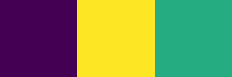

aclu: 10, neuron_IDX: 3, a_num_spikes: 1, a_f_i: [0.119036 0.165552 0.230498 0.271689 0.259706 0.19916 0.121958 0.0594212 0.0229592 0.00701368 0.00168941 0.000318348 4.26693e-05 0 0 0 0.000231399 0.00164261 0.00868325 0.035787 0.116328 0.300103 0.618714 1.02865 1.39511 1.56803 1.5012 1.30521 1.1822 1.28405 1.59535 1.94551 2.16232 2.23681 2.33139 2.61414 3.09268 3.6114 3.96738 4.00095 3.65283 3.02812 2.36915 1.87784 1.57231 1.36109 1.20945 1.15962 1.21936 1.30908 1.32199 1.20092 0.96375 0.683803 0.447405 0.315883]
aclu: 52, neuron_IDX: 24, a_num_spikes: 1, a_f_i: [0.735353 0.803095 0.924557 1.07556 1.2252 1.33439 1.37284 1.38112 1.54429 2.16108 3.44979 5.28964 7.12608 8.21521 8.09939 6.93582 5.3675 4.04463 3.23542 2.81209 2.49929 2.11334 1.64305 1.1955 0.899218 0.813625 0.878966 0.950618 0.913473 0.767988 0.601397 0.498185 0.490172 0.561085 0.660064 0.719107 0.698854 0.624986 0.552447 0.496659 0.427124 0.325307 0.219226 0.156506 0.162234 0.225683 0.312952 0.386116 0.419521 0.413135 0.39

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 448 B 
 448 B 
 
 
 
 Shape 
 (56,) 
 (56,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 56 
 1 
 
 
 
 
 
 
 
 
 [9.5753e-05 0.00077153 0.01047 0.0854872 0.303296 0.414295 0.190592 0.027965 0.00172605 8.8778e-05 7.05009e-06 7.24476e-07 3.94402e-08 0 0 0 3.27334e-09 1.03208e-07 1.03935e-06 2.90747e-06 4.2262e-06 8.51864e-06 2.40817e-05 3.39746e-05 1.15818e-05 7.99791e-07 1.02206e-08 2.08662e-11 6.90357e-15 4.22912e-18 1.37425e-15 1.27465e-10 3.61811e-06 0.0224681 32.0462 11121.1 1.0081e+06 2.66724e+07 2.44181e+08 8.74087e+08 1.22665e+09 6.60232e+08 1.4952e+08 1.9888e+07 2.57878e+06 397129 85030.6 31733.5 15659.4 5787.87 1346.12 317.185 150.149 142.759 154.973 147.816]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 448 B 
 448 B 
 
 
 
 Shape 
 (56,) 
 (56,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 56 
 1 
 
 
 
 
 
 
 
 
 [0.000853065 0.00417048 0.0471629 0.142623 0.475645 0.857078 0.273458 0.0438562 0.00224613 0.000133302 9.17439e-06 9.9112e-07 4.60602e-08 0 0 0 4.15043e-09 9.29808e-08 9.36363e-07 3.78354e-06 2.39727e-06 8.24302e-06 3.05344e-05 3.17417e-05 1.00477e-05 8.00601e-07 9.20789e-09 1.67099e-11 6.68021e-15 3.52783e-18 1.28393e-15 1.06329e-10 3.50105e-06 0.0179927 25.6629 9648.07 1.14367e+06 2.49194e+07 2.36281e+08 9.62469e+08 1.10511e+09 7.93081e+08 1.34705e+08 2.12354e+07 3.26976e+06 490288 110652 54001.7 31350.5 13905 9432.4 1090.11 355.711 571.615 506.758 98.644]

In [112]:
## INPUTS: an_aclus_list
long_LR_decoder: BasePositionDecoder = attached_directional_template_pfs_debugger.plots_data['track_templates'].long_LR_decoder # .decoders_dict
long_LR_decoder_pf1D: PfND = long_LR_decoder.pf

# long_LR_decoder.P_x # (n_pos_bins, 1)
# long_LR_decoder.F # (n_pos_bins, n_aclus)

# np.isin(long_LR_decoder.neuron_IDs

# np.isin(copy_pf._filtered_spikes_df.aclu, ids)
active_decoder_all_neuron_ids = deepcopy(long_LR_decoder.neuron_IDs).tolist()
print(len(active_decoder_all_neuron_ids))
active_neuron_IDXs = np.array([active_decoder_all_neuron_ids.index(aclu) for aclu in an_aclus_list])
active_neuron_IDXs


_product_terms = []
_sum_terms = []

P_x = np.squeeze(deepcopy(long_LR_decoder.P_x)) # (n_pos_bins, 1)
for aclu, neuron_IDX in zip(an_aclus_list, active_neuron_IDXs):
    a_f_i = np.squeeze(long_LR_decoder.F[:, neuron_IDX]) # (n_pos_bins, )
    a_num_spikes: int = int(active_time_bin_spike_counts_dict[aclu])
    assert a_num_spikes > 0, f"aclu: {aclu} has zero spikes??!?!"
    
    print(f'aclu: {aclu}, neuron_IDX: {neuron_IDX}, a_num_spikes: {a_num_spikes}, a_f_i: {a_f_i}')
    _product_terms.append(pow(a_f_i, a_num_spikes))
    
# long_LR_decoder.get_by_id(ids=an_aclus_list)

## TODO: Ideally I'd like to see:
# 1. each of the product terms:
# 2. P_x
# 3. The normalization terms (sum term)
_product = np.product(_product_terms, axis=0) # (n_pos_bins, )
_product

_product = np.product([P_x, _product], axis=0) # (n_pos_bins, )
_product

In [64]:
active_time_bin_spikes_df

,t,t_seconds,t_rel_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,is_theta,is_ripple,theta_phase_radians,neuron_type,flat_spike_idx,x_loaded,y_loaded,lin_pos,fragile_linear_neuron_IDX,PBE_id,scISI,lap_id,neuron_IDX
10597,1190058.0,954523.992028,36.558563,3,6,11,2,228.501286,138.745309,14.020321,4,1,1,1,True,False,5.756706,NeuronType.PYRAMIDAL,10597,0.800595,0.488466,229.951407,5,-1,0.268953,0,5
10601,1190318.0,954524.000015,36.566550,12,2,49,4,228.420712,138.668727,13.738484,4,1,1,1,True,False,6.089720,NeuronType.PYRAMIDAL,10601,0.799817,0.488367,229.848255,31,-1,0.534436,0,31
10618,1192537.0,954524.068183,36.634718,9,3,37,2,226.940377,138.427321,25.781906,4,1,1,1,True,False,3.107755,NeuronType.PYRAMIDAL,10618,0.794853,0.488177,228.902465,23,-1,0.114463,0,23
10620,1192710.0,954524.073497,36.640032,12,2,49,4,226.796180,138.418906,26.854485,4,1,1,1,True,False,3.357685,NeuronType.PYRAMIDAL,10620,0.794558,0.488186,228.842882,31,-1,0.073482,0,31
10621,1192769.0,954524.075310,36.641845,9,3,37,2,226.732161,138.417781,27.459111,4,1,1,1,True,False,3.483166,NeuronType.PYRAMIDAL,10621,0.794462,0.488189,228.866937,23,-1,0.007127,0,23
10624,1192877.0,954524.078628,36.645163,12,2,49,4,226.600514,138.417422,28.798561,4,1,1,1,True,False,3.650958,NeuronType.PYRAMIDAL,10624,0.794287,0.488194,228.954204,31,-1,0.005130,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10645,1195021.0,954524.144491,36.711026,9,3,37,2,223.149020,138.642870,62.205378,4,1,1,1,True,False,0.893655,NeuronType.PYRAMIDAL,10645,0.790729,0.488177,225.009299,23,-1,0.005806,0,23
10646,1195210.0,954524.150297,36.716832,9,3,37,2,222.729646,138.708504,64.519828,4,1,1,1,True,False,1.245269,NeuronType.PYRAMIDAL,10646,0.790256,0.488147,224.552811,23,-1,0.005806,0,23
10657,1195974.0,954524.173767,36.740302,9,3,37,2,221.034400,138.973819,73.875596,4,1,1,1,True,False,2.533182,NeuronType.PYRAMIDAL,10657,0.788234,0.488020,222.707535,23,-1,0.023470,0,23


In [ ]:
from pyphoplacecellanalysis.GUI.Napari.napari_helpers import napari_from_layers_dict

# custom_layers_dict = {'posterior': dict(blending='translucent', colormap='viridis', name=f'posterior', img_data=active_full_posterior)} # .transpose(1, 0, 2)
custom_layers_dict = {'posterior': dict(blending='translucent', colormap='viridis', name=f'active_curr_time_bin_posterior', img_data=active_curr_time_bin_posterior)} # .transpose(1, 0, 2)
directional_viewer, directional_image_layer_dict = napari_from_layers_dict(layers_dict=custom_layers_dict, title='P_x_given_X for selected epoch time bin') # , axis_labels=('aclu', 'lap', 'xbin')
# active_full_posterior
# curr_page_posterior_containers[0]['p_x_given_n'] ## these are already marginalized yeah?


In [ ]:

# custom_layers_dict = {'posterior': dict(blending='translucent', colormap='viridis', name=f'posterior', img_data=active_full_posterior)} # .transpose(1, 0, 2)
custom_layers_dict = {'posterior': dict(blending='translucent', colormap='viridis', name=f'active_curr_time_bin_posterior', img_data=active_curr_time_bin_posterior)} # .transpose(1, 0, 2)
directional_viewer, directional_image_layer_dict = napari_from_layers_dict(layers_dict=custom_layers_dict, title='P_x_given_X for selected epoch time bin') # , axis_labels=('aclu', 'lap', 'xbin')
# active_full_posterior
# curr_page_posterior_containers[0]['p_x_given_n'] ## these are already marginalized yeah?


In [ ]:
paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].plots_data.highlighted_epoch_time_bin_idx

In [ ]:
list(pagination_controller_dict['long_LR'].plots_data.keys()) #.highlighted_epoch_time_bin_idx # ['active_time_bin_spikes_df']


In [ ]:
pagination_controller_dict['short_RL'].plots_data.highlighted_epoch_time_bin_idx

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.get_children_props('params.on_secondary_click_item_callbacks') 
# attached_directional_template_pfs_debugger.update_cell_emphasis(solo_emphasized_aclus=[29, 4, 25])
attached_directional_template_pfs_debugger
# attached_directional_template_pfs_debugger

## >> Get the time bin within the clicked epoch

In [ ]:
# a_pagination_controller.plots_data.all_attributes

a_pagination_controller.paginator.current_page_idx

# 'paginator'

In [ ]:
from neuropy.core.epoch import find_data_indicies_from_epoch_times

# clicked_epoch_start_stop_time

## Get the time bin within the clicked epoch
def get_click_time_epoch_time_bin_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called to copy the clicked epoch's start/end time to the clipboard
    
    captures: attached_ripple_rasters_widget, attached_directional_template_pfs_debugger
    """
    from matplotlib.backend_bases import MouseButton, MouseEvent, LocationEvent, PickEvent
    
    from pyphocorehelpers.programming_helpers import copy_to_clipboard
    print(f'get_click_time_epoch_time_bin_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    print(f'\tevent: {event}\n\ttype(event): {type(event)}\n') # event: button_press_event: xy=(245, 359) xydata=(65.00700367785453, 156.55817377538108) button=3 dblclick=False inaxes=Axes(0.0296913,0.314173;0.944584x0.0753216)
    # type(event): <class 'matplotlib.backend_bases.MouseEvent'>
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'clicked widget at {clicked_ax}. [{start_t}, {end_t}]')
            code_string: str = f"[{start_t}, {end_t}]"
            found_time_bin_idx = None
            event_dict = {} 
            if isinstance(event, MouseEvent):
                # matplotlib mouse event
                if event.inaxes:                   
                    event_dict = {               
                        'data_x':event.xdata,
                        'data_y':event.ydata,
                        'pixel_x':event.x,
                        'pixel_y':event.y,
                    }
                    clicked_t_seconds: float = float(event.xdata)
                    # print(f'clicked_t_seconds: {clicked_t_seconds}')
                    ## find nearest time within the epoch
                    clicked_epoch_start_stop_time = self.plots_data.epoch_slices[clicked_data_index]
                    # print(f'clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time}')
                    included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers, curr_page_posterior_containers) = self.plots_data.paginator.get_page_data(page_idx=self.current_page_idx)
                    # print(f'\tincluded_page_data_indicies: {included_page_data_indicies}')
                    within_page_idx: int = clicked_data_index-included_page_data_indicies[0]
                    # print(f'\twithin_page_idx: {within_page_idx}')
                    # curr_slice_idx: int = included_page_data_indicies[within_page_idx]
                    # curr_epoch_slice = curr_page_active_filter_epochs[within_page_idx]
                    curr_time_bin_container = curr_page_time_bin_containers[within_page_idx]
                    # curr_posterior_container = curr_page_posterior_containers[within_page_idx]
                    # curr_time_bins = curr_time_bin_container.centers
                    time_bin_edges = curr_time_bin_container.edges
                    # print(f'\ttime_bin_edges: {time_bin_edges}')
                    time_bin_start_ts = time_bin_edges[:-1]
                    time_bin_stop_ts = time_bin_edges[1:]
                    epoch_time_bins_slices_df = pd.DataFrame({'start': time_bin_start_ts, 'stop': time_bin_stop_ts})
                    # display(epoch_time_bins_slices_df)
                    # found_time_bin_idx = find_data_indicies_from_epoch_times(epoch_time_bins_slices_df, epoch_times=np.array([clicked_t_seconds]), atol=0.0001, not_found_action='skip_index', debug_print=True)
                    # print(f'\tfound_time_bin_idx: {found_time_bin_idx}')
                    # found_time_bin_idx = None
                    for i, (t_start, t_end) in enumerate(zip(time_bin_start_ts, time_bin_stop_ts)):
                        if ((clicked_t_seconds >= t_start) and (clicked_t_seconds < t_end)) and (found_time_bin_idx is None):
                            ## found
                            found_time_bin_idx = i
                            print(f'found_time_bin_idx: {found_time_bin_idx}')
                            # break
                    if found_time_bin_idx is not None:
                        print(f'found_time_bin_idx: {found_time_bin_idx} for clicked time: {clicked_t_seconds}')
                        found_time_bin_start_t = time_bin_start_ts[found_time_bin_idx]
                        found_time_bin_stop_t = time_bin_stop_ts[found_time_bin_idx]
                        attached_ripple_rasters_widget.clear_highlighting_indicator_regions() ## only allow a single selection
                        attached_ripple_rasters_widget.add_highlighting_indicator_regions(t_start=found_time_bin_start_t, t_stop=found_time_bin_stop_t, identifier=f"TestTimeBinSelection[{clicked_data_index}, {found_time_bin_idx}]")
                        active_time_bin_spikes_df: pd.DataFrame = deepcopy(attached_ripple_rasters_widget.get_active_epoch_spikes_df().spikes.time_sliced(found_time_bin_start_t, found_time_bin_stop_t)) ## active spikes
                        active_time_bin_unique_active_aclus = np.unique(active_time_bin_spikes_df['aclu'].to_numpy()) ## active time-bin aclus
                        print(f'active_time_bin_unique_active_aclus: {active_time_bin_unique_active_aclus}')
                        attached_directional_template_pfs_debugger.update_cell_emphasis(active_time_bin_unique_active_aclus.tolist()) ## update the emphasis to the clicked bin only
                        
                    else:
                        print(f'could not find time bin for clicked time: {clicked_t_seconds}')

                else:
                    print('event out of axes!')
                    
            else:
                event_dict = {               
                    'scenePos':event.scenePos(),
                    'screenPos':event.screenPos(),
                    'pos':event.pos(),
                    'lastPos':event.lastPos(),
                }
            code_string = f'idx {clicked_data_index}\n'

            # render the `event_dict`
            for k, v in event_dict.items():
                code_string += f'\n\t{k}: {v}'

            # print(code_string)
            self.thin_button_bar_widget.label_message = f" {found_time_bin_idx} {code_string}"
            print(f'done.')
            

## Add the callback
# paginated_multi_decoder_decoded_epochs_window.
for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}
    a_pagination_controller.params.on_middle_click_item_callbacks['get_click_time_epoch_time_bin_callback'] = get_click_time_epoch_time_bin_callback


In [ ]:
attached_ripple_rasters_widget.clear_highlighting_indicator_regions()

# attached_ripple_rasters_widget.plots.epoch_indicator_regions = {}

In [ ]:
attached_yellow_blue_marginals_viewer_widget.go_to_page(3) # IndexError: index 20 is out of bounds for axis 0 with size 10
# self.plots_data.epoch_slices
# elf.plots_data.epoch_labels are all wrong

# DecodedEpochSlicesPaginatedFigureController.on_jump_to_page(page_idx: 2): YellowBlueMarginalEpochSlices
# 	included_page_data_indicies: [20 21 22 23 24 25 26 27 28 29]
# i : 0, curr_posterior.shape: (2, 16)
# a_slice_idx: 20
# WARNING: exceeded data indicies (probably on last page). (for page_idx: 2, i: 0, curr_ax: Axes(0.00643828,0.886859;0.987123x0.092637)).
# 	IndexError: index 20 is out of bounds for axis 0 with size 10
# i : 1, curr_posterior.shape: (2, 18)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.contents

In [ ]:
from pyphocorehelpers.assertion_helpers import Assert


Assert.path_exists(doc_output_parent_folder)
# decoder_laps_filter_epochs_decoder_result_dict
long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict


In [ ]:
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='DecodedFilterEpochsResult')
doc_printer.save_documentation('DecodedFilterEpochsResult', decoder_laps_filter_epochs_decoder_result_dict['long_LR'], non_expanded_item_keys=['_reverse_cellID_index_map'])


# directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()

### Add overlay data, etc

In [ ]:
# list(pagination_controller_dict['short_RL'].plots_data.keys()) # list(pagination_controller_dict['short_RL'].plots_data.keys())
# {'name': str,
#  'epoch_slices': numpy.ndarray,
#  'global_pos_df': pandas.core.frame.DataFrame,
#  'filter_epochs_decoder_result': pyphoplacecellanalysis.Analysis.Decoder.reconstruction.DecodedFilterEpochsResult,
#  'active_marginal_fn': function,
#  'paginator': pyphocorehelpers.indexing_helpers.Paginator}

# {k:type(v) for k, v in pagination_controller_dict['short_RL'].plots_data.items()}
# paginated_multi_decoder_decoded_epochs_window.get_children_props(prop_path='plots_data.epoch_slices')

paginated_multi_decoder_decoded_epochs_window.get_children_props(prop_path='params.active_identifying_figure_ctx.epochs')
# paginated_multi_decoder_decoded_epochs_window.get_children_props(prop_path='plots')

# 'fig'
# 'axs'


In [ ]:
paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.active_identifying_figure_ctx.epochs

In [ ]:
list(pagination_controller_dict['short_RL'].params.keys())

In [ ]:
paginated_multi_decoder_decoded_epochs_window.ui.attached_ripple_rasters_widget = None

In [ ]:
print_keys_if_possible('paginated_multi_decoder_decoded_epochs_window.ui', paginated_multi_decoder_decoded_epochs_window.ui, max_depth=3)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)



In [ ]:

paginated_multi_decoder_decoded_epochs_window.add_data_overlays(None, long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict)



In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(source='diba_evt_file')

## Export Last-Clicked Epoch Raster and Posteriors (array_as_image export)

In [ ]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

## Export Marginal Pseudo2D posteriors and rasters for middle-clicked epochs:
# root_export_path = Path(r"E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2024-05-01 - Pseudo2D Again\array_as_image").resolve() # Apogee
# root_export_path = Path('/media/halechr/MAX/cloud/University of Michigan Dropbox/Pho Hale/Pho Diba Paper 2023/array_as_image').resolve() # Lab
root_export_path = Path(r"E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2024-09-25 - Time bin considerations\array_as_image").resolve() # Apogee
# root_export_path: Path = Path(r"/media/halechr/MAX/cloud/University of Michigan Dropbox/Pho Hale/Pho Diba Paper 2023/array_as_image/long_like_during_post_delta_only").resolve() # Lab
root_export_path.mkdir(exist_ok=True)

epoch_specific_folder, (out_image_save_tuple_dict, _out_rasters_save_paths, merged_img_save_path) = paginated_multi_decoder_decoded_epochs_window.export_current_epoch_marginal_and_raster_images(directional_merged_decoders_result=directional_merged_decoders_result,
                                                                                                                                                                                                   active_context=curr_context, root_export_path = root_export_path,
)

file_uri_from_path(epoch_specific_folder)
fullwidth_path_widget(a_path=epoch_specific_folder, file_name_label="epoch_specific_folder:")

## Automatically Export on every middle click - 2024-09-26

In [ ]:
## Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior.
# @function_attributes(short_name=None, tags=['callback'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-04-29 17:16', related_items=[])
def export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters, directional_merged_decoders_result, (decoder_ripple_filter_epochs_decoder_result_dict, decoder_laps_filter_epochs_decoder_result_dict), curr_context
    """
    print(f'export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    # if clicked_epoch_start_stop_time is None:
    #     return # do nothing
    # if len(clicked_epoch_start_stop_time) == 2:
    #     return # do nothing
    
    ## Export Marginal Pseudo2D posteriors and rasters for middle-clicked epochs:
    # root_export_path = Path(r"E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2024-05-01 - Pseudo2D Again\array_as_image").resolve() # Apogee
    # root_export_path = Path('/media/halechr/MAX/cloud/University of Michigan Dropbox/Pho Hale/Pho Diba Paper 2023/array_as_image').resolve() # Lab
    root_export_path = Path(r"E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2024-09-25 - Time bin considerations\array_as_image").resolve() # Apogee
    # root_export_path: Path = Path(r"/media/halechr/MAX/cloud/University of Michigan Dropbox/Pho Hale/Pho Diba Paper 2023/array_as_image").resolve() # Lab

    epoch_specific_folder, (out_image_save_tuple_dict, _out_rasters_save_paths, merged_img_save_path) = PosteriorExporting._perform_export_current_epoch_marginal_and_raster_images(_out_ripple_rasters=_out_ripple_rasters, directional_merged_decoders_result=directional_merged_decoders_result, 
        # filtered_decoder_filter_epochs_decoder_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epoch_id_identifier_str='ripple',
        filtered_decoder_filter_epochs_decoder_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epoch_id_identifier_str='lap',
        active_session_context=curr_context, 
        root_export_path = root_export_path,
    )
    print(file_uri_from_path(epoch_specific_folder))
    

# _bak_update_attached_raster_viewer_epoch_callback = update_attached_raster_viewer_epoch_callback

# def _combined_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
#     """ Simply wraps `update_attached_raster_viewer_epoch_callback` and `export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback`
#     captures: _bak_update_attached_raster_viewer_epoch_callback, export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback
#     """
#     _bak_update_attached_raster_viewer_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time)
#     export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time)
    

## Modifies `update_attached_raster_viewer_epoch_callback` to perform the above stuff after its normal call

for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}
    # a_pagination_controller.params.on_middle_click_item_callbacks['update_attached_raster_viewer_epoch_callback'] = _combined_clicked_epoch_callback
    a_pagination_controller.params.on_middle_click_item_callbacks['export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback'] = export_current_epoch_marginal_posterior_and_raster_images_clicked_epoch_callback



## Test aligning time bin grid between rasters and posteriors

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import _extract_matplotlib_ax_xticks, _apply_xticks_to_pyqtgraph_plotitem

# _out_ripple_rasters.active_epoch_tuple
for a_decoder_name, a_render_plots_container in _out_ripple_rasters.plots['all_separate_plots'].items():
    # a_render_plots_container['grid']
    plot_item = a_render_plots_container['root_plot']
    # Access the x-axis
    x_axis = plot_item.getAxis('bottom')
    # Define custom ticks at desired x-values
    # Each tick is a tuple of (position, label)
    custom_ticks = [(pos, str(pos)) for pos in x_grid_positions]
    # Set the custom ticks
    # The setTicks method accepts a list of tick lists, one for each tick level
    x_axis.setTicks([custom_ticks])
    # Enable the grid and ensure it aligns with ticks
    plot_item.showGrid(x=True, y=True, alpha=0.5)

    # 'long_RL': RenderPlots({...})
    # ['root_plot']
    # 'grid', 'scatter_plot'

In [ ]:

tick_positions, tick_label_texts = _extract_matplotlib_ax_xticks(ax)
# Create a list of tuples for ticks: (position, label)
custom_ticks = list(zip(tick_positions, tick_label_texts))

_apply_xticks_to_pyqtgraph_plotitem(plot_item, custom_ticks=custom_ticks)

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    # v._subfn_clear_selectability_rects()
    # v.try_get_clicked_epoch
    # v.current_page_idx
    
    included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers, curr_page_posterior_containers) = v.plots_data.paginator.get_page_data(page_idx=v.current_page_idx)
    a_binning_container = deepcopy(curr_page_time_bin_containers[0]) # BinningContainer 
    curr_epoch_bin_edges: NDArray = deepcopy(a_binning_container.edges)
    # curr_epoch_bin_edges
    
    ## Get the plot to modify on the raster_plot_widget
    a_render_plots_container = _out_ripple_rasters.plots['all_separate_plots'][k] # RenderPlots
    plot_item = a_render_plots_container['root_plot']
    
    # Define custom ticks at desired x-values
    # Each tick is a tuple of (position, label)
    # custom_ticks = [(pos, str(pos)) for pos in curr_epoch_bin_edges]
    custom_ticks = [(pos, '') for pos in curr_epoch_bin_edges]
    
    _apply_xticks_to_pyqtgraph_plotitem(plot_item=plot_item, custom_ticks=custom_ticks)
    
    
    # v.plots_data['epoch_slices'] #.dynamically_added_attributes
    # epoch_durations = np.squeeze(np.diff(v.plots_data.epoch_slices, axis=1))
    # global_max_epoch_duration: float = np.max(epoch_durations)
    # global_max_epoch_duration
    # v.plots
    
# paginated_multi_decoder_decoded_epochs_window.draw()


In [ ]:
# Access the x-axis
x_axis = plot_item.getAxis('bottom')

# Define custom ticks at desired x-values
# Each tick is a tuple of (position, label)
custom_ticks = [(pos, str(pos)) for pos in x_grid_positions]

# Set the custom ticks
# The setTicks method accepts a list of tick lists, one for each tick level
x_axis.setTicks([custom_ticks])

# Enable the grid and ensure it aligns with ticks
plot_item.showGrid(x=True, y=True, alpha=0.5)



In [ ]:
from neuropy.utils.mixins.binning_helpers import BinningContainer


for k, v in filtered_decoder_filter_epochs_decoder_result_dict.items():
    # v: DecodedFilterEpochsResult
    a_binning_container: BinningContainer = v.time_bin_containers[0]
    a_binning_container.center_info.step
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    # v._subfn_clear_selectability_rects()
    # v.try_get_clicked_epoch
    # v.current_page_idx
    # v.plots
    


In [ ]:
mw.size() # PyQt5.QtCore.QSize(576, 1847)


In [ ]:

curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', render_track_identity_marginal_ripples=True)


In [ ]:
# pseudo2D_decoder #: BasePositionDecoder


# pseudo2D_decoder.P_x

### Resume misc `paginated_multi_decoder_decoded_epochs_window` manipulations

In [ ]:
paginated_multi_decoder_decoded_epochs_window.plotData

### Exploring adding buttons to button bar

In [ ]:
from types import MethodType
from attrs import asdict, astuple
from pyphocorehelpers.gui.Qt.ExceptionPrintingSlot import pyqtExceptionPrintingSlot
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import build_programmatic_buttons, ProgrammaticButtonConfig

global_thin_button_bar_widget: ThinButtonBarWidget = paginated_multi_decoder_decoded_epochs_window.global_thin_button_bar_widget

## INPUT: global_thin_button_bar_widget
button_config_list = [
#  dict(icon_path=':/png/gui/icons/document-open.png', name="OpenFile"),
#  dict(icon_path=':/png/gui/icons/document-save.png', name="SaveFile"),
#  dict(icon_path=':/png/gui/icons/crosshair.png', name="Crosshairs"),
#  dict(icon_path=':/png/gui/icons/crop.png', name="Crop"),
#  dict(icon_path=':/png/gui/icons/selected.png', name="Selections"),
#  dict(icon_path=':/png/gui/icons/view-raw.png', name="CopyAsArray"),
 dict(icon_path=':/png/gui/icons/view-refresh.png', name="Refresh", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.refresh_current_page())), ## captures: paginated_multi_decoder_decoded_epochs_window
 dict(icon_path=':/png/gui/icons/nxdata-create.png', name="AddDataOverlays", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict))), ## captures: paginated_multi_decoder_decoded_epochs_window, decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict
 dict(icon_path=':/png/gui/icons/mask-clear-all.png', name="RemoveDataOverlays", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.remove_data_overlays())), ## captures: paginated_multi_decoder_decoded_epochs_window
 dict(icon_path=':/png/gui/icons/document-print.png', name="PrintUserAnnotations", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.print_user_annotations())), ## captures: paginated_multi_decoder_decoded_epochs_window
 dict(icon_path=':/png/gui/icons/image-select-erase.png', name="LoadUserAnnotations", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations())), ## captures: paginated_multi_decoder_decoded_epochs_window
   
]
button_config_dict = {v['name']:v for v in button_config_list}

new_buttons_config_dict, new_buttons_dict = build_programmatic_buttons(global_thin_button_bar_widget, button_config_dict=button_config_dict, clear_all_existing=True)

# _tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()
# global_thin_button_bar_widget.horizontalLayout_ButtonContainer

In [ ]:
paginated_multi_decoder_decoded_epochs_window.global_thin_button_bar_widget

# paginated_multi_decoder_decoded_epochs_window.pagination_controllers

In [ ]:
# global_paginator_controller_widget.
global_thin_button_bar_widget.horizontalLayout.removeWidget(global_paginator_controller_widget)
global_paginator_controller_widget.setParent(None)
global_paginator_controller_widget.deleteLater()
global_paginator_controller_widget 

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Mixins.ComboBoxMixins import build_combo_box

new_combo_box = build_combo_box(label='Format', options=['Numpy','Png', 'Svg'])

global_thin_button_bar_widget.horizontalLayout.addWidget(new_combo_box) # add the pagination control widget




In [ ]:
global_thin_button_bar_widget.label_message = "\n\t".join(np.arange(80).astype(str))


In [ ]:
txtLineEdit = global_thin_button_bar_widget.ui.txtLineEdit # PyQt5.QtWidgets.QLineEdit
txtLineEdit.toolTip()
txtLineEdit.text()

In [ ]:
from PyQt5.QtCore import Qt

line_edit = txtLineEdit
full_text: str = "\n".join(np.arange(80).astype(str))
txtLineEdit.setToolTip(full_text)

fm = line_edit.fontMetrics()
available_width = int(round(line_edit.width() * 0.8))  - 2  # Subtracting a small margin
elided_text = fm.elidedText(full_text, Qt.ElideRight, available_width)
line_edit.setText(elided_text)
print(f'fm: {fm}')
print(f'available_width: {available_width}')
print(f'elided_text: {elided_text}')

In [ ]:
txtLineEdit.size()

In [ ]:
global_thin_button_bar_widget.clear_all_buttons()

In [ ]:
new_buttons_dict[ 'RemoveDataOverlays'].click()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()


In [ ]:
a_btn.pressed.disconnect()
a_btn.disconnect()

In [ ]:
getattr(global_thin_button_bar_widget, a_fn_name)(global_thin_button_bar_widget)

In [ ]:
a_dummy_btn_config.on_click_fn()
a_dummy_btn_config.fn_name

In [ ]:
global_thin_button_bar_widget.clear_all_buttons()


In [ ]:
self.perform_update_titles_from_context(page_idx=page_idx, included_page_data_indicies=included_page_data_indicies)
update_titles(self, window_title: str, suptitle: str = None)


def update_titles(self, window_title: str, suptitle: str = None):
    """ sets the suptitle and window title for the figure """
    if suptitle is None:
        suptitle = window_title # same as window title
    # Set the window title:
    self.ui.mw.setWindowTitle(window_title)
    self.ui.mw.fig.suptitle(suptitle, wrap=True) # set the plot suptitle
    self.ui.mw.draw()

### Custom click callbacks

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import ClickActionCallbacks

is_enabled = True
for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True    
    print(f"a_pagination_controller.params['on_middle_click_item_callbacks']: {a_pagination_controller.params['on_middle_click_item_callbacks']}")
    print(f"a_pagination_controller.params['on_secondary_click_item_callbacks']: {a_pagination_controller.params.get('on_secondary_click_item_callbacks', {})}")
    a_pagination_controller.params.should_suppress_callback_exceptions = False
    
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}
        
    if not a_pagination_controller.params.has_attr('on_secondary_click_item_callbacks'):
        a_pagination_controller.params['on_secondary_click_item_callbacks'] = {}
        
    a_pagination_controller.params['on_secondary_click_item_callbacks'] = {}
    
    if is_enabled:
        # a_pagination_controller.params.on_middle_click_item_callbacks['copy_click_time_to_clipboard_callback'] = ClickActionCallbacks.copy_click_time_to_clipboard_callback
        # a_pagination_controller.params.on_secondary_click_item_callbacks['copy_click_time_to_clipboard_callback'] = ClickActionCallbacks.copy_click_time_to_clipboard_callback
        a_pagination_controller.params.on_secondary_click_item_callbacks['copy_axis_image_to_clipboard_callback'] = ClickActionCallbacks.copy_axis_image_to_clipboard_callback
        
    else:
        # a_pagination_controller.params.on_middle_click_item_callbacks.pop('copy_click_time_to_clipboard_callback', None)
        # a_pagination_controller.params.on_secondary_click_item_callbacks.pop('copy_click_time_to_clipboard_callback', None)
        a_pagination_controller.params.on_secondary_click_item_callbacks.pop('copy_axis_image_to_clipboard_callback', None)
        
    # a_pagination_controller.params.on_secondary_click_item_callbacks.pop('copy_epoch_times_to_clipboard_callback', None)

        


# paginated_multi_decoder_decoded_epochs_window.params.on_middle_click_item_callbacks['copy_axis_image_to_clipboard_callback'] = ClickActionCallbacks.copy_axis_image_to_clipboard_callback

In [ ]:
## printing the callback values don't seem to work until after `paginated_multi_decoder_decoded_epochs_window.add_data_overlays(...)` is called.
# paginated_multi_decoder_decoded_epochs_window.enable_middle_click_selected_epoch_times_to_clipboard(is_enabled=False)
paginated_multi_decoder_decoded_epochs_window.enable_middle_click_selected_epoch_times_to_clipboard(is_enabled=True)

# clicked_epoch = np.array([132.51138943410479, 132.79100273095537])

# clicked_epoch = np.array([149.95935746072792, 150.25439218967222])

In [ ]:
clicked_epoch_start_stop_time = [488.296 488.484]
start_t = 488.29642327222973
found_IDX = 24

# ripple_idx=80, ripple_start_t=488.29642327222973


In [ ]:
@function_attributes(short_name=None, tags=['callback'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-04-29 17:16', related_items=[])
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)

In [ ]:
## Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior.
@function_attributes(short_name=None, tags=['callback'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-04-29 17:16', related_items=[])
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)


for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}    
    a_pagination_controller.params.on_middle_click_item_callbacks['an_alt_clicked_epoch_callback'] = an_alt_clicked_epoch_callback



In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget

a_name = 'long_RL'
a_pagination_controller = paginated_multi_decoder_decoded_epochs_window.pagination_controllers[a_name]
a_controlled_widget = a_pagination_controller.ui.mw # MatplotlibTimeSynchronizedWidget

thin_button_bar_widget: ThinButtonBarWidget = a_controlled_widget.ui.thin_button_bar_widget
# thin_button_bar_widget.label_message = "<controlled>"
# thin_button_bar_widget.txtLineEdit
# thin_button_bar_widget.ui.txtLineEdit.setText('test')
# thin_button_bar_widget.ui.txtLineEdit.text

# thin_button_bar_widget.parent().update()
# a_controlled_widget.update()
# print_keys_if_possible('a_pagination_controller.ui', a_pagination_controller.ui, max_depth=2)
# thin_button_bar_widget.label_message


In [ ]:
## INPUTS: a_pagination_controller
a_decoder_decoded_epochs_result: DecodedFilterEpochsResult = a_pagination_controller.plots_data.filter_epochs_decoder_result

active_epoch_data_idx: int = 28
print(f'active_epoch_data_idx: {active_epoch_data_idx}')
active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=active_epoch_data_idx)
active_captured_single_epoch_result

## Outputs: active_captured_single_epoch_result

# filter_epochs_decoder_result.filter_epochs
# filter_epochs_decoder_result.p_x_given_n_list[

In [ ]:
included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers, curr_page_posterior_containers) = a_pagination_controller.plots_data.paginator.get_page_data(page_idx=a_pagination_controller.current_page_idx)

# for i, curr_ax in enumerate(self.plots.axs):
    
curr_page_rel_idx: int = 0
curr_slice_idx: int = included_page_data_indicies[curr_page_rel_idx]
curr_epoch_slice = curr_page_active_filter_epochs[curr_page_rel_idx]
curr_time_bin_container = curr_page_time_bin_containers[curr_page_rel_idx]
curr_posterior_container = curr_page_posterior_containers[curr_page_rel_idx]
curr_time_bins = curr_time_bin_container.centers
curr_posterior = curr_posterior_container.p_x_given_n
curr_most_likely_positions = curr_posterior_container.most_likely_positions_1D

curr_posterior

In [ ]:
a_pagination_controller.get_total_pages()


In [ ]:
for i, (a_name, a_pagination_controller) in enumerate(paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items()):
    print(f'i: {i}, a_name: {a_name}')

In [ ]:
paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times

In [ ]:
paginated_multi_decoder_decoded_epochs_window.show_message("test message", durationMs=8000)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs


In [ ]:
## Get radon transform data:
a_pagination_controller = pagination_controller_dict['long_LR']
radon_transform_data = a_pagination_controller.plots_data['radon_transform_data']
radon_transform_data

In [ ]:
paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()


In [ ]:
# active_selections_dict = paginated_multi_decoder_decoded_epochs_window.save_selections()
# paginated_multi_decoder_decoded_epochs_window.ui.print = print
_annotations = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()
_annotations



In [ ]:
pagination_controller_dict['long_LR'].params.xbin

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.params.xbin

In [ ]:
# Show crosshair at cursor position
plt.connect('motion_notify_event', lambda event: plt.gcf().gca().format_coord(event.xdata, event.ydata))

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)

In [ ]:

print_keys_if_possible('paginated_multi_decoder_decoded_epochs_window', paginated_multi_decoder_decoded_epochs_window.ui, max_depth=2)

In [ ]:
from pyphocorehelpers.gui.Qt.widgets.toast_notification_widget import ToastWidget, ToastShowingWidgetMixin
# paginated_multi_decoder_decoded_epochs_window.ui._contents.windows

for a_name, a_window in paginated_multi_decoder_decoded_epochs_window.ui._contents.windows.items():
    message = 'This is a toast message!'
    a_window.toast.show_message(message)


In [ ]:
clicked_epoch = np.array([1316.0564141790383, 1316.2703788694926])

### Attached raster viewer widget

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import build_attached_raster_viewer_widget

_out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_ripple_simple_pf_pearson_merged_df)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.export_decoder_pagination_controller_figure_page

In [ ]:
# type(_out_ripple_rasters) # RankOrderRastersDebugger
# root_plots_dict: Dict[str, pg.PlotItem] = _out_ripple_rasters.root_plots_dict
# root_plots_dict

rasters_output_path = Path(r"C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\PhoDibaPaper2024Book\FIGURES").resolve()
assert rasters_output_path.exists()
example_replay_output_folder = rasters_output_path.joinpath('example_replay_2').resolve()
example_replay_output_folder.mkdir(parents=False, exist_ok=True)
_out_ripple_rasters.save_figure(export_path=example_replay_output_folder)



In [ ]:
paginated_multi_decoder_decoded_epochs_window.log

In [ ]:
win = _out_ripple_rasters.ui.root_dockAreaWindow
# win.setWindowTitle(f'Debug Directional Template Rasters <Controlled by DecodedEpochSlices window>')
win

In [ ]:
_out_ripple_rasters.setWindowTitle(f'Debug Directional Template Rasters <Controlled by DecodedEpochSlices window>')

In [ ]:
# Attempting to set identical low and high xlims makes transformation singular; automatically expanding. Is this what is causing the white posteriors?


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.posterior_heatmap_imshow_kwargs = dict(vmin=0.0)


In [ ]:

# paginated_multi_decoder_decoded_epochs_window.update_params(posterior_heatmap_imshow_kwargs = dict(vmin=0.0))

paginated_multi_decoder_decoded_epochs_window.update_params(enable_per_epoch_action_buttons=True)
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()


In [ ]:
paginated_multi_decoder_decoded_epochs_window.get_children_props('params')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('plots')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('plots.fig')
paginated_multi_decoder_decoded_epochs_window.get_children_props('plots.fig')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('params.posterior_heatmap_imshow_kwargs')

In [ ]:
# paginated_multi_decoder_decoded_epochs_window# AttributeError: 'PhoPaginatedMultiDecoderDecodedEpochsWindow' object has no attribute 'params'

paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.should_suppress_callback_exceptions = False 

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(3)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v._subfn_clear_selectability_rects()
    
# paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    a_ctrlr.perform_update_selections(defer_render=False)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [array([785.738, 785.923])]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [array([427.461, 427.557])]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [array([833.339, 833.451])]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [array([491.798, 492.178]), array([940.016, 940.219])]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[208.356, 208.523], [693.842, 693.975], [954.574, 954.679]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[224.037, 224.312]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[145.776, 146.022], [198.220, 198.582], [220.041, 220.259], [511.570, 511.874], [865.238, 865.373]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[191.817, 192.100], [323.147, 323.297]]



In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-paginated_multi_decoder_decoded_epochs_window_page.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    paginated_multi_decoder_decoded_epochs_window.jump_to_page(2)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(1)

In [ ]:
decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
track_templates.get_decoder_names()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v.params.enable_radon_transform_info = True
    v.params.enable_weighted_correlation_info = True
    v.params.debug_enabled = True

paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    print(f'decoder[{k}]:')
    v.params.name
    # v.params.on_render_page_callbacks
    # v.params.enable_radon_transform_info
    len(v.plots_data.radon_transform_data)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()

In [ ]:
def _sub_subfn_wrapped_in_brackets(s: str, bracket_strings = ("[", "]")) -> str:
        return bracket_strings[0] + s + bracket_strings[1]
    
def _sub_subfn_format_nested_list(arr, precision:int=3, num_sep=", ", array_sep=', ') -> str:
    """
    Converts a nested list of floats into a single string,
    with each float formatted to the specified precision.
    
    arr = np.array([[491.798, 492.178], [940.016, 940.219]])
    _sub_subfn_format_nested_list(arr)

    >> '[[491.798, 492.178], [940.016, 940.219]]'

    arr = np.array([[785.738, 785.923]])
    _sub_subfn_format_nested_list(arr)
    >> '[[785.738, 785.923]]'
    """
    return _sub_subfn_wrapped_in_brackets(array_sep.join([_sub_subfn_wrapped_in_brackets(num_sep.join([f"{num:.{precision}f}" for num in row])) for row in arr]))
    
# arr = np.array([[491.798, 492.178], [940.016, 940.219]])
arr = np.array([[785.738, 785.923]])
_sub_subfn_format_nested_list(arr)

### 2024-02-29 3pm - Get the active user-annotated epoch times from the `paginated_multi_decoder_decoded_epochs_window` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:

# Inputs: paginated_multi_decoder_decoded_epochs_window, filtered_ripple_simple_pf_pearson_merged_df
any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))


## :✅:🎯 2024-09-27 - Test programmatic/background saving of stacked decoded epoch figures

In [ ]:
# using: perform_export_all_decoded_posteriors_as_images
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportConfig, PosteriorExporting
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import Assert

## INPUTS:: long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict, long_like_during_post_delta_only_filter_epochs
active_epochs_decoder_result_dict = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)
parent_output_folder = Path('output/array_to_images').resolve()

# active_epochs_decoder_result_dict = deepcopy(long_like_during_post_delta_only_filtered_decoder_filter_epochs_decoder_result_dict)
# parent_output_folder = Path('output/long_like_during_post_delta').resolve()


active_epochs_decoder_result_dict = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict)


parent_output_folder.mkdir(exist_ok=True)
Assert.path_exists(parent_output_folder)
posterior_out_folder = parent_output_folder.joinpath(DAY_DATE_TO_USE).resolve()
posterior_out_folder.mkdir(parents=True, exist_ok=True)
save_path = posterior_out_folder.resolve()
_parent_save_context: IdentifyingContext = curr_active_pipeline.build_display_context_for_session('perform_export_all_decoded_posteriors_as_images')
_specific_session_output_folder = save_path.joinpath(active_context.get_description(subset_excludelist=['format_name'])).resolve()
_specific_session_output_folder.mkdir(parents=True, exist_ok=True)
print(f'\tspecific_session_output_folder: "{_specific_session_output_folder}"')

custom_export_formats: Dict[str, HeatmapExportConfig] = {
    'greyscale': HeatmapExportConfig.init_greyscale(desired_height=1200),
    'color': HeatmapExportConfig(colormap='Oranges', desired_height=1200),
    # 'color': HeatmapExportConfig(colormap=additional_cmaps['long_LR']),
    # 'color': HeatmapExportConfig(colormap=cmap1, desired_height=200),
}
custom_export_formats = None

out_paths, out_custom_formats_dict = PosteriorExporting.perform_export_all_decoded_posteriors_as_images(decoder_laps_filter_epochs_decoder_result_dict=None, decoder_ripple_filter_epochs_decoder_result_dict=active_epochs_decoder_result_dict,
                                                                                                            _save_context=_parent_save_context, parent_output_folder=_specific_session_output_folder,
                                                                                                            desired_height=1200, custom_export_formats=custom_export_formats)

## 🔶 2024-03-01 - Get the active user-annotated epoch times from the `UserAnnotationsManager` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:
from neuropy.utils.misc import numpyify_array
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.epoch import EpochsAccessor
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
## Get from UserAnnotations directly instead of the intermediate viewer

## # inputs: any_good_selected_epoch_times, any_good_selected_epoch_times, any_good_selected_epoch_indicies 

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies
# Add user-selection columns to df
a_df = deepcopy(filtered_ripple_simple_pf_pearson_merged_df)
# a_df = deepcopy(ripple_weighted_corr_merged_df)
a_df['is_user_annotated_epoch'] = False
# any_good_selected_epoch_indicies = a_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, np.squeeze(any_good_selected_epoch_times[:,0]), t_column_names=['ripple_start_t',])
# any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, any_good_selected_epoch_times, t_column_names=['ripple_start_t',])
any_good_selected_epoch_indicies
# a_df['is_user_annotated_epoch'] = np.isin(a_df.index.to_numpy(), any_good_selected_epoch_indicies)
a_df['is_user_annotated_epoch'].loc[any_good_selected_epoch_indicies] = True # Here's another .iloc issue! Changing to .loc
a_df


In [ ]:
df = DecoderDecodedEpochsResult.filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# delta_aligned_start_t

In [ ]:
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end

In [ ]:
df['_wcorr_y_col'] = df['long_best_wcorr'].abs()
df['_wcorr_y_col_y_diff_col'] = df['long_best_wcorr'].abs() - df['short_best_wcorr'].abs()
# df.plot.scatter(x='ripple_start_t', y='wcorr_y_col')
df.plot.scatter(x='delta_aligned_start_t', y='_wcorr_y_col_y_diff_col')



In [ ]:
# df['pearsonr_long_abs'] = df['long_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_short_abs'] = df['short_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_diff'] = df['long_best_pf_peak_x_pearsonr'].abs() - df['short_best_pf_peak_x_pearsonr'].abs()

# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_long_abs')
# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_short_abs')
df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_abs_diff')

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

### Add utility footer

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, get_utility_dock_colors
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget


def _add_utility_footer(paginated_multi_decoder_decoded_epochs_window):
    ui = paginated_multi_decoder_decoded_epochs_window.ui._contents
    # ui.dock_widgets
    # ui.dock_configs


    ## Build the utility controls at the bottom:
    ctrls_dock_config = CustomDockDisplayConfig(custom_get_colors_callback_fn=get_utility_dock_colors, showCloseButton=True, orientation='horizontal')

    button_bar_height = 21
    ctrls_button_bar_widget = ThinButtonBarWidget()
    ctrls_button_bar_widget.setObjectName("ctrls_button_bar")
    # Set the background color to blue with 40% opacity (RGBA)
    ctrls_button_bar_widget.setStyleSheet("background-color: rgba(0, 0, 255, 102);")

    ctrl_layout = pg.LayoutWidget()
    ctrl_layout.addWidget(ctrls_button_bar_widget, row=1, rowspan=1, col=1, colspan=2)
    ctrl_widgets_dict = dict(ctrls_widget=ctrls_button_bar_widget)
    # Set the background color to green with 40% opacity (RGBA)
    ctrl_layout.setStyleSheet("background-color: rgba(0, 255, 10, 102);")

    # ctrl_layout.setSizePolicy(

    def onCopySelectionsClicked():
        print(f'onCopySelectionsClicked()')
        saved_selections_contexts_dict = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

    ctrl_widgets_dict['copy_selection_connection'] = ctrls_button_bar_widget.sigCopySelections.connect(onCopySelectionsClicked)

    ui.dock_widgets['bottom_controls'] = paginated_multi_decoder_decoded_epochs_window.add_display_dock(identifier='bottom_controls', widget=ctrl_layout, dockSize=(600, button_bar_height), dockAddLocationOpts=['bottom'], display_config=ctrls_dock_config, autoOrientation=False)
    # ui.dock_widgets['bottom_controls'][1].hideTitleBar()
    ui.dock_widgets['bottom_controls']

    button_bar_height = 21

    a_layout = ui.dock_widgets['bottom_controls'][0]
    a_layout.size()
    a_layout.setContentsMargins(0,0,0,0)
    a_layout.setFixedHeight(21)
    ui.dock_widgets['bottom_controls'][1].size()
    ui.dock_widgets['bottom_controls'][1].setContentsMargins(0,0,0,0)
    ui.dock_widgets['bottom_controls'][1].setStyleSheet("background-color: rgba(255, 10, 10, 102);") # RED

    # ui.dock_widgets['bottom_controls'][1].hideTitleBar()
    # ui.dock_widgets['bottom_controls'][1].size

    return ctrl_layout, ctrls_dock_config, ui


ctrl_layout, ctrls_dock_config, ui = _add_utility_footer(paginated_multi_decoder_decoded_epochs_window=new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window)


In [ ]:
paginated_multi_decoder_decoded_epochs_window=new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window
ui = paginated_multi_decoder_decoded_epochs_window.ui._contents

layout_widget, dock_item = ui.dock_widgets['bottom_controls']
layout_widget.size()
# Set the background color to light grey
layout_widget.setStyleSheet("background-color: red;")

# layout_widget.setBackgroundColor('black')
layout_widget.setAutoFillBackground(True)

In [ ]:
 ui.dock_widgets['bottom_controls'][1].size()
 ui.dock_widgets['bottom_controls'][1].setFixedHeight(21)


In [ ]:
ui.dock_widgets['bottom_controls'][1].children()
# [<pyphoplacecellanalysis.External.pyqtgraph.dockarea.DockDrop.DropAreaOverlay object at 0x00000175C7D24820>,
#  <PyQt5.QtWidgets.QGridLayout object at 0x00000175C7D248B0>,
#  <pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock.DockLabel object at 0x00000175C7D24E50>,
#  <PyQt5.QtWidgets.QWidget object at 0x00000175C7D245E0>,
#  <pyphoplacecellanalysis.External.pyqtgraph.dockarea.DockDrop.DropAreaOverlay object at 0x00000175C7D24B80>]

ui.dock_widgets['bottom_controls'][1].layout


In [ ]:
dock_item.showTitleBar()

In [ ]:
dock_item.setOrientation('horizontal')

In [ ]:
dock_item.setContentsMargins(0,0,0,0)

In [ ]:
layout_widget.setContentsMargins(0,0,0,0)

In [ ]:
ui.dock_widgets['bottom_controls'][0].resize(600, 21)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.find_display_dock('bottom_controls')

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_display_dock('bottom_controls')

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager

## Set epoch annotations from selections epochs 
annotations_man = UserAnnotationsManager()
user_annotations = annotations_man.get_user_annotations()
new_selections_dict = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations)


In [ ]:
loaded_selections_objs_dict = {a_name:EpochSelectionsObject(epoch_times=a_selections_values) for a_name, a_selections_values in loaded_selections_dict.items()}
loaded_selections_objs_dict

## Select just the selected epoch times


In [ ]:
saved_selections_context_dict = {a_name:v.figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, v in saved_selections_dict.items()}

In [ ]:
user_annotations

In [ ]:
paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

In [ ]:
## Remove the excessively long plot titles?
# root_dockAreaWindow.update
pagination_controller_dict = paginated_multi_decoder_decoded_epochs_window.pagination_controllers
all_widgets = {a_decoder_name:a_pagination_controller.ui.mw for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_windows = {a_decoder_name:a_pagination_controller.ui.mw.window() for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots = {a_decoder_name:a_pagination_controller.plots for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots_data = {a_decoder_name:a_pagination_controller.plots_data for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_params = {a_decoder_name:a_pagination_controller.params for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx = {a_decoder_name:a_pagination_controller.current_page_idx for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx

In [ ]:
# all_separate_plots

all_separate_weighted_corr_plots = {a_decoder_name:a_pagination_controller.plots.get('weighted_corr', {}) for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_weighted_corr_plots

In [ ]:
self.ui.print = self.private_print # builtins.print # the print function to use

In [ ]:
from neuropy.core.epoch import EpochsAccessor

# MLM
# {a_name:a_ctrlr.params.is_selected for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}
# {a_name:a_ctrlr.selected_epoch_times for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}

any_good_selected_epoch_times: NDArray = paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times # drops duplicate rows (present in multiple decoders), and sorts them ascending
# any_good_selected_epoch_times
# Only at the decoder-level
any_good_epoch_idxs_list = [a_ctrlr.find_data_indicies_from_epoch_times(any_good_selected_epoch_times) for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items()]
any_good_epoch_idxs: NDArray = any_good_epoch_idxs_list[0]
any_good_epoch_idxs

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:

# filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)

found_data_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(epoch_times=any_good_selected_epoch_times)
df = filtered_ripple_simple_pf_pearson_merged_df.epochs._obj.iloc[found_data_indicies].copy().reset_index(drop=True)
df

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df


In [ ]:
hand_selected_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.iloc[any_good_epoch_idxs, :].reset_index(drop=True)
hand_selected_ripple_simple_pf_pearson_merged_df

In [ ]:
# hand_selected_ripple_simple_pf_pearson_merged_df['best_decoder_index']

is_most_likely_long = (hand_selected_ripple_simple_pf_pearson_merged_df['P_Long'] >= 0.5)
# is_most_likely_long

long_likely_hand_selected_ripple_simple_pf_pearson_merged_df = hand_selected_ripple_simple_pf_pearson_merged_df[is_most_likely_long]
long_likely_hand_selected_ripple_simple_pf_pearson_merged_df


## 🖼️🎨 Plot laps to compare between decoders:

In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

# decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs # looks like 'lap_dir' column is wrong
updated_laps_dfs_dict = {}

## Update the .filter_epochs:
for k, v in decoder_laps_filter_epochs_decoder_result_dict.items():
    updated_laps_dfs_dict[k] = Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs)))
    decoder_laps_filter_epochs_decoder_result_dict[k].filter_epochs =  updated_laps_dfs_dict[k]

# updated_laps_dfs_dict['long_LR']
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                            decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', included_epoch_indicies=None, 
    params_kwargs={'enable_per_epoch_action_buttons': False,
    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': False, 
    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': False,
    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
    # 'disable_y_label': True,
    # 'isPaginatorControlWidgetBackedMode': True,
    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
    # 'debug_print': True,
    'max_subplots_per_page': 10,
    'scrollable_figure': True,
    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
    'use_AnchoredCustomText': False,
    })


In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe

## INPUTS: decoder_laps_filter_epochs_decoder_result_dict

## Highlight the correct ones:
# {k:Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs))) for k, v in decoder_laps_filter_epochs_decoder_result_dict.items()}

## Select the true laps by emulating user_annotations:
filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
# filter_epochs

decoder_name_idx_map = {'long_LR': 0, 'long_RL': 1, 'short_LR': 2, 'short_RL': 3} 
selections_dict = {}
figure_ctx_dict = laps_paginated_multi_decoder_decoded_epochs_window.figure_ctx_dict
loaded_selections_context_dict = {a_name:a_figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, a_figure_ctx in figure_ctx_dict.items()}

for a_name, an_idx in decoder_name_idx_map.items():
    a_selections_context = loaded_selections_context_dict[a_name]
    selections_dict[a_selections_context] = filter_epochs[filter_epochs['true_decoder_index'] == an_idx][['start', 'stop']].to_numpy()


## Clearing the existing selection rects and them having them rebuilt when the selection is updated fixes them being shifted.
for k, v in laps_pagination_controller_dict.items():
    v._subfn_clear_selectability_rects()

# _tmp_out_selections = laps_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations=selections_dict)

In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)


In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.remove_data_overlays(defer_refresh=False)

In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.remov

In [ ]:
## Clearing the existing selection rects and them having them rebuilt when the selection is updated fixes them being shifted.
for k, v in laps_pagination_controller_dict.items():
    v._subfn_clear_selectability_rects()



In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict

In [ ]:
# list(decoder_laps_filter_epochs_decoder_result_dict.keys())
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
## Get the figure from the axes:
a_fig = ax.get_figure()
a_fig.canvas.draw()

In [ ]:
a_controlling_pagination_controller = laps_paginated_multi_decoder_decoded_epochs_window.contents.pagination_controllers['long_LR'] # DecodedEpochSlicesPaginatedFigureController
a_pagination_controller_figure_widget = paginator_controller_widget = a_controlling_pagination_controller.ui.mw # MatplotlibTimeSynchronizedWidget
paginator_controller_widget = a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget # PaginationControlWidget
# paginator_controller_widget
a_pagination_controller_figure_widget.draw()

In [ ]:
axs = a_controlling_pagination_controller.plots.axs

In [ ]:
ax.get_figure().canvas.draw()


In [ ]:
selection_rectangles_dict = a_controlling_pagination_controller.plots.get('selection_rectangles_dict', None)
selection_rectangles_dict


In [ ]:
# a_controlling_pagination_controller.plots.fig.canvas.draw_idle()
# a_controlling_pagination_controller.plots.fig.canvas.draw()
# paginator_controller_widget.update()
a_pagination_controller_figure_widget.draw()

In [ ]:
paginator_controller_widget.go_to_page(3)
# paginator_controller_widget.jump_to_page(3)

In [ ]:
a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget.jump_to_page

new_obj.plots_data.paginator
new_obj.params.active_identifying_figure_ctx
new_obj.on_paginator_control_widget_jump_to_page(page_idx=0)
new_obj.ui.connections['paginator_controller_widget_jump_to_page']


In [ ]:
for i, extant_plots in a_plots['weighted_corr'].items():
    extant_wcorr_text = extant_plots.get('wcorr_text', None)
    # extant_wcorr_text = extant_plots.pop('wcorr_text', None)
    print(f'extant_wcorr_text: {extant_wcorr_text}')
    # plot the radon transform line on the epoch:
    if (extant_wcorr_text is not None):
        # already exists, clear the existing ones. 
        # Let's assume we want to remove the 'Quadratic' line (line2)
        print(f'removing extant text object at index: {i}.')
        # extant_wcorr_text.remove()
        extant_wcorr_text.remove()

In [ ]:
for a_name, a_pagination_controller in pagination_controller_dict.items():
    display_context = a_pagination_controller.params.get('active_identifying_figure_ctx', IdentifyingContext())

    # Get context for current page of items:
    current_page_idx: int = int(a_pagination_controller.current_page_idx)
    a_paginator = a_pagination_controller.paginator
    total_num_pages = int(a_paginator.num_pages)
    page_context = display_context.overwriting_context(page=current_page_idx, num_pages=total_num_pages)
    print(page_context)

    ## Get the figure/axes:
    a_plots = a_pagination_controller.plots # RenderPlots
    a_plot_data = a_pagination_controller.plots_data

    a_params = a_pagination_controller.params
    a_params.skip_plotting_measured_positions

    figs = a_plots.fig
    axs = a_plots.axs

    # # with mpl.rc_context({'figure.figsize': (8.4, 4.8), 'figure.dpi': '220', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    # with mpl.rc_context({'figure.figsize': (16.8, 4.8), 'figure.dpi': '420', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    #     curr_active_pipeline.output_figure(final_context=page_context, fig=figs, write_vector_format=True)

## 💾 Export Paginated Content

In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)
# paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export_decoder_pagination_controller_figure_page(curr_active_pipeline)

## 🔷🎨 Single Decoder Version (`DecodedEpochSlicesPaginatedFigureController`)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import _subfn_update_decoded_epoch_slices
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController # `plot_decoded_epoch_slices_paginated`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import WeightedCorrelationPaginatedPlotDataProvider
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DecodedPositionsPlotDataProvider, DecodedAndActualPositionsPlotData
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import perform_plot_1D_single_most_likely_position_curve

# Inputs: epochs_name, decoder_ripple_filter_epochs_decoder_result_dict, curr_active_pipeline
# epochs_name = 'ripple'
epochs_name = 'laps'

(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]

# a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]

# a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]
a_decoder_decoded_epochs_result = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict[a_name]) ## FILTERED

_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(active_filter_epochs=a_decoder_decoded_epochs_result.filter_epochs,
                                                                                    filter_epochs_decoder_result= a_decoder_decoded_epochs_result,
                                                                                    xbin=a_decoder.xbin, global_pos_df=curr_active_pipeline.sess.position.df,
                                                                                    a_name=f'DecodedEpochSlices[{a_name}]', active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs=epochs_name, decoder=a_name),
                                                                                    max_subplots_per_page=32,
                                                                                    params_kwargs={'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 'enable_per_epoch_action_buttons': False,
                                                                                                    'enable_decoded_most_likely_position_curve': True, #'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 32,
                                                                                                    'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': True,
                                                                                                    'disable_toolbar': False,
                                                                                                    # 'build_fn': 'insets_view',
                                                                                    }, 
                                                                                    # disable_toolbar=False
                                                                                    )

_out_pagination_controller.params.should_suppress_callback_exceptions = False
_out_pagination_controller.add_data_overlays(a_decoder_decoded_epochs_result)
_tmp_out_selections = _out_pagination_controller.restore_selections_from_user_annotations()

In [ ]:
fig = _out_pagination_controller.plots.fig
# fig.toolbar

In [ ]:
# type(_out_pagination_controller)

_out_pagination_controller.plot_widget._buildUI_setup_statusbar()

single_epoch_field_names


In [ ]:
# on_selected_epochs_changed

active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=3)

def get_selected_posterior_on_secondary_clicked_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user alt-clicks an epoch 
    
    captures: active_captured_single_epoch_result
    """
    global active_captured_single_epoch_result
    if self.params.debug_print:
        print(f'get_selected_posterior_on_secondary_clicked_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            # print(f'start_t: {start_t}')
            clicked_data_index: int = _out_pagination_controller.find_data_indicies_from_epoch_times(epoch_times=np.array([start_t, end_t]))[0]
            if self.params.debug_print:
                print(f'\tclicked_data_index: {clicked_data_index}')            
            active_captured_single_epoch_result = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=clicked_data_index)
            if self.params.debug_print:
                print(f'\tactive_captured_single_epoch_result.epoch_info_tuple: {active_captured_single_epoch_result.epoch_info_tuple}')
                print(f'\tdone.')


# BEGIN FUNCTION BODY ________________________________________________________________________________________________ #
if not _out_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
    _out_pagination_controller.params['on_middle_click_item_callbacks'] = {}

_out_pagination_controller.params.on_middle_click_item_callbacks['get_selected_posterior_on_secondary_clicked_callback'] = get_selected_posterior_on_secondary_clicked_callback


In [ ]:
a_decoder_decoded_epochs_result.active_filter_epochs

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import get_array_as_image

posterior_image = active_captured_single_epoch_result.get_posterior_as_image(desired_width=2048)
posterior_image


In [ ]:
{i:col for i, col in enumerate(a_decoder_decoded_epochs_result.active_filter_epochs.columns)}

column_indicies = np.arange(12, 19)
column_indicies

In [ ]:
_out_pagination_controller.params.debug_print


## 2024-04-30 Heuristic 

In [ ]:
# *position_relative": mapped between the ends of the track, 0.0 to 1.0
most_likely_position_relative = (np.squeeze(active_captured_single_epoch_result.most_likely_position_indicies) / float(active_captured_single_epoch_result.n_xbins-1))
most_likely_position_relative


plt.hlines([0], colors='k', xmin=active_captured_single_epoch_result.time_bin_edges[0], xmax=active_captured_single_epoch_result.time_bin_edges[-1])
plt.step(active_captured_single_epoch_result.time_bin_container.centers[1:], np.diff(most_likely_position_relative))
plt.scatter(active_captured_single_epoch_result.time_bin_container.centers, most_likely_position_relative, color='r')


In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtGui, QtCore, QtWidgets
# from pyphoplacecellanalysis.External.pyqtgraph.parametertree.parameterTypes.file import popupFilePicker
from pyphoplacecellanalysis.External.pyqtgraph.widgets.FileDialog import FileDialog

from silx.gui import qt
from silx.gui.dialog.ImageFileDialog import ImageFileDialog
from silx.gui.dialog.DataFileDialog import DataFileDialog
import silx.io

from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import saveFile

app = pg.mkQApp('silx_testing')
app

In [ ]:
import numpy as np
from silx.gui.plot import Plot2D

matrix = np.random.rand(10, 10)  # Example 2D matrix
plot = Plot2D()
plot.addImage(matrix, colormap="viridis", vmin=0, vmax=1)
plot.show()

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

HeuristicReplayScoring.bin_wise_track_coverage_score_fn(a_result=a_decoder_decoded_epochs_result, an_epoch_idx=active_captured_single_epoch_result.epoch_data_index, a_decoder_track_length=170.0)

# np.diff(active_captured_single_epoch_result.most_likely_position_indicies)

In [ ]:
ax = _out_pagination_controller.plots.axs[0]
ax

In [ ]:
ax.format_coord

In [ ]:
# Find ascending sequences of most-likely positions




def format_coord(x, y):
    col = round(x)
    row = round(y)
    nrows, ncols = X.shape
    if 0 <= col < ncols and 0 <= row < nrows:
        z = X[row, col]
        return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}'
    else:
        return f'x={x:1.4f}, y={y:1.4f}'


ax.format_coord = format_coord


In [ ]:
# _out_pagination_controller.plot_widget.setStatusTip('LONG STATUS TIP TEST')

_out_pagination_controller.plot_widget.update_status('LONG STATUS TIP TEST')


In [ ]:
# _out_pagination_controller.plots.radon_transform
fig = _out_pagination_controller.plots.fig

# plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)
# Adjust the margins using subplots_adjust
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

# Adjust the margins using the Figure object
# fig.set_tight_layout(dict(rect=[0.1, 0.2, 0.8, 0.8]))
# fig.tight_layout(dict(rect=[0.1, 0.2, 0.8, 0.8]))
# fig.tight_layout(pad=1.0, rect=[0.1, 0.1, 0.8, 0.8])
_out_pagination_controller.draw()

In [ ]:
(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]
a_name

## 🔷🎨 2024-03-06 - Uni Page Scrollable Version

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

# decoder_decoded_epochs_result_dict: generic
single_page_app, single_page_paginated_multi_decoder_decoded_epochs_window, single_page_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'skip_plotting_most_likely_positions': False, 'enable_per_epoch_action_buttons': False,
                                                                                                               'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                                # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                                # 'disable_y_label': True,
                                                                                                                'isPaginatorControlWidgetBackedMode': True,
                                                                                                                'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                                # 'debug_print': True,
                                                                                                                'max_subplots_per_page': 64,
                                                                                                                'scrollable_figure': True,
                                                                                                                })


In [ ]:
single_page_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
_tmp_out_selections = single_page_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
# for curr_results_obj: LeaveOneOutDecodingAnalysisResult object
num_filter_epochs:int = curr_results_obj.active_filter_epochs.n_epochs

# `active_filter_epochs_df` native columns approach
active_filter_epochs_df = curr_results_obj.active_filter_epochs.to_dataframe().copy()
assert np.isin(['score', 'velocity', 'intercept', 'speed'], active_filter_epochs_df.columns).all()
epochs_linear_fit_df = active_filter_epochs_df[['score', 'velocity', 'intercept', 'speed']].copy() # get the `epochs_linear_fit_df` as a subset of the filter epochs df
# epochs_linear_fit_df approach
assert curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs == np.shape(epochs_linear_fit_df)[0]

num_filter_epochs:int = curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs # curr_results_obj.num_filter_epochs
try:
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.time_bin_containers)
except AttributeError as e:
    # AttributeError: 'LeaveOneOutDecodingAnalysisResult' object has no attribute 'time_bin_containers' is expected when `curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting`
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.all_included_filter_epochs_decoder_result.time_bin_containers) # for curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting

radon_transform_data = RadonTransformPlotDataProvider._subfn_build_radon_transform_plotting_data(active_filter_epochs_df=active_filter_epochs_df,
            num_filter_epochs = num_filter_epochs, time_bin_containers = time_bin_containers, radon_transform_column_names=['score', 'velocity', 'intercept', 'speed'])
    

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export

In [ ]:
# _display_long_and_short_stacked_epoch_slices
curr_active_pipeline.reload_default_display_functions()
_out_dict = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', save_figure=True)

## Other:

In [ ]:
_out = _out_pagination_controller.plots['radon_transform'][7]
extant_line = _out['line'] # matplotlib.lines.Line2D
extant_line.linestyle = 'none'
# extant_line.draw()



In [ ]:
print(list(curr_active_pipeline.filtered_contexts.keys())) # ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Converting between decoder names and filtered epoch names:
# {'long':'maze1', 'short':'maze2'}
# {'LR':'odd', 'RL':'even'}
long_LR_name, short_LR_name, long_RL_name, short_RL_name = ['maze1_odd', 'maze2_odd', 'maze1_even', 'maze2_even']
decoder_name_to_session_context_name: Dict[str,str] = dict(zip(track_templates.get_decoder_names(), (long_LR_name, long_RL_name, short_LR_name, short_RL_name))) # {'long_LR': 'maze1_odd', 'long_RL': 'maze1_even', 'short_LR': 'maze2_odd', 'short_RL': 'maze2_even'}
session_context_to_decoder_name: Dict[str,str] = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), track_templates.get_decoder_names())) # {'maze1_odd': 'long_LR', 'maze1_even': 'long_RL', 'maze2_odd': 'short_LR', 'maze2_even': 'short_RL'}

decoder_name_to_session_context_name
session_context_to_decoder_name

In [ ]:
active_num_slices: int = _out_pagination_controller.params.active_num_slices
single_plot_fixed_height: float = _out_pagination_controller.params.single_plot_fixed_height
all_plots_height: float = _out_pagination_controller.params.all_plots_height
print(f'all_plots_height: {all_plots_height}')

In [ ]:
laps_weighted_corr_merged_df

In [ ]:
from PendingNotebookCode import _add_maze_id_to_epochs


## Add new weighted correlation results as new columns in existing filter_epochs df:
active_filter_epochs = long_results_obj.active_filter_epochs
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
active_filter_epochs = _add_maze_id_to_epochs(active_filter_epochs, short_session.t_start)
active_filter_epochs._df['weighted_corr_LONG'] = epoch_long_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_SHORT'] = epoch_short_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_spearman_LONG'] = epoch_long_weighted_corr_results[:,1]
active_filter_epochs._df['weighted_corr_spearman_SHORT'] = epoch_short_weighted_corr_results[:,1]


active_filter_epochs
active_filter_epochs.to_dataframe()
## plot the `weighted_corr_LONG` over time

# fig, axes = plt.subplots(ncols=1, nrows=active_num_rows, sharex=True, sharey=sharey, figsize=figsize)

## Weighted Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_LONG', title='weighted_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
## Weighted Spearman Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_LONG', title='weighted_spearman_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Spearman Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='score_LONG', title='Radon Transform Score during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='score_SHORT', xlabel='Replay Epoch Time', ylabel='Replay Radon Transform Score', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line


In [ ]:
curr_active_pipeline.reload_default_display_functions()
example_stacked_epoch_graphics = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', defer_render=False, save_figure=False)


## TODO 2024-02-15 8pm - Add in to previous result:

In [ ]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity

# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
laps_simple_pf_pearson_merged_df
# laps_radon_transform_merged_df

In [ ]:
directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

decoder_aclu_peak_location_df_merged = deepcopy(track_templates.get_directional_pf_maximum_peaks_dfs(drop_aclu_if_missing_long_or_short=False))
# decoder_aclu_peak_location_df_merged[np.isin(decoder_aclu_peak_location_df_merged['aclu'], both_included_neuron_stats_df.aclu.to_numpy())]
decoder_aclu_peak_location_df_merged


In [ ]:
a_result: TrialByTrialActivity = directional_active_lap_pf_results_dicts['long_LR']
# a_result.sp


# 💾 2024-03-04 - Export `DecoderDecodedEpochsResult` CSVs with user annotations for epochs:

In [ ]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

# 2024-03-04 - Filter out the epochs based on the criteria:
_, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()

## 2024-03-08 - Also constrain the user-selected ones (just to try it):
decoder_user_selected_epoch_times_dict, any_user_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)

a_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
# {a_name:ensure_dataframe(a_result.filter_epochs) for a_name, a_result in a_result_dict.items()}

directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=True)

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

## Merge the heuristic columns into the wcorr df columns for exports
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df

# {a_name:DecoderDecodedEpochsResult.try_add_is_user_annotated_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=filtered_valid_epoch_times) for a_name, a_result in a_result_dict.items()}

for a_name, a_result in a_result_dict.items():
    # a_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=True)

    ## Merge the heuristic columns into the wcorr df columns for exports
    # directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    a_wcorr_result = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict[a_name]
    
    # did_update_user_annotation_col = DecoderDecodedEpochsResult.try_add_is_user_annotated_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=any_user_selected_epoch_times, t_column_names=None)
    # print(f'did_update_user_annotation_col: {did_update_user_annotation_col}')
    # did_update_is_valid = DecoderDecodedEpochsResult.try_add_is_valid_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=filtered_valid_epoch_times, t_column_names=None)
    # print(f'did_update_is_valid: {did_update_is_valid}')

# ['start',]

a_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

# {a_name:ensure_dataframe(a_result.filter_epochs) for a_name, a_result in a_result_dict.items()}

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pathlib import Path

# 💾 export_csvs

# BATCH_DATE_TO_USE: str = f'{get_now_day_str()}_APOGEE' # TODO: Change this as needed, templating isn't actually doing anything rn.

known_collected_outputs_paths = [Path(v).resolve() for v in ('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs', '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', '/home/halechr/cloud/turbo/Data/Output/collected_outputs', '/home/halechr/FastData/gen_scripts/', '/home/halechr/FastData/collected_outputs/', 'output/gen_scripts/')]
collected_outputs_path = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: '{collected_outputs_path}' does not exist! Is the right computer's config commented out above?"
print(f'collected_outputs_path: "{collected_outputs_path}"')
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
print(f'\tComputation complete. Exporting .CSVs...')

# 2024-03-04 - Filter out the epochs based on the criteria:
_, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                              user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                              valid_epochs_selections={'ripple': filtered_valid_epoch_times})

print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

# {'laps_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'ripple_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'laps_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_simple_pf_pearson_merged_df)_tbin-0.025.csv'),
#  'ripple_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_simple_pf_pearson_merged_df)_tbin-0.025.csv')}


In [ ]:
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df

In [ ]:
filtered_epochs_df

In [ ]:
any_good_selected_epoch_times

# 2024-03-04 - Filter out the epochs based on the criteria:

In [ ]:
# from neuropy.utils.mixins.time_slicing import add_epochs_id_identity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes

# 2024-03-04 - Filter out the epochs based on the criteria:
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, required_min_percentage_of_active_cells=0.333333, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_epochs_df

# 🟢 2024-03-27 - Look at active set cells

In [37]:
from neuropy.utils.mixins.HDF5_representable import HDFConvertableEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import TruncationCheckingResults


## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap

truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_aclus_dict, jonathan_firing_rate_analysis_result.neuron_replay_stats_df = truncation_checking_result.build_truncation_checking_aclus_dict(neuron_replay_stats_df=jonathan_firing_rate_analysis_result.neuron_replay_stats_df)

frs_index_inclusion_magnitude:float = 0.5

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())

## Unrefined:
# neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)

## Refine the LxC/SxC designators using the firing rate index metric:

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']
jonathan_firing_rate_analysis_result.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)

neuron_replay_stats_df, *exclusivity_tuple = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)
# short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = exclusivity_tuple
exclusivity_aclus_tuple = [v.track_exclusive_aclus for v in exclusivity_tuple]
exclusivity_aclus_dict = dict(zip(['short_exclusive', 'long_exclusive', 'BOTH', 'EITHER', 'XOR', 'NEITHER'], exclusivity_aclus_tuple))
any_aclus = union_of_arrays(*exclusivity_aclus_tuple)
exclusivity_aclus_dict['any'] = any_aclus
refined_exclusivity_aclus_tuple = [v.get_refined_track_exclusive_aclus() for v in exclusivity_tuple]
neuron_replay_stats_df: pd.DataFrame = HDFConvertableEnum.convert_dataframe_columns_for_hdf(neuron_replay_stats_df)

# These keys exhaustively span all aclus:
exhaustive_key_names = ['short_exclusive', 'long_exclusive', 'BOTH', 'NEITHER']
assert np.all(any_aclus == union_of_arrays(*[exclusivity_aclus_dict[k] for k in exhaustive_key_names]))
exhaustive_key_dict = {k:v for k, v in exclusivity_aclus_dict.items() if k in exhaustive_key_names}


neuron_replay_stats_df

True

WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above


,long_pf_peak_x,has_long_pf,short_pf_peak_x,has_short_pf,has_na,track_membership,long_non_replay_mean,short_non_replay_mean,non_replay_diff,long_replay_mean,short_replay_mean,replay_diff,long_mean,short_mean,mean_diff,neuron_IDX,num_replays,long_num_replays,short_num_replays,neuron_type,aclu,custom_frs_index,is_rate_extrema,is_refined_exclusive,is_refined_LxC,is_refined_SxC,is_long_peak_left_cap,is_long_peak_right_cap,is_long_peak_either_cap,LS_pf_peak_x_diff,long_LR_pf2D_peak_x,long_LR_pf2D_peak_y,long_RL_pf2D_peak_x,long_RL_pf2D_peak_y,short_LR_pf2D_peak_x,short_LR_pf2D_peak_y,short_RL_pf2D_peak_x,short_RL_pf2D_peak_y,long_LR_pf1D_peak,long_RL_pf1D_peak,short_LR_pf1D_peak,short_RL_pf1D_peak,peak_diff_LR_pf1D_peak,peak_diff_RL_pf1D_peak,truncation_checking
24,38.987020,True,80.998879,True,False,SHARED,1.776048,1.905966,0.129918,7.353298,8.670112,1.316814,4.564673,5.288039,0.723366,22,48,20,28,pyr,24,0.031718,False,False,False,False,True,False,True,-42.011859,51.560024,144.159565,46.127074,145.232328,132.355798,138.799447,80.470896,142.165456,189.847786,231.859645,216.582605,201.305565,26.734819,-30.554079,significant_distant_remapping_endcap
40,38.987020,True,84.818138,True,False,SHARED,2.497139,2.522386,0.025247,11.168860,10.773726,-0.395133,6.832999,6.648056,-0.184943,38,65,28,37,pyr,40,0.176931,False,False,False,False,True,False,True,-45.831119,57.510811,141.284097,47.978713,143.379777,81.477671,145.063371,86.226591,143.909778,NaN,59.992949,NaN,98.185548,NaN,38.192599,significant_distant_remapping_endcap
7,38.987020,True,84.818138,True,False,SHARED,2.142253,1.203377,-0.938876,25.374437,26.094382,0.719945,13.758345,13.648879,-0.109466,5,55,20,35,pyr,7,0.285142,False,False,False,False,True,False,True,-45.831119,39.694599,144.645039,58.161806,145.262846,83.907825,142.432066,78.251594,138.760617,NaN,NaN,82.908509,79.089249,NaN,NaN,significant_distant_remapping_endcap
29,38.987020,True,84.818138,True,False,SHARED,0.781524,0.525565,-0.255959,4.993679,7.069568,2.075889,2.887602,3.797567,0.909965,27,13,2,11,pyr,29,0.240026,False,False,False,False,True,False,True,-45.831119,39.167761,139.832646,50.539269,145.350593,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,significant_distant_remapping_endcap
45,38.987020,True,92.456658,True,False,SHARED,4.865325,2.699642,-2.165683,28.236896,29.692539,1.455643,16.551111,16.196091,-0.355020,43,79,33,46,pyr,45,0.305725,False,False,False,False,True,False,True,-53.469639,106.41955,138.82088,52.107761,145.319514,89.474083,141.045479,85.484648,140.025111,NaN,147.835927,NaN,144.016667,NaN,-3.81926,significant_distant_remapping_endcap
14,54.264059,True,92.456658,True,False,SHARED,0.965604,1.454652,0.489049,11.058503,9.998168,-1.060336,6.012053,5.726410,-0.285643,12,32,7,25,pyr,14,-0.106409,False,False,False,False,True,False,True,-38.192599,50.290395,138.896749,50.477598,138.725886,80.87735,144.470423,84.936068,138.730021,132.558887,NaN,144.016667,NaN,11.45778,NaN,trivially_remapping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,NaN,False,NaN,False,True,SHARED,24.462105,21.440529,-3.021576,44.065585,45.281708,1.216124,34.263845,33.361119,-0.902726,34,132,57,75,intr,36,0.070517,False,False,False,False,False,False,False,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,none
38,NaN,False,NaN,False,True,SHARED,11.489733,9.857440,-1.632293,38.267453,30.290939,-7.976514,24.878593,20.074190,-4.804403,36,130,57,73,intr,38,0.077371,False,False,False,False,False,False,False,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,none
42,NaN,False,NaN,False,True,SHARED,11.005091,9.960649,-1.044442,33.468675,40.646337,7.177662,22.236883,25.303493,3.066610,40,133,57,76,intr,42,0.074447,False,False,False,False,False,False,False,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,none


In [ ]:
old_any_aclus = np.array([  3,   4,   5,   7,  10,  11,  13,  14,  15,  17,  23,  24,  25,  26,  31,  32,  33,  34,  45,  49,  50,  51,  52,  54,  55,  58,  61,  64,  68,  69,  70,  71,  73,  74,  75,  76,  78,  81,  82,  83,  84,  85,  87,  90,  92,  93,  96,  97, 102, 109])
old_appearing_aclus = np.array([ 4, 11, 13, 23, 52, 58, 87])

In [ ]:
any_aclus = union_of_arrays(*[v for v in truncation_checking_aclus_dict.values() if len(v) > 0])
any_aclus


In [ ]:
neuron_replay_stats_df

In [38]:
from neuropy.core.ratemap import Ratemap
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import perform_sweep_lap_groud_truth_performance_testing, _perform_variable_time_bin_lap_groud_truth_performance_testing

# desired_laps_decoding_time_bin_size: float = 0.75
desired_laps_decoding_time_bin_size: float = 0.5

## INPUTS: exclusivity_aclus_tuple, desired_laps_decoding_time_bin_size: float
# short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = exclusivity_aclus_tuple
# included_neuron_ids_list = [short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset]

# included_neuron_ids_list = [*exclusivity_aclus_tuple]

## INPUTS: truncation_checking_aclus_dict
included_neuron_ids_list = list(truncation_checking_aclus_dict.values())
row_names = list(truncation_checking_aclus_dict.keys())

_output_tuples_list = perform_sweep_lap_groud_truth_performance_testing(curr_active_pipeline, 
                                                                        included_neuron_ids_list=included_neuron_ids_list,
                                                                        desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size)

percent_laps_correctness_df: pd.DataFrame = pd.DataFrame.from_records([complete_decoded_context_correctness_tuple.percent_correct_tuple for (a_directional_merged_decoders_result, result_laps_epochs_df, complete_decoded_context_correctness_tuple) in _output_tuples_list],
                          columns=("track_ID_correct", "dir_correct", "complete_correct"), index=row_names)
percent_laps_correctness_df


tuning_curves_ndim: 0 not implemented!


NotImplementedError: tuning_curves_ndim: 0 not implemented!

# ❕🟢 2024-10-07 - Rigorous Decoder Performance assessment
2024-03-29 - Quantify cell contributions to decoders

In [ ]:
# Inputs: all_directional_pf1D_Decoder, alt_directional_merged_decoders_result
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult, TrainTestLapsSplitting, CustomDecodeEpochsResult, decoder_name, epoch_split_key, get_proper_global_spikes_df, DirectionalPseudo2DDecodersResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _do_train_test_split_decode_and_evaluate
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import PfND
from neuropy.core.session.dataSession import Laps
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import compute_weighted_correlations
# from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _check_result_laps_epochs_df_performance

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_session = curr_active_pipeline.filtered_sessions[global_epoch_name]

def _add_extra_epochs_df_columns(epochs_df: pd.DataFrame):
    """ captures: global_session, t_start, t_delta, t_end
    """
    epochs_df = epochs_df.sort_values(['start', 'stop', 'label']).reset_index(drop=True) # Sort by columns: 'start' (ascending), 'stop' (ascending), 'label' (ascending)
    epochs_df = epochs_df.drop_duplicates(subset=['start', 'stop', 'label'])
    epochs_df = epochs_df.epochs.adding_maze_id_if_needed(t_start=t_start, t_delta=t_delta, t_end=t_end)
    epochs_df = Laps._compute_lap_dir_from_smoothed_velocity(laps_df=epochs_df, global_session=deepcopy(global_session), replace_existing=True)
    return epochs_df

directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
force_recompute_directional_train_test_split_result: bool = False
if (directional_train_test_split_result is None) or force_recompute_directional_train_test_split_result:
    ## recompute
    print(f"'TrainTestSplit' not computed, recomputing...")
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_train_test_split'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
    directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data['TrainTestSplit']
    assert directional_train_test_split_result is not None, f"faiiled even after recomputation"
    print('\tdone.')

training_data_portion: float = directional_train_test_split_result.training_data_portion
test_data_portion: float = directional_train_test_split_result.test_data_portion
print(f'training_data_portion: {training_data_portion}, test_data_portion: {test_data_portion}')

test_epochs_dict: Dict[types.DecoderName, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
train_epochs_dict: Dict[types.DecoderName, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
train_lap_specific_pf1D_Decoder_dict: Dict[types.DecoderName, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict

# OUTPUTS: train_test_split_laps_df_dict
active_laps_decoding_time_bin_size: float = 0.25
# active_laps_decoding_time_bin_size: float = 2.5
# active_laps_decoding_time_bin_size: float = 5.5
complete_decoded_context_correctness_tuple, laps_marginals_df, all_directional_pf1D_Decoder, all_test_epochs_df, all_directional_laps_filter_epochs_decoder_result, _out_separate_decoder_results = _do_train_test_split_decode_and_evaluate(curr_active_pipeline=curr_active_pipeline,
                                                                                                                                                                                                                active_laps_decoding_time_bin_size=active_laps_decoding_time_bin_size, included_neuron_IDs=disappearing_aclus,
                                                                                                                                                                                                                force_recompute_directional_train_test_split_result=False, compute_separate_decoder_results=True)
(is_decoded_track_correct, is_decoded_dir_correct, are_both_decoded_properties_correct), (percent_laps_track_identity_estimated_correctly, percent_laps_direction_estimated_correctly, percent_laps_estimated_correctly) = complete_decoded_context_correctness_tuple
print(f"percent_laps_track_identity_estimated_correctly: {round(percent_laps_track_identity_estimated_correctly*100.0, ndigits=3)}%")

if _out_separate_decoder_results is not None:
    assert len(_out_separate_decoder_results) == 3, f"_out_separate_decoder_results: {_out_separate_decoder_results}"
    test_decoder_results_dict, train_decoded_results_dict, train_decoded_measured_diff_df_dict = _out_separate_decoder_results
    ## OUTPUTS: test_decoder_results_dict, train_decoded_results_dict
_remerged_laps_dfs_dict = {}
for a_decoder_name, a_test_epochs_df in test_epochs_dict.items():
    a_train_epochs_df = train_epochs_dict[a_decoder_name]
    a_train_epochs_df['test_train_epoch_type'] = 'train'
    a_test_epochs_df['test_train_epoch_type'] = 'test'
    _remerged_laps_dfs_dict[a_decoder_name] = pd.concat([a_train_epochs_df, a_test_epochs_df], axis='index')
    _remerged_laps_dfs_dict[a_decoder_name] = _add_extra_epochs_df_columns(epochs_df=_remerged_laps_dfs_dict[a_decoder_name])


# _add_extra_epochs_df_columns
# _remerged_laps_dfs_dict = {k: pd.concat([v, test_epochs_dict[k]], axis='index') for k, v in train_epochs_dict.items()}	
# _remerged_laps_dfs_dict['long_LR']


## OUTPUTS: all_test_epochs_df, train_epochs_dict, test_epochs_dict, _remerged_laps_dfs_dict
# all_test_epochs_df

# Performed 3 aggregations grouped on column: 'lap_id'
# all_test_epochs_df = all_test_epochs_df.groupby(['lap_id']).agg(start_min=('start', 'min'), stop_max=('stop', 'max'), maze_id_first=('maze_id', 'first')).reset_index()


In [ ]:
print(f'disappearing_aclus: {disappearing_aclus}')
_alt_directional_train_test_split_result = directional_train_test_split_result.sliced_by_neuron_id(included_neuron_ids=disappearing_aclus)
_alt_directional_train_test_split_result

In [ ]:
_alt_directional_train_test_split_result.

In [ ]:
is_decoded_track_correct ## get an across_session_scatter output like we do for the ripples


### Display the `TrainTestSplitResult` in a `PhoPaginatedMultiDecoderDecodedEpochsWindow`

In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

## INPUTS: train_decoded_results_dict
# decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs # looks like 'lap_dir' column is wrong

# active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
active_results: Dict[types.DecoderName, DecodedFilterEpochsResult] = deepcopy(train_decoded_results_dict)

# updated_laps_dfs_dict = {}
# ## Update the .filter_epochs:
# for k, v in active_results.items():
#     updated_laps_dfs_dict[k] = Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs)))
#     active_results[k].filter_epochs =  updated_laps_dfs_dict[k]

# updated_laps_dfs_dict['long_LR']
# active_results['long_LR'].filter_epochs

laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                            decoder_decoded_epochs_result_dict=active_results, epochs_name='laps', included_epoch_indicies=None, 
    params_kwargs={'enable_per_epoch_action_buttons': False,
    'skip_plotting_most_likely_positions': False, 'skip_plotting_measured_positions': False, 
    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': False,
    'enable_decoded_most_likely_position_curve': True, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
    # 'disable_y_label': True,
    # 'isPaginatorControlWidgetBackedMode': True,
    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
    # 'debug_print': True,
    'max_subplots_per_page': 10,
    'scrollable_figure': True,
    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
    'use_AnchoredCustomText': False,
    })

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import TrainTestSplitPlotDataProvider, TrainTestSplitPlotData


## INPUTS: all_test_epochs_df, train_epochs_dict, test_epochs_dict, _remerged_laps_dfs_dict
# a_decoder_name: str='long_LR'
# a_ctrlr = laps_pagination_controller_dict[a_decoder_name]

for a_decoder_name, a_ctrlr in laps_pagination_controller_dict.items():
    # Build Radon Transforms and add them:
    train_test_split_epochs_data = TrainTestSplitPlotDataProvider.decoder_build_single_decoded_position_curves_data(all_test_epochs_df=all_test_epochs_df, train_epochs_dict=train_epochs_dict, test_epochs_dict=test_epochs_dict, remerged_laps_dfs_dict=_remerged_laps_dfs_dict, a_decoder_name=a_decoder_name)
    if train_test_split_epochs_data is not None:
        TrainTestSplitPlotDataProvider.add_data_to_pagination_controller(a_ctrlr, train_test_split_epochs_data, update_controller_on_apply=True)
        # TrainTestSplitPlotDataProvider.remove_data_from_pagination_controller(a_pagination_controller=a_ctrlr, should_remove_params=True, update_controller_on_apply=True)

laps_paginated_multi_decoder_decoded_epochs_window.refresh_current_page()

# on_render_page_callbacks


In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import pho_jointplot
import seaborn as sns

plot_key: str = 'err_cm'

# Plot each list as a separate time series
plt.figure(figsize=(10, 6))
for key, value in train_decoded_measured_diff_df_dict.items():
    # sns.lineplot(x=range(len(value)), y=value, label=key)
    _out_line = sns.lineplot(data=value, x='t', y=plot_key, label=key)
    _out_scatter = sns.scatterplot(data=value, x='t', y=plot_key) # no `, label=key` because we only want one entry in the legend

plt.xlabel('lap_center_t (sec)')
plt.ylabel('mean_error [cm]')
plt.title('LAp Decoding Error')
plt.legend()
plt.show()

In [ ]:
plt.close('all')

In [ ]:
active_epochs_dict = {k:Epoch(ensure_dataframe(v.measured_decoded_position_comparion.decoded_measured_diff_df)) for k, v in test_decoder_results_dict.items()}
active_epochs_dict

In [ ]:
active_epochs_dict = {k:Epoch(ensure_dataframe(v)) for k, v in train_decoded_measured_diff_df_dict.items()}
active_epochs_dict

# 2024-04-03 - Time-bin effect on lap decoding:

In [ ]:
from attrs import make_class
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

return_full_decoding_results: bool = True
# return_full_decoding_results: bool = False
desired_laps_decoding_time_bin_size = [0.025] #np.linspace(start=0.025, stop=, num=4)

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, False)
custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size,
                                                                        use_single_time_bin_per_epoch=[False],
                                                                        minimum_event_duration=[desired_laps_decoding_time_bin_size[-1]])


_across_session_results_extended_dict = {}
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, return_full_decoding_results=return_full_decoding_results,
                                                save_hdf=True, save_csvs=True,
                                                # desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=4),
                                                custom_all_param_sweep_options=custom_all_param_sweep_options, # directly provide the parameter sweeps
                                                )
if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    # {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    # assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"


else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None

(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple


In [ ]:
a_dummy

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _show_sweep_result

## INPUTS: output_full_directional_merged_decoders_result


## RUN
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
# sweep_key_name: str="desired_shared_decoding_time_bin_size"
sweep_key_name: str="desired_laps_decoding_time_bin_size"
_out_pagination_controller, (all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict) = _show_sweep_result(output_full_directional_merged_decoders_result, global_measured_position_df=global_measured_position_df,
                                                                                                                                                        xbin=long_results_obj.original_1D_decoder.xbin,
                                                                                                                                                        active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='laps', decoder='all_dir'),
                                                                                                                                                        sweep_params_idx=2, sweep_key_name=sweep_key_name, max_subplots_per_page=4)
# _out_pagination_controller



In [ ]:
desired_laps_decoding_time_bin_size

In [ ]:
## Context Mask - provides additional information about an Identifying context, like whether a certain component of it should print:
# has tags like 'print_debug', 'print_session', 'print_across_sessions'


### Plot Scatter

In [ ]:
import plotly.io as pio
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from PIL import Image
from pyphocorehelpers.programming_helpers import copy_image_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import sanitize_filename_for_Windows

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
fig_size_kwargs = {'width': resolution_multiplier*1920, 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()
# assert figure_export_path.exists()

figures_folder = Path('output').resolve()

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([BATCH_DATE_TO_USE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))
        
    return figure_out_paths


In [ ]:
## INPUTS: wcorr_ripple_shuffle_all_df, all_shuffles_only_best_decoder_wcorr_df, custom_suffix

histogram_bins = 25
num_sessions = 1
# plot_var_name: str = 'abs_best_wcorr'
# plot_var_name: str = 'wcorr_z_long'
# plot_var_name: str = 'wcorr_long_LR'
plot_var_name: str = 'wcorr_long_RL'

# plot_y_zero: float = 0.5
plot_y_zero: float = 0.0

# concatenated_ripple_df = deepcopy(wcorr_ripple_shuffle_all_df)
concatenated_ripple_df = deepcopy(ripple_directional_all_epoch_bins_marginal)
desired_ripple_decoding_time_bin_size: float = wcorr_shuffle_results.wcorr_ripple_shuffle.all_templates_decode_kwargs['desired_ripple_decoding_time_bin_size']
print(f'{desired_ripple_decoding_time_bin_size = }')
concatenated_ripple_df['time_bin_size'] = desired_ripple_decoding_time_bin_size
display(concatenated_ripple_df)
if 'delta_aligned_start_t' not in concatenated_ripple_df.columns:
    concatenated_ripple_df['delta_aligned_start_t'] = concatenated_ripple_df['start'] - t_delta

# px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': plot_var_name, 'title': f"'{plot_var_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
#
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')

# px_scatter_kwargs['color'] = 'custom_replay_name'
# hist_kwargs['color'] = 'custom_replay_name'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=plot_var_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(t_start, 0.0, (t_end-t_delta)), legend_title_text=None, is_dark_mode=is_dark_mode)

new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)
_extras_output_dict = {}
if is_dark_mode:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=plot_y_zero, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
else:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=plot_y_zero, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
new_fig_ripples_context = new_fig_ripples_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=plot_var_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=new_fig_ripples_context)
new_fig_ripples


# 🎯🟢 2024-05-29 - Trial-by-Trial Activity

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrialByTrialActivityResult


## INPUTS: curr_active_pipeline, track_templates, global_epoch_name, (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)
any_decoder_neuron_IDs: NDArray = deepcopy(track_templates.any_decoder_neuron_IDs)
# long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()

# ## Directional Trial-by-Trial Activity:
if 'pf1D_dt' not in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
    # if `KeyError: 'pf1D_dt'` recompute
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['pfdt_computation'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

active_pf_1D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf1D_dt'])
# active_pf_2D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf2D_dt'])

active_pf_dt: PfND_TimeDependent = active_pf_1D_dt
# Limit only to the placefield aclus:
active_pf_dt = active_pf_dt.get_by_id(ids=any_decoder_neuron_IDs)

# active_pf_dt: PfND_TimeDependent = deepcopy(active_pf_2D_dt) # 2D
long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()
directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts: Dict[types.DecoderName, TrialByTrialActivity] = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

## OUTPUTS: directional_active_lap_pf_results_dicts
a_trial_by_trial_result: TrialByTrialActivityResult = TrialByTrialActivityResult(any_decoder_neuron_IDs=any_decoder_neuron_IDs,
                                                                                active_pf_dt=active_pf_dt,
                                                                                directional_lap_epochs_dict=directional_lap_epochs_dict,
                                                                                directional_active_lap_pf_results_dicts=directional_active_lap_pf_results_dicts,
                                                                                is_global=True)  # type: Tuple[Tuple[Dict[str, Any], Dict[str, Any]], Dict[str, BasePositionDecoder], Any]

directional_lap_epochs_dict: Dict[str, Epoch] = directional_trial_by_trial_activity_result.directional_lap_epochs_dict
stability_df, stability_dict = a_trial_by_trial_result.get_stability_df()
# appearing_or_disappearing_aclus, appearing_stability_df, appearing_aclus, disappearing_stability_df, disappearing_aclus, (stable_both_aclus, stable_neither_aclus, stable_long_aclus, stable_short_aclus) = a_trial_by_trial_result.get_cell_stability_info(minimum_one_point_stability=0.6, zero_point_stability=0.1)
_neuron_group_split_stability_dfs_tuple, _neuron_group_split_stability_aclus_tuple = a_trial_by_trial_result.get_cell_stability_info(minimum_one_point_stability=0.6, zero_point_stability=0.1)
appearing_stability_df, disappearing_stability_df, appearing_or_disappearing_stability_df, stable_both_stability_df, stable_neither_stability_df, stable_long_stability_df, stable_short_stability_df = _neuron_group_split_stability_dfs_tuple
appearing_aclus, disappearing_aclus, appearing_or_disappearing_aclus, stable_both_aclus, stable_neither_aclus, stable_long_aclus, stable_short_aclus = _neuron_group_split_stability_aclus_tuple
override_active_neuron_IDs = deepcopy(appearing_or_disappearing_aclus)
override_active_neuron_IDs

# stability_df

# a_trial_by_trial_result

# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
# long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
# global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt
_flat_z_scored_tuning_map_matrix, _flat_decoder_identity_arr = a_trial_by_trial_result.build_combined_decoded_epoch_z_scored_tuning_map_matrix() # .shape: (n_epochs, n_neurons, n_pos_bins) 
modified_directional_active_lap_pf_results_dicts: Dict[types.DecoderName, TrialByTrialActivity] = a_trial_by_trial_result.build_separated_nan_filled_decoded_epoch_z_scored_tuning_map_matrix()
# _flat_z_scored_tuning_map_matrix


## OUTPUTS: override_active_neuron_IDs


In [ ]:
 # rank_order_shuffle_analysis_Parameters()
curr_active_pipeline.global_computation_results.computed_data.get('RankOrder', None)

In [ ]:
curr_active_pipeline.get_session_context()

### ✅🎯🟢 2024-08-14-:🖼️  Normal Matplotlib-based figure output for the `trial_by_trial_correlation_matrix.z_scored_tuning_map_matrix` to show the reliably of each place cell across laps

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering, pyqtplot_plot_image_array
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TrialByTrialActivityWindow import TrialByTrialActivityWindow
import pyphoplacecellanalysis.External.pyqtgraph as pg

## Uses `plot_trial_to_trial_reliability_all_decoders_image_stack` to plot the reliability trial-by-trial indicators over time
active_pf_dt = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf1D_dt']) # PfND_TimeDependent
# active_pf_dt = a_pf2D_dt

drop_below_threshold = 0.0000001
override_active_neuron_IDs = deepcopy(any_decoder_neuron_IDs)
## INPUTS: a_pf2D_dt, z_scored_tuning_map_matrix
# directional_active_lap_pf_results_dicts: Dict[types.DecoderName, TrialByTrialActivity] = deepcopy(a_trial_by_trial_result.directional_active_lap_pf_results_dicts)
# app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array, plot_data_array, additional_img_items_dict, legend_layout = plot_trial_to_trial_reliability_all_decoders_image_stack(directional_active_lap_pf_results_dicts=directional_active_lap_pf_results_dicts, active_one_step_decoder=deepcopy(active_pf_dt), drop_below_threshold=drop_below_threshold)
# _a_trial_by_trial_window = TrialByTrialActivityWindow.plot_trial_to_trial_reliability_all_decoders_image_stack(directional_active_lap_pf_results_dicts=directional_active_lap_pf_results_dicts, active_one_step_decoder=deepcopy(active_pf_dt), drop_below_threshold=drop_below_threshold,
#                                                                                                                is_overlaid_heatmaps_mode=False,
#                                                                                                                )

modified_directional_active_lap_pf_results_dicts: Dict[types.DecoderName, TrialByTrialActivity] = a_trial_by_trial_result.build_separated_nan_filled_decoded_epoch_z_scored_tuning_map_matrix()
modified_directional_active_lap_pf_results_dicts = {k:v.sliced_by_neuron_id(included_neuron_ids=override_active_neuron_IDs) for k, v in modified_directional_active_lap_pf_results_dicts.items()}
_a_trial_by_trial_window: TrialByTrialActivityWindow = TrialByTrialActivityWindow.plot_trial_to_trial_reliability_all_decoders_image_stack(directional_active_lap_pf_results_dicts=modified_directional_active_lap_pf_results_dicts,
                                                                                                                active_one_step_decoder=deepcopy(active_pf_dt), drop_below_threshold=drop_below_threshold,
																												override_active_neuron_IDs=override_active_neuron_IDs,
																												is_overlaid_heatmaps_mode=True)


## 2024-10-14 - Add Track Shapes to the Trial-by-Trial figures

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers

## get grid_bin_bounds
loaded_track_limits = deepcopy(curr_active_pipeline.active_sess_config.loaded_track_limits)
# loaded_track_limits

# .x_midpoint
# .pix2cm
loaded_track_limits['long_xlim']
loaded_track_limits['short_xlim']


In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import LinearTrackInstance, LinearTrackDimensions, test_LinearTrackDimensions_2D_pyqtgraph

plot_array: List[pg.PlotItem] = _a_trial_by_trial_window.plots.plot_array
plot_array

In [ ]:
## get grid_bin_bounds
loaded_track_limits = deepcopy(curr_active_pipeline.active_sess_config.loaded_track_limits)
# loaded_track_limits

# .x_midpoint
# .pix2cm
loaded_track_limits['long_xlim']
loaded_track_limits['short_xlim']

grid_bin_bounds = [loaded_track_limits['long_xlim'], [0.0, 0.0]]
grid_bin_bounds

In [ ]:
from pyphocorehelpers.geometry_helpers import point_tuple_mid_point

long_track_instance, short_track_instance = LinearTrackInstance.init_tracks_from_session_config(a_sess_config=curr_active_pipeline.sess.config)
# _out_temp = long_track_instance.plot_rects(plot_item=plot_array[0])

long_track_dims: LinearTrackDimensions = deepcopy(long_track_instance.track_dimensions)
short_track_dims: LinearTrackDimensions = deepcopy(short_track_instance.track_dimensions)


# Find center from `grid_bin_bounds` using `point_tuple_mid_point`
x_midpoint, y_midpoint = (point_tuple_mid_point(grid_bin_bounds[0]), point_tuple_mid_point(grid_bin_bounds[1])) # grid_bin_bounds_center_point: (145.43, 140.61)

long_notable_x_positions, _long_notable_y_positions = long_track_dims._build_component_notable_positions(offset_point=(x_midpoint, y_midpoint))
short_notable_x_positions, _short_notable_y_positions = short_track_dims._build_component_notable_positions(offset_point=(x_midpoint, y_midpoint))

# Omit the midpoint
long_notable_x_platform_positions = long_notable_x_positions[[0,1,3,4]] # [37.0774 59.0774 228.69 250.69]
short_notable_x_platform_positions = short_notable_x_positions[[0,1,3,4]] # [72.0132 94.0132 193.754 215.754]

long_notable_x_platform_positions
short_notable_x_platform_positions
# app, w, cw, (ax0, ax1), (long_track_dims, long_rect_items, long_rects), (short_track_dims, short_rect_items, short_rects) = test_LinearTrackDimensions_2D_pyqtgraph(long_track_dims=long_track_instance.track_dimensions,
# 																																						short_track_dims=short_track_instance.track_dimensions)


_out_temp = short_track_dims.plot_rects(plot_item=plot_array[0], offset=[x_midpoint, 0])

# _out_temp = long_track_dims.plot_rects(plot_item=plot_array[0], offset=[x_midpoint, 0])
# _out_items = long_track_dims.plot_line_collections(plot_item=plot_array[0])


In [ ]:
# _out_temp
new_pen = pg.mkPen({'color': "#ffd9001A", 'width': 2})
new_brush = pg.mkBrush("#ffd90010")
new_rendering_properties_tuple = (new_pen, new_brush)
new_pen

In [ ]:

combined_item, rect_items, rects = _out_temp
# rect_items
for i, ((x, y, w, h, pen, brush), an_item) in enumerate(zip(rects, rect_items)):
    # rects
    # pen.setColor("#ffd9001A")
    # brush.setColor("#ffd90010")
    print(f'item[{i}]: {an_item}')
    # an_item.set
    an_item.setPen(pg.mkPen({'color': "#ffd9001A", 'width': 2}))
    an_item.setBrush(pg.mkBrush("#ffd90010"))

In [ ]:
for an_item in rect_items:
    plot_array[0].removeItem(an_item)
    # an_item.deleteLater()

In [ ]:
if 'long_LR' not in _a_trial_by_trial_window.plots.additional_img_items_dict:
	print(f'added "long_LR" to _a_trial_by_trial_window.plots.additional_img_items_dict')
	_a_trial_by_trial_window.plots.additional_img_items_dict['long_LR'] = _a_trial_by_trial_window.plots.img_item_array
	

# _a_trial_by_trial_window.plots.additional_img_items_dict

In [ ]:
# target_decoder_name: str = 'short_LR'
# _a_trial_by_trial_window.set_series_opacity(target_decoder_name='long_LR', target_opacity=1.0)
# _a_trial_by_trial_window.restore_all_series_opacity()
_a_trial_by_trial_window.restore_all_series_opacity(override_all_opacity=0.1)


In [ ]:
_a_trial_by_trial_window.set_series_opacity(target_decoder_name='long_LR', target_opacity=1.0)


# 2024-05-30 - Continuous decoded posterior output videos

In [ ]:
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
spikes_df = directional_decoders_decode_result.spikes_df
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')
# continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
print(f'time_bin_size: {time_bin_size}')

continuously_decoded_dict = directional_decoders_decode_result.most_recent_continuously_decoded_dict
pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('pseudo2D', None)
pseudo2D_decoder_continuously_decoded_result

a_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('long_LR', None)

In [ ]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

a_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('long_LR', None)
PosteriorExporting.save_posterior_to_video(a_decoder_continuously_decoded_result=a_decoder_continuously_decoded_result, result_name='continuous_long_LR')



In [ ]:
PosteriorExporting.save_posterior_to_video(a_decoder_continuously_decoded_result=pseudo2D_decoder_continuously_decoded_result, result_name='continuous_pseudo2D')


In [ ]:
## INPUTS: global_results, global_epoch_name

# Get the decoders from the computation result:
active_one_step_decoder = global_results['pf2D_Decoder']
active_two_step_decoder = global_results.get('pf2D_TwoStepDecoder', None)
if active_two_step_decoder is None:
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['position_decoding_two_step'], computation_kwargs_list=[{}], enabled_filter_names=[global_epoch_name, global_LR_name, global_RL_name], fail_on_exception=True, debug_print=False)
    active_two_step_decoder = global_results.get('pf2D_TwoStepDecoder', None)
    assert active_two_step_decoder is not None



In [ ]:
import cv2
from pyphocorehelpers.plotting.media_output_helpers import get_array_as_image, colormap_and_save_as_video, save_array_as_video

# image = get_array_as_image(img_data, desired_height=100, desired_width=None, skip_img_normalization=True)

In [ ]:
an_input_posterior = deepcopy(active_two_step_decoder.p_x_given_n_and_x_prev)
result_name: str = f'two_step_maze_all'

# an_input_posterior = deepcopy(active_one_step_decoder.p_x_given_n)
# result_name: str = f'one_step_2D_maze_all'

n_x_bins, n_y_bins, n_time_bins = np.shape(an_input_posterior)
transpose_axes_tuple = (2, 1, 0,)
an_input_posterior = np.transpose(an_input_posterior, transpose_axes_tuple)
decoding_realtime_FPS: float = 1.0 / float(active_one_step_decoder.time_bin_size)
print(f'decoding_realtime_FPS: {decoding_realtime_FPS}')
## save video
video_out_path = save_array_as_video(array=an_input_posterior, video_filename=f'output/videos/{result_name}.avi', isColor=True, fps=decoding_realtime_FPS, colormap=cv2.COLORMAP_VIRIDIS)
# video_out_path = colormap_and_save_as_video(array=an_input_posterior, video_filename=f'output/videos/{result_name}.avi', fps=decoding_realtime_FPS)

print(f'video_out_path: {video_out_path}')

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['position_decoding_two_step'], computation_kwargs_list=[{}], enabled_filter_names=[global_epoch_name, global_LR_name, global_RL_name], fail_on_exception=True, debug_print=False)


In [ ]:


time_binned_position_df: pd.DataFrame = global_results.get('extended_stats', {}).get('time_binned_position_df', None)
time_binned_position_df
# active_measured_positions = computation_result.sess.position.to_dataframe()


# 2024-06-07 - PhoDiba2023Paper figure generation

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import main_complete_figure_generations

main_complete_figure_generations(curr_active_pipeline, save_figure=True, save_figures_only=True, enable_default_neptune_plots=True)

In [ ]:
plt.close('all')

### 2024-09-25 - Manual Decoded Epoch Slices Output to test Qt resiliance

In [ ]:
save_figure = True
## TODO 2023-06-02 NOW, NEXT: this might not work in 'AGG' mode because it tries to render it with QT, but we can see.
try:
    #TODO 2023-07-06 14:46: - [ ] This is quite slow - can I do defer_render=True?
    _out = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', curr_active_pipeline.get_session_context(), defer_render=False, save_figure=save_figure)
except BaseException as e:
    print(f'batch_extended_programmatic_figures(...): _prepare_plot_long_and_short_epochs failed with error: {e}\n skipping.')
    

In [ ]:
# _display_directional_merged_pf_decoded_epochs ______________________________________________________________________ #
# Produces: this open the Yellow-Blue plots and various marginals
try:
    # # Interactive-mode parameters:
    # _interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=True, scrollable_figure=True, defer_render=False)
    # _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
    # _curr_interaction_mode_kwargs = _interactive_mode_kwargs # interactive mode

    # Non-interactive:
    _non_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=False, scrollable_figure=False, defer_render=True)
    # _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')
    _curr_interaction_mode_kwargs = _non_interactive_mode_kwargs # non-interactive mode

    _out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', curr_active_pipeline.get_session_context(),
                max_num_lap_epochs = 240, max_num_ripple_epochs = 500,
                render_directional_marginal_laps=True, render_directional_marginal_ripples=True, render_track_identity_marginal_laps=True, render_track_identity_marginal_ripples=True,
                # render_directional_marginal_laps=True, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=False,
                # constrained_layout=True, # layout='none',
                build_fn='basic_view', constrained_layout=True, 
                # build_fn='insets_view', constrained_layout=None, layout='none', # , constrained_layout=False constrained_layout=None, layout='none', # , constrained_layout=None, layout='none' extrodinarily fast
                **_curr_interaction_mode_kwargs, # interactive mode
                skip_plotting_measured_positions=True, skip_plotting_most_likely_positions=True, save_figure=save_figure)
    
except BaseException as e:
    print(f'batch_extended_programmatic_figures(...): "_display_directional_merged_pf_decoded_epochs" failed with error: {e}\n skipping.')



# 2024-06-10 - Across Sessions Bar Graphs

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import InstantaneousSpikeRateGroupsComputation

## long_short_post_decoding:
inst_spike_rate_groups_result: InstantaneousSpikeRateGroupsComputation = curr_active_pipeline.global_computation_results.computed_data.long_short_inst_spike_rate_groups
inst_spike_rate_groups_result

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import InstantaneousSpikeRateGroupsComputation
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_instantaneous_spike_rates_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import InstantaneousFiringRatesDataframeAccessor
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
instantaneous_time_bin_size_seconds_list: float = [1000.000] # 10ms #TODO 2024-09-12 19:48: - [ ] This is where the time_bin_size is changed
save_pickle = True
save_hdf = False
save_across_session_hdf = False

_across_session_results_extended_dict = {}
## Combine the output of `compute_and_export_session_instantaneous_spike_rates_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_instantaneous_spike_rates_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, instantaneous_time_bin_size_seconds_list=instantaneous_time_bin_size_seconds_list,
                                                save_hdf=save_hdf, save_pickle=save_pickle, save_across_session_hdf=save_across_session_hdf,
                                                epoch_handling_mode='UseAllEpochsMode',
                                            )

# '_perform_long_short_instantaneous_spike_rate_groups_analysis'
# global_computation_results = curr_active_pipeline.global_computation_results
# global_computation_results.get('computation_config', {})


# instantaneous_time_bin_size_seconds_list: float = global_computation_results.computation_config.instantaneous_time_bin_size_seconds_list # 0.01 # 10ms


In [ ]:
_across_session_results_extended_dict
# '2024-09-12_recomputed_inst_fr_comps_0.001.pkl'


In [ ]:


## Specify the output file:
common_file_path = Path('output/active_across_session_scatter_plot_results.h5')
print(f'common_file_path: {common_file_path}')
InstantaneousFiringRatesDataframeAccessor.add_results_to_inst_fr_results_table(inst_fr_comps=inst_spike_rate_groups_result, curr_active_pipeline=curr_active_pipeline, common_file_path=common_file_path, file_mode='a')


In [ ]:

## Specify the output file:
common_file_path = Path('output/active_across_session_scatter_plot_results.h5')
print(f'common_file_path: {common_file_path}')
InstantaneousFiringRatesDataframeAccessor.add_results_to_inst_fr_results_table(inst_fr_comps=inst_spike_rate_groups_result, curr_active_pipeline=curr_active_pipeline, common_file_path=common_file_path, file_mode='a')


In [ ]:
print_keys_if_possible(curr_key='pipeline', curr_value=_out, max_depth=2)

# 🎯🔷💯 2024-07-02 - New epoch decoding and CSV export: 

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes

if ('DirectionalDecodersEpochsEvaluations' in curr_active_pipeline.global_computation_results.computed_data) and (curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] is not None):
    directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
    directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

    ## UNPACK HERE via direct property access:
    pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
    ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
    laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
    print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
    decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
    decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
    decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

    # New items:
    decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
    decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

    # Weighted correlations:
    laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
    ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
    decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

    # Pearson's correlations:
    laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
    ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

In [ ]:
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

# active_context = curr_active_pipeline.get_session_context().adding_context_if_missing(custom_

# session_name: str = curr_active_pipeline.session_name

active_context = curr_active_pipeline.get_session_context()
session_name: str = f"{curr_active_pipeline.session_name}{custom_suffix}" ## appending this here is a hack, but it makes the correct filename
active_context = active_context.adding_context_if_missing(suffix=custom_suffix)
session_ctxt_key:str = active_context.get_description(separator='|', subset_includelist=(IdentifyingContext._get_session_context_keys() + ['suffix']))

earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end = curr_active_pipeline.find_LongShortDelta_times()

active_context
session_ctxt_key
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
# decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# df = filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
# df

# collected_outputs_path = self.collected_outputs_path.resolve()

collected_outputs_path = collected_outputs_path.resolve()

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path, active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                        # user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                        # valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                        )

print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')


In [ ]:
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

def _update_ripple_df(a_ripple_df):
    """ captures: session_name, t_start, t_delta, t_end, ripple_decoding_time_bin_size """
    if ('time_bin_size' not in a_ripple_df.columns) and (ripple_decoding_time_bin_size is not None):
        ## add the column
        a_ripple_df['time_bin_size'] = ripple_decoding_time_bin_size
    # Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
    a_ripple_df = DecoderDecodedEpochsResult.add_session_df_columns(a_ripple_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
    return a_ripple_df

directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df = _update_ripple_df(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df)
directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df = _update_ripple_df(directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df)
    
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

## UPDATES: directional_decoders_epochs_decode_result
## OUTPUTS: ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df

In [ ]:
ripple_simple_pf_pearson_merged_df
ripple_weighted_corr_merged_df

In [ ]:
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
# directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict # vector for each decoder

In [ ]:
## Plot: directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter

ripple_weighted_corr_merged_df = deepcopy(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df)
ripple_weighted_corr_merged_df

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()



In [ ]:
# histogram_bins = 'auto'
histogram_bins: int = 25

# ripple_weighted_corr_merged_df = ripple_weighted_corr_merged_df[['P_Short','delta_aligned_start_t', 'time_bin_size']]
ripple_weighted_corr_merged_df = ripple_weighted_corr_merged_df[['P_Short','delta_aligned_start_t', 'time_bin_size']]
new_ripple_fig, new_ripple_fig_context = plotly_pre_post_delta_scatter(data_results_df=ripple_weighted_corr_merged_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                                                                        px_scatter_kwargs=dict(title='Ripple'), histogram_variable_name='P_Short')

# new_laps_fig = new_laps_fig.update_layout(fig_size_kwargs, 
#     xaxis_title="X Axis Title",
#     yaxis_title="Y Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     ),
# )
# Update x-axis labels
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=1)
# new_laps_fig.update_xaxes(title_text="Delta-aligned Event Time (seconds)", row=1, col=2)
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=3)


_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_ripple_fig.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')

new_ripple_fig



# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)

# new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='withNewKamranExportedReplays', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
# figure_out_paths = save_plotly(a_fig=new_laps_fig, a_fig_context=new_laps_fig_context)
# new_laps_fig

In [ ]:
# curr_active_pipeline.__getstate__()
curr_active_pipeline.sess

In [ ]:
# curr_active_pipeline.__getstate__()

# _temp_pipeline_dict = get_dict_subset(curr_active_pipeline.__getstate__(), dummy_pipeline_attrs_names_list)
_temp_pipeline_dict = get_dict_subset(curr_active_pipeline.stage.__getstate__(), dummy_pipeline_attrs_names_list) | {'sess': deepcopy(curr_active_pipeline.sess)}
_temp_pipeline_dict

print_keys_if_possible('curr_active_pipeline.stage.__getstate__()', _temp_pipeline_dict, max_depth=2)

a_dummy_pipeline: SimpleCurrActivePipelineComputationDummy = SimpleCurrActivePipelineComputationDummy(**_temp_pipeline_dict)
a_dummy_pipeline



In [ ]:
a_dummy_pipeline = SimpleCurrActivePipelineComputationDummy(**curr_active_pipeline.__getstate__())
a_dummy_pipeline


### 🖼️🎨 Plot laps via `PhoPaginatedMultiDecoderDecodedEpochsWindow`:
TODO 💯❗ 2024-08-15 22:58: - [ ] PhoPaginatedMultiDecoderDecodedEpochsWindow renders the list of subplots on a page with the first being on the BOTTOM and then increasing up towards the top. This is very counter-intuitive and potentially explains issues with ordering and indexing of plots. 💯❗

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks

laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                            decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps',
                            # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                            included_epoch_indicies=None, 
    params_kwargs={'enable_per_epoch_action_buttons': False,
    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': False, 
    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
    # 'disable_y_label': True,
    # 'isPaginatorControlWidgetBackedMode': True,
    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
    # 'debug_print': True,
    # 'max_subplots_per_page': 10,
    # 'scrollable_figure': False,
    'max_subplots_per_page': 50,
    'scrollable_figure': True,
    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
    'use_AnchoredCustomText': False,
    # 'build_fn': 'insets_view',
    })

#TODO 💯❗ 2024-08-15 22:58: - [ ] PhoPaginatedMultiDecoderDecodedEpochsWindow renders the list of subplots on a page with the first being on the BOTTOM and then increasing up towards the top. This is very counter-intuitive and potentially explains issues with ordering and indexing of plots. 💯❗



In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.Analysis.Decoder.computer_vision import ComputerVisionComputations
from pyphocorehelpers.plotting.media_output_helpers import img_data_to_greyscale

parent_output_folder = Path(r'K:/scratch/collected_outputs/figures/_temp_individual_posteriors').resolve()
# parent_output_folder = Path(r"E:\Dropbox (Personal)\Active\Kamran Diba Lab\Pho-Kamran-Meetings\2024-08-20 - Finalizing Transition Matrix\_temp_individual_posteriors").resolve()
posterior_out_folder = parent_output_folder.joinpath(DAY_DATE_TO_USE).resolve()
posterior_out_folder.mkdir(parents=True, exist_ok=True)
save_path = posterior_out_folder.resolve()
_parent_save_context: IdentifyingContext = curr_active_pipeline.build_display_context_for_session('perform_export_all_decoded_posteriors_as_images')
out_paths = ComputerVisionComputations.perform_export_all_decoded_posteriors_as_images(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict, _save_context=_parent_save_context, parent_output_folder=save_path, desired_height=None)
# out_paths
fullwidth_path_widget(save_path)

In [ ]:
out_paths

# 2024-09-03 - Testing Output Functions

In [ ]:
# Non-interactive:
_non_interactive_mode_kwargs = dict(should_use_MatplotlibTimeSynchronizedWidget=False, scrollable_figure=False, defer_render=True)
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')
_curr_interaction_mode_kwargs = _non_interactive_mode_kwargs # non-interactive mode

_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_epochs', curr_active_pipeline.get_session_context(),
            max_num_lap_epochs = 240, max_num_ripple_epochs = 500,
            render_directional_marginal_laps=True, render_directional_marginal_ripples=True, render_track_identity_marginal_laps=True, render_track_identity_marginal_ripples=True,
            # render_directional_marginal_laps=True, render_directional_marginal_ripples=False, render_track_identity_marginal_laps=False, render_track_identity_marginal_ripples=False,
            # constrained_layout=True, # layout='none',
            # build_fn='basic_view', constrained_layout=True, 
            build_fn='insets_view', constrained_layout=None, layout='none', # , constrained_layout=False constrained_layout=None, layout='none', # , constrained_layout=None, layout='none' extrodinarily fast
            **_curr_interaction_mode_kwargs, # interactive mode
            skip_plotting_measured_positions=True, skip_plotting_most_likely_positions=True, save_figure=True)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_full

pf1d_compare_graphics, (example_epoch_rasters_L, example_epoch_rasters_S), example_stacked_epoch_graphics, fig_1c_figures_out_dict = PAPER_FIGURE_figure_1_full(curr_active_pipeline,
                                                                                                        should_plot_example_rasters=False, should_plot_pf1d_compare=False,
                                                                                                        ) # did not display the pf1

In [ ]:
# example_epoch_rasters_L.show()
plt.show()

### 💾🖼️ 2024-04-27 - Save Posteriors as Yellow-Blue plots to file:

In [ ]:
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting
from pyphocorehelpers.plotting.media_output_helpers import vertical_image_stack, horizontal_image_stack, image_grid

# Open the images
_raster_imgs = [Image.open(i) for i in _out_rasters_save_paths]
# _out_vstack = vertical_image_stack(_raster_imgs, padding=5)
# _out_vstack
_out_hstack = horizontal_image_stack(_raster_imgs, padding=5)
_out_hstack



# directional_decoders_decode_result.continuously_decoded_result_cache_dict
# laps_marginals_df

# ## Get the result after computation:
# directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

# all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
# all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# # long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# # long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# # short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# # short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

# all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
# all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

# laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
# laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
# ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
# ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

# ripple_decoding_time_bin_size: float = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.decoding_time_bin_size
# ripple_decoding_time_bin_size
# laps_decoding_time_bin_size: float = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size
# laps_decoding_time_bin_size

# laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
# ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df

# ripple_all_epoch_bins_marginals_df
# ripple_directional_marginals

directional_merged_decoders_result.perform_compute_marginals()
directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df

# parent_array_as_image_output_folder = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Exports\array_as_image').resolve()
parent_array_as_image_output_folder = Path('output/Exports/array_as_image').resolve()
parent_array_as_image_output_folder.mkdir(parents=True, exist_ok=True)
assert parent_array_as_image_output_folder.exists()

In [ ]:
# clicked_epoch = np.array([169.95631618227344, 170.15983607806265])
clicked_epoch = np.array([91.57839279191103, 91.857145929])
clicked_epoch

In [ ]:
# np.shape(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.p_x_given_n_list[1])
         
# directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.marginal_x_list
active_marginals_df: pd.DataFrame = deepcopy(directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df)
# active_marginals_df.ripple_idx
# directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.marginal_x_list
active_filter_epochs_decoder_result: DecodedFilterEpochsResult = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
active_filter_epochs_decoder_result.filter_epochs.epochs.find_data_indicies_from_epoch_times(np.atleast_1d(clicked_epoch[0]))

# active_filter_epochs_decoder_result.all_directional_ripple_filter_epochs_decoder_result

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import save_marginals_arrays_as_image

PosteriorExporting.save_marginals_arrays_as_image(directional_merged_decoders_result=directional_merged_decoders_result, parent_array_as_image_output_folder=parent_array_as_image_output_folder, epoch_id_identifier_str='ripple', epoch_ids=[31])


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

debug_print = False
enable_flat_line_drawing = False
# enable_flat_line_drawing = True
debug_test_max_num_slices = 16

decoding_time_bin_size = 0.05
sess = deepcopy(global_session)

enable_flat_line_drawing = True
## Testing PBE Decoding
# active_decoder = new_2D_decoder
active_decoder = new_1D_decoder
# filter_epochs = sess.laps.as_epoch_obj() # epoch object
filter_epochs = sess.ripple # epoch object
filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)

params, plots_data, plots, ui = plot_decoded_epoch_slices(filter_epochs, filter_epochs_decoder_result, global_pos_df=sess.position.to_dataframe(), xbin=active_decoder.xbin, enable_flat_line_drawing=False, debug_test_max_num_slices=20, debug_print=False)


# Laps Example:
## Lap-Epochs Decoding:
laps_copy = deepcopy(sess.laps)
laps_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(6)).as_epoch_obj() # epoch object
laps_filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=laps_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
laps_plot_tuple = plot_decoded_epoch_slices(laps_filter_epochs, laps_filter_epochs_decoder_result, global_pos_df=sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                        enable_flat_line_drawing=enable_flat_line_drawing, debug_test_max_num_slices=debug_test_max_num_slices, name='stacked_epoch_slices_matplotlib_subplots_LAPS', debug_print=debug_print)
                                                        

# Ripples Example:                                                        
params, plots_data, plots, ui = plot_decoded_epoch_slices(filter_epochs, filter_epochs_decoder_result, global_pos_df=sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                        enable_flat_line_drawing=enable_flat_line_drawing, debug_test_max_num_slices=debug_test_max_num_slices, name='stacked_epoch_slices_matplotlib_subplots_RIPPLES', debug_print=debug_print)



# 2024-09-16 - LxC and SxC
- [ ] Unfortunately the manually selected LxCs/SxCs do not match those computed based on thresholds for firing rate differences, albiet with both laps and replays included. 


In [ ]:
from pyphoplacecellanalysis.Analysis.reliability import compute_spatial_information

global_spikes_df: pd.DataFrame = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].spikes_df).drop(columns=['neuron_type'], inplace=False)
an_active_pf = deepcopy(global_pf1D)
spatial_information, all_spikes_df, epoch_averaged_activity_per_pos_bin, global_all_spikes_counts = compute_spatial_information(all_spikes_df=global_spikes_df, an_active_pf=an_active_pf, global_session_duration=global_session.duration)
spatial_information

In [ ]:
epoch_averaged_activity_per_pos_bin

In [ ]:
epoch_averaged_activity_per_pos_bin

In [ ]:
## compute number of spikes in each epoch
long_pf1D

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import add_spikes_df_placefield_inclusion_columns
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_all_cells_long_short_firing_rate_df, determine_neuron_exclusivity_from_firing_rate

df_combined = compute_all_cells_long_short_firing_rate_df(global_spikes_df=global_spikes_df)
firing_rate_required_diff_Hz: float = 1.0 # minimum difference required for a cell to be considered Long- or Short-"preferring"
maximum_opposite_period_firing_rate_Hz: float = 1.0 # maximum allowed firing rate in the opposite period to be considered exclusive
(LpC_df, SpC_df, LxC_df, SxC_df), (LpC_aclus, SpC_aclus, LxC_aclus, SxC_aclus) = determine_neuron_exclusivity_from_firing_rate(df_combined=df_combined, firing_rate_required_diff_Hz=firing_rate_required_diff_Hz, 
                                                                                                                               maximum_opposite_period_firing_rate_Hz=maximum_opposite_period_firing_rate_Hz)

## Extract the aclus
print(f'LpC_aclus: {LpC_aclus}')
print(f'SpC_aclus: {SpC_aclus}')

print(f'LxC_aclus: {LxC_aclus}')
print(f'SxC_aclus: {SxC_aclus}')

## OUTPUTS: LpC_aclus, SpC_aclus, LxC_aclus, SxC_aclus

### User Hand-Selected LxCs and SxCs

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager, SessionCellExclusivityRecord

## Extract from manual user-annotations:
session_cell_exclusivity_annotations: Dict[IdentifyingContext, SessionCellExclusivityRecord] = UserAnnotationsManager.get_hardcoded_specific_session_cell_exclusivity_annotations_dict()
curr_session_cell_exclusivity_annotation: SessionCellExclusivityRecord = session_cell_exclusivity_annotations[curr_context] # SessionCellExclusivityRecord(LxC=[109], LpC=[], Others=[], SpC=[67, 52], SxC=[23, 4, 58])

df_SxC = df_combined[np.isin(df_combined.index, curr_session_cell_exclusivity_annotation.SxC)]
df_SpC = df_combined[np.isin(df_combined.index, curr_session_cell_exclusivity_annotation.SpC)]
df_LxC = df_combined[np.isin(df_combined.index, curr_session_cell_exclusivity_annotation.LxC)]
df_LpC = df_combined[np.isin(df_combined.index, curr_session_cell_exclusivity_annotation.LpC)]

df_SxC
df_SpC
df_LxC
df_LpC

# [23,4,58]



### Find PBEs that include XxC cells 

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import co_filter_epochs_and_spikes

# INPUTS: directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult, filtered_decoder_filter_epochs_decoder_result_dict
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df = DecoderDecodedEpochsResult.add_session_df_columns(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df = DecoderDecodedEpochsResult.add_session_df_columns(directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df, session_name=session_name, time_bin_size=None, t_start=t_start, curr_session_t_delta=t_delta, t_end=t_end, time_col='ripple_start_t')
    
ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

active_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)
active_min_num_unique_aclu_inclusions_requirement: int = track_templates.min_num_unique_aclu_inclusions_requirement(curr_active_pipeline, required_min_percentage_of_active_cells=0.333333333)
ripple_simple_pf_pearson_merged_df, active_spikes_df = co_filter_epochs_and_spikes(active_spikes_df=active_spikes_df, active_epochs_df=ripple_simple_pf_pearson_merged_df, included_aclus=track_templates.any_decoder_neuron_IDs, min_num_unique_aclu_inclusions=active_min_num_unique_aclu_inclusions_requirement, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1, add_unique_aclus_list_column=True, drop_non_epoch_spikes=True)
ripple_simple_pf_pearson_merged_df


In [ ]:
## Count up the number of each XpC/XxC cell in each epoch. Updates `filtered_epochs_df`

## INPUTS: LpC_aclus, SpC_aclus, LxC_aclus, SxC_aclus, filtered_epochs_ripple_simple_pf_pearson_merged_df

filtered_epochs_df: pd.DataFrame = deepcopy(ripple_simple_pf_pearson_merged_df)

# ADDS columns: ['n_LpC_aclus', 'n_SpC_aclus', 'n_LxC_aclus', 'n_SxC_aclus']

filtered_epochs_df['n_LpC_aclus'] = 0
filtered_epochs_df['n_SpC_aclus'] = 0
filtered_epochs_df['n_LxC_aclus'] = 0
filtered_epochs_df['n_SxC_aclus'] = 0
for a_row in filtered_epochs_df.itertuples(index=True):
    for an_aclu in list(a_row.unique_active_aclus):
        if an_aclu in LpC_aclus:
            filtered_epochs_df.loc[a_row.Index, 'n_LpC_aclus'] += 1
        if an_aclu in SpC_aclus:
            filtered_epochs_df.loc[a_row.Index, 'n_SpC_aclus'] += 1
        if an_aclu in LxC_aclus:
            filtered_epochs_df.loc[a_row.Index, 'n_LxC_aclus'] += 1
        if an_aclu in SxC_aclus:
            filtered_epochs_df.loc[a_row.Index, 'n_SxC_aclus'] += 1


filtered_epochs_df


In [ ]:
# filtered_epochs_df.plot.scatter(x='delta_aligned_start_t', y='n_LxC_aclus')
# filtered_epochs_df.plot.scatter(x='delta_aligned_start_t', y='n_LpC_aclus')
# filtered_epochs_df.plot.scatter(x='n_LpC_aclus', y='n_SpC_aclus')

# PhoJonathanPlotHelpers

In [ ]:
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.neuron_identities import NeuronIdentityDataframeAccessor
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import BatchPhoJonathanFiguresHelper
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import LongShortTrackComparingDisplayFunctions, PhoJonathanPlotHelpers

curr_active_pipeline.reload_default_display_functions()


In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_batch_pho_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx) # MatplotlibRenderPlots
# graphics_output_dict

In [ ]:
debug_print = True
## Get global 'jonathan_firing_rate_analysis' results:
curr_jonathan_firing_rate_analysis = curr_active_pipeline.global_computation_results.computed_data['jonathan_firing_rate_analysis']
neuron_replay_stats_df, rdf, aclu_to_idx, irdf = curr_jonathan_firing_rate_analysis.neuron_replay_stats_df, curr_jonathan_firing_rate_analysis.rdf.rdf, curr_jonathan_firing_rate_analysis.rdf.aclu_to_idx, curr_jonathan_firing_rate_analysis.irdf.irdf

# ==================================================================================================================== #
# Batch Output of Figures                                                                                              #
# ==================================================================================================================== #
## 🗨️🟢 2022-11-05 - Pho-Jonathan Batch Outputs of Firing Rate Figures
# %matplotlib qt
short_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.RIGHT_ONLY]
short_only_aclus = short_only_df.index.values.tolist()
long_only_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.LEFT_ONLY]
long_only_aclus = long_only_df.index.values.tolist()
shared_df = neuron_replay_stats_df[neuron_replay_stats_df.track_membership == SplitPartitionMembership.SHARED]
shared_aclus = shared_df.index.values.tolist()
if debug_print:
    print(f'shared_aclus: {shared_aclus}')
    print(f'long_only_aclus: {long_only_aclus}')
    print(f'short_only_aclus: {short_only_aclus}')

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'    
## MODE: this mode creates a special folder to contain the outputs for this session.

# ==================================================================================================================== #
# Output Figures to File                                                                                               #
# ==================================================================================================================== #
active_out_figures_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, n_max_page_rows=10, included_unit_neuron_IDs=[14])

# /home/halechr/repos/Spike3D/EXTERNAL/Screenshots/ProgrammaticDisplayFunctionTesting/2024-09-24/kdiba/vvp01/two/2006-4-17_12-52-15/BatchPhoJonathanReplayFRC_shared_4of4_(39,41,42).png

In [ ]:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
jonathan_firing_rate_analysis_result = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.2)
## all cells:
# fig_1c_figures_all_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, included_unit_neuron_IDs=None, n_max_page_rows=20, write_vector_format=False, write_png=True, show_only_refined_cells=False, disable_top_row=False)

any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
fig_1c_figures_all_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, included_unit_neuron_IDs=any_decoder_neuron_IDs, n_max_page_rows=20, write_vector_format=False, write_png=True, show_only_refined_cells=False, disable_top_row=False)
# fig_1c_figures_all_dict

## find the output figures from the `curr_active_pipeline.registered_output_files`
_found_contexts_dict: Dict[IdentifyingContext, Path] = {}
for a_figure_path, an_output_dict in curr_active_pipeline.registered_output_files.items():
    a_ctxt = an_output_dict['context']
    _found_contexts_dict[a_ctxt] = a_figure_path


relevant_figures_dict: Dict[IdentifyingContext, Path] = IdentifyingContext.matching(_found_contexts_dict, criteria={'display_fn_name': 'BatchPhoJonathanReplayFRC'})
relevant_figures_dict



In [ ]:
fig_1c_figures_all_dict

# print_keys_if_possible('registered_output_files', curr_active_pipeline.registered_output_files, max_depth=2)



In [ ]:
{k:active_out_figures_dict[k] for k in relevant_figures_dict.keys()}


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import BatchPhoJonathanFiguresHelper

# PhoJonathan Results:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
jonathan_firing_rate_analysis_result = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.2)
## all cells:
fig_1c_figures_all_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, included_unit_neuron_IDs=LpC_aclus, n_max_page_rows=20, write_vector_format=False, write_png=False, show_only_refined_cells=False, disable_top_row=False, split_by_short_long_shared=False)


In [ ]:
# global_spikes_df
global_results.sess.spikes_df

# Recover Session Parameters ( from `preprocessing_parameters`, default function kwargs)

In [ ]:
from pyphoplacecellanalysis.General.PipelineParameterClassTemplating import GlobalComputationParametersAttrsClassTemplating

registered_merged_computation_function_default_kwargs_dict, code_str, nested_classes_dict, (imports_dict, imports_list, imports_string) = GlobalComputationParametersAttrsClassTemplating.main_generate_params_classes(curr_active_pipeline=curr_active_pipeline)
imports_string

In [ ]:
from neuropy.core.session.Formats.BaseDataSessionFormats import ParametersContainer
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphoplacecellanalysis.General.PipelineParameterClassTemplating import GlobalComputationParametersAttrsClassTemplating
from pyphoplacecellanalysis.General.Model.SpecificComputationParameterTypes import ComputationKWargParameters

# curr_active_pipeline.active_sess_config # 'preprocessing_parameters'

# BEGIN FUNCTION BODY ________________________________________________________________________________________________ #

preprocessing_parameters: ParametersContainer = deepcopy(curr_active_pipeline.active_sess_config)
preprocessing_parameters


In [ ]:
from pyphoplacecellanalysis.General.Model.SpecificComputationParameterTypes import ComputationKWargParameters

## Add `curr_active_pipeline.global_computation_results.computation_config` as needed:
if curr_active_pipeline.global_computation_results.computation_config is None:
    print('global_computation_results.computation_config is None! Making new one!')
    curr_active_pipeline.global_computation_results.computation_config = ComputationKWargParameters.init_from_pipeline(curr_active_pipeline=curr_active_pipeline)
    print(f'\tdone. Pipeline needs resave!')

In [ ]:
# print(get_kwargs_with_defaults(example_function))
param_typed_parameters: ComputationKWargParameters = ComputationKWargParameters.init_from_pipeline(curr_active_pipeline=curr_active_pipeline)
param_typed_parameters
# {'computation_params': registered_merged_computation_function_default_kwargs_dict}


# _base_variable_name_only_values_dict, _base_variable_name_only_types_dict

# WARNING: variable "decoding_time_bin_size" already exists. original value: None, new_value: None 
# WARNING: variable "perform_cache_load" already exists. original value: False, new_value: False 
# WARNING: variable "always_recompute_replays" already exists. original value: False, new_value: False 
# WARNING: variable "num_shuffles" already exists. original value: 500, new_value: 1024 
# WARNING: variable "decoding_time_bin_size" already exists. original value: None, new_value: 0.02 
# merged_directional_placefields/laps_decoding_time_bin_size: float = 0.25
# merged_directional_placefields/ripple_decoding_time_bin_size: float = 0.025
# merged_directional_placefields/should_validate_lap_decoding_performance: bool = False
# rank_order_shuffle_analysis/num_shuffles: int = 500
# rank_order_shuffle_analysis/minimum_inclusion_fr_Hz: float = 5.0
# rank_order_shuffle_analysis/included_qclu_values: list = [1, 2]
# rank_order_shuffle_analysis/skip_laps: bool = False
# directional_decoders_decode_continuous/time_bin_size: Optional[float] = None
# directional_decoders_evaluate_epochs/should_skip_radon_transform: bool = False
# directional_train_test_split/training_data_portion: float = 0.8333333333333334
# directional_train_test_split/debug_output_hdf5_file_path: Optional[pathlib.Path] = None
# long_short_decoding_analyses/decoding_time_bin_size: Optional[float] = None
# long_short_decoding_analyses/perform_cache_load: bool = False
# long_short_decoding_analyses/always_recompute_replays: bool = False
# long_short_decoding_analyses/override_long_epoch_name: Optional[str] = None
# long_short_decoding_analyses/override_short_epoch_name: Optional[str] = None
# long_short_rate_remapping/decoding_time_bin_size: Optional[float] = None
# long_short_rate_remapping/perform_cache_load: bool = False
# long_short_rate_remapping/always_recompute_replays: bool = False
# long_short_inst_spike_rate_groups/instantaneous_time_bin_size_seconds: Optional[float] = None
# wcorr_shuffle_analysis/num_shuffles: int = 1024
# wcorr_shuffle_analysis/drop_previous_result_and_compute_fresh: bool = False
# _perform_specific_epochs_decoding/decoder_ndim: int = 2
# _perform_specific_epochs_decoding/filter_epochs: str = 'ripple'
# _perform_specific_epochs_decoding/decoding_time_bin_size: Optional[float] = 0.02
# _DEP_ratemap_peaks/peak_score_inclusion_percent_threshold: float = 0.25
# ratemap_peaks_prominence2d/step: float = 0.01
# ratemap_peaks_prominence2d/peak_height_multiplier_probe_levels: tuple = (0.5, 0.9)
# ratemap_peaks_prominence2d/minimum_included_peak_height: float = 0.2
# ratemap_peaks_prominence2d/uniform_blur_size: int = 3
# ratemap_peaks_prominence2d/gaussian_blur_sigma: int = 3

## OUTPUTS: _defn_lines, _flat_fields_tuples_list, _base_variable_name_only_values_dict, _base_variable_name_only_types_dict


In [ ]:
params_class_type_dict = deepcopy(ComputationKWargParameters.__annotations__)
params_class_type_dict

In [ ]:
code_str, nested_classes_dict, imports_dict = GlobalComputationParametersAttrsClassTemplating._subfn_build_attrs_parameters_classes(registered_merged_computation_function_default_kwargs_dict=registered_merged_computation_function_default_kwargs_dict, 
                                                                                                         params_defn_save_path=None, should_build_hdf_class=True, print_defns=False)
nested_classes_dict


In [ ]:
# imports_dict

imports_list = list(imports_dict.keys())
print(imports_list)

In [ ]:
from pyphoplacecellanalysis.General.Model.SpecificComputationParameterTypes import ComputationKWargParameters, merged_directional_placefields_Parameters, rank_order_shuffle_analysis_Parameters, directional_decoders_decode_continuous_Parameters, directional_decoders_evaluate_epochs_Parameters, directional_train_test_split_Parameters, long_short_decoding_analyses_Parameters, long_short_rate_remapping_Parameters, long_short_inst_spike_rate_groups_Parameters, wcorr_shuffle_analysis_Parameters, perform_specific_epochs_decoding_Parameters, DEP_ratemap_peaks_Parameters, ratemap_peaks_prominence2d_Parameters

params_class_type_list = [merged_directional_placefields_Parameters, rank_order_shuffle_analysis_Parameters, directional_decoders_decode_continuous_Parameters, directional_decoders_evaluate_epochs_Parameters, directional_train_test_split_Parameters, long_short_decoding_analyses_Parameters, long_short_rate_remapping_Parameters, long_short_inst_spike_rate_groups_Parameters, wcorr_shuffle_analysis_Parameters, perform_specific_epochs_decoding_Parameters, DEP_ratemap_peaks_Parameters, ratemap_peaks_prominence2d_Parameters]
# params_class_type_dict = dict(zip({k.removeprefix('_') for k in imports_dict.keys()}, params_class_type_list))
# params_class_type_dict = dict(zip({k for k in imports_dict.keys()}, params_class_type_list))
params_class_type_dict = dict(zip(imports_list, params_class_type_list))
# params_class_type_dict

## Convert to the new native types
## INPUTS: registered_merged_computation_function_default_kwargs_dict, params_class_type_dict
_out_param_typed_parameters_dict = {}
for k, v_dict in registered_merged_computation_function_default_kwargs_dict.items():
    a_type = params_class_type_dict[k]
    _out_param_typed_parameters_dict[k.removeprefix('_')] = a_type(**v_dict)
# _out_param_typed_parameters_dict

## OUTPUTS: _out_param_typed_parameters_dict
# param_typed_parameters: ComputationKWargParameters = ComputationKWargParameters(**_out_param_typed_parameters_dict)
param_typed_parameters: ComputationKWargParameters = ComputationKWargParameters(**_out_param_typed_parameters_dict)
param_typed_parameters

## OUTPUTS: param_typed_parameters

In [ ]:
curr_active_pipeline.global_computation_results.computation_config = param_typed_parameters


In [ ]:
curr_active_pipeline.global_computation_results.computation_config.to_dict()

In [ ]:
from pyphocorehelpers.assertion_helpers import Assert
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData

save_root_path = Path(r"C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output").resolve()
Assert.path_exists(save_root_path)


non_split_out_path = Path(r"C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\param_typed_parameters.pkl").resolve()
curr_item_type = type(param_typed_parameters)
saveData(non_split_out_path, (param_typed_parameters, str(curr_item_type.__module__), str(curr_item_type.__name__)))


In [ ]:
from pyphocorehelpers.assertion_helpers import Assert
from pyphocorehelpers.Filesystem.pickling_helpers import save_split_pickled_obj

## INPUTS: param_typed_parameters
save_root_path = Path(r"C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output").resolve()
Assert.path_exists(save_root_path)
split_save_folder, (split_save_paths, split_save_output_types), (succeeded_keys, failed_keys, skipped_keys) = save_split_pickled_obj(param_typed_parameters, save_root_path=save_root_path)


In [ ]:
curr_active_pipeline.global_computation_results.computation_config = deepcopy(param_typed_parameters)

# computation_kwargs_parameters_dict = {'merged_directional_placefields': {'laps_decoding_time_bin_size': 0.25, 'ripple_decoding_time_bin_size': 0.025, 'should_validate_lap_decoding_performance': False},
#  'rank_order_shuffle_analysis': {'num_shuffles': 500, 'minimum_inclusion_fr_Hz': 5.0, 'included_qclu_values': [1, 2], 'skip_laps': False},
#  'directional_decoders_decode_continuous': {'time_bin_size': None},
#  'directional_decoders_evaluate_epochs': {'should_skip_radon_transform': False},
#  'directional_train_test_split': {'training_data_portion': 0.8333333333333334, 'debug_output_hdf5_file_path': None},
#  'long_short_decoding_analyses': {'decoding_time_bin_size': None, 'perform_cache_load': False, 'always_recompute_replays': False, 'override_long_epoch_name': None, 'override_short_epoch_name': None},
#  'long_short_rate_remapping': {'decoding_time_bin_size': None, 'perform_cache_load': False, 'always_recompute_replays': False},
#  'long_short_inst_spike_rate_groups': {'instantaneous_time_bin_size_seconds': None},
#  'wcorr_shuffle_analysis': {'num_shuffles': 1024, 'drop_previous_result_and_compute_fresh': False},
#  '_perform_specific_epochs_decoding': {'decoder_ndim': 2, 'filter_epochs': 'ripple', 'decoding_time_bin_size': 0.02},
#  '_DEP_ratemap_peaks': {'peak_score_inclusion_percent_threshold': 0.25},
#  'ratemap_peaks_prominence2d': {'step': 0.01, 'peak_height_multiplier_probe_levels': (0.5, 0.9), 'minimum_included_peak_height': 0.2, 'uniform_blur_size': 3, 'gaussian_blur_sigma': 3}}

# CodeConversion.convert_dictionary_to_class_defn(computation_kwargs_parameters_dict, 'ComputationKWargParameters')


In [ ]:
param_typed_parameters = deepcopy(curr_active_pipeline.global_computation_results.computation_config)
param_typed_parameters

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions, validate_has_rank_order_results

validate_has_rank_order_results(curr_active_pipeline=curr_active_pipeline)
# param_typed_parameters = curr_active_pipeline.global_computation_results.computation_config
# if param_typed_parameters is not None:
#     rank_order_shuffle_analysis = param_typed_parameters.get('rank_order_shuffle_analysis', None)
#     if rank_order_shuffle_analysis is not None:
#         ## has valid rank_order_shuffle_analysis config:
#         if (rank_order_shuffle_analysis.minimum_inclusion_fr_Hz != results_minimum_inclusion_fr_Hz):
#             print(f'minimum_inclusion_fr_Hz differs! results_value: {results_minimum_inclusion_fr_Hz}, params_val: {rank_order_shuffle_analysis.minimum_inclusion_fr_Hz}')
#             return False
        
#         # if (rank_order_shuffle_analysis.num_shuffles != rank_order_results.num_shuffles):
#         #     print(f'num_shuffles differs! results_value: {rank_order_results.num_shuffles}, params_val: {rank_order_shuffle_analysis.num_shuffles}')
#         #     return False
        
#         if (set(rank_order_shuffle_analysis.included_qclu_values) != set(results_included_qclu_values)):
#             print(f'included_qclu_values differs! results_value: {results_included_qclu_values}, params_val: {rank_order_shuffle_analysis.included_qclu_values}')
#             return False
        

# perform_rank_order_shuffle_analysis, valid


In [ ]:
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: float = rank_order_results.included_qclu_values
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')


In [ ]:
{k:fn_best_name(v) for k, v in curr_active_pipeline.registered_merged_computation_function_dict.items()}


In [ ]:
curr_active_pipeline.global_computation_results.computation_config

In [ ]:
curr_active_pipeline.active_configs # InteractivePlaceCellConfig
curr_active_pipeline.active_sess_config

In [ ]:
registered_merged_computation_function_default_kwargs_dict['computation_params._build_merged_directional_placefields']

In [ ]:
curr_active_pipeline.global_computation_results.computation_config # = DynamicContainer(

In [ ]:
_curr_epoch_config_dict: Dict[types.DecoderName, Dict] = {k:benedict(deepcopy(v.computation_config).to_dict()) for k, v in curr_active_pipeline.computation_results.items()}
_curr_epoch_config_dict


# New Firing Rates


In [ ]:
# long_spikes_df
# curr_active_pipeline
epoch_spikes_df = deepcopy(long_one_step_decoder_1D.spikes_df)
# filter_epoch_spikes_df_L
# filter_epoch_spikes_df_S
epoch_spikes_df

epochs_df_L

In [ ]:
unit_specific_binned_spike_rate_df, unit_specific_binned_spike_counts_df, time_window_edges, time_window_edges_binning_info = SpikeRateTrends.compute_simple_time_binned_firing_rates_df(epoch_spikes_df, time_bin_size_seconds=0.005, debug_print=False)
# unit_specific_binned_spike_rate_df.to_numpy() # (160580, 45)

# Compute average firing rate for each neuron
unit_avg_firing_rates = np.nanmean(unit_specific_binned_spike_rate_df.to_numpy(), axis=0) # (n_neurons, )
unit_avg_firing_rates = np.nanmax(unit_specific_binned_spike_rate_df.to_numpy(), axis=0) # (n_neurons, )
unit_avg_firing_rates            




In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df

def _compute_epochs_cell_firing_rates_metastats(epoch_inst_fr_df_list, minimal_active_firing_rate_Hz = 1e-3):
    # epoch_inst_fr_df_list # List[pd.DataFrame] - where each df is of shape: (n_epoch_time_bins[i], n_cells) -- list of length n_epochs
    # len(epoch_inst_fr_df_list) # n_epochs
    # an_epoch = epoch_inst_fr_df_list[0] ## df has aclus as columns
    n_active_aclus_per_epoch = [(an_epoch > minimal_active_firing_rate_Hz).sum(axis=1).values for an_epoch in epoch_inst_fr_df_list] # (n_epochs, ) # (n_epoch_time_bins[i], )
    n_active_aclus_avg_per_epoch_time_bin = np.array([np.mean((an_epoch > minimal_active_firing_rate_Hz).sum(axis=1).values) for an_epoch in epoch_inst_fr_df_list]) # (n_epochs, )
    
    ## OUTPUTS: n_active_aclus_per_epoch, n_active_aclus_avg_per_epoch_time_bin
    
    
    return n_active_aclus_per_epoch, n_active_aclus_avg_per_epoch_time_bin



# instantaneous_time_bin_size_seconds = 0.005
instantaneous_time_bin_size_seconds = 0.02


In [ ]:
replay_epochs_df = deepcopy(active_replay_epochs_df)
replay_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)
epoch_inst_fr_df_list, epoch_inst_fr_signal_list, epoch_avg_firing_rates_list = SpikeRateTrends.compute_epochs_unit_avg_inst_firing_rates(spikes_df=replay_spikes_df, filter_epochs=replay_epochs_df, included_neuron_ids=EITHER_subset.track_exclusive_aclus, instantaneous_time_bin_size_seconds=instantaneous_time_bin_size_seconds, use_instantaneous_firing_rate=True, debug_print=True)
# epoch_inst_fr_df_list, epoch_inst_fr_signal_list, epoch_avg_firing_rates_list = SpikeRateTrends.compute_epochs_unit_avg_inst_firing_rates(spikes_df=filter_epoch_spikes_df_L, filter_epochs=epochs_df_L, included_neuron_ids=EITHER_subset.track_exclusive_aclus, instantaneous_time_bin_size_seconds=instantaneous_time_bin_size_seconds, use_instantaneous_firing_rate=False, debug_print=False)
# epoch_avg_firing_rates_list # (294, 42), (n_filter_epochs, n_neurons)
# epoch_avg_firing_rates_list

# epoch_avg_firing_rates_list
# laps_all_epoch_bins_marginals_df
n_active_aclus_per_epoch, n_active_aclus_avg_per_epoch_time_bin = _compute_epochs_cell_firing_rates_metastats(epoch_inst_fr_df_list=epoch_inst_fr_df_list)
# n_active_aclus_avg_per_epoch_time_bin # (n_epochs, )

In [ ]:
across_epoch_avg_firing_rates = np.mean(epoch_avg_firing_rates_list, 0) # (42,)
across_epoch_avg_firing_rates
# unit_specific_binned_spike_rate_df
# unit_specific_binned_spike_counts_df

In [ ]:

## Laps
# laps_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)
laps_spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=5)
# laps_filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
epoch_inst_fr_df_list, epoch_inst_fr_signal_list, epoch_avg_firing_rates_list = SpikeRateTrends.compute_epochs_unit_avg_inst_firing_rates(spikes_df=laps_spikes_df, filter_epochs=ensure_dataframe(global_any_laps_epochs_obj),
                                                                                                                                           included_neuron_ids=EITHER_subset.track_exclusive_aclus, instantaneous_time_bin_size_seconds=instantaneous_time_bin_size_seconds, use_instantaneous_firing_rate=True, debug_print=False)
# epoch_avg_firing_rates_list
# laps_all_epoch_bins_marginals_df
n_active_aclus_per_epoch, n_active_aclus_avg_per_epoch_time_bin = _compute_epochs_cell_firing_rates_metastats(epoch_inst_fr_df_list=epoch_inst_fr_df_list)
n_active_aclus_avg_per_epoch_time_bin # (n_epochs, )

In [ ]:
# epochs_df_S
epochs_df_S

In [ ]:
print(n_active_aclus_per_epoch)


In [ ]:
num_cells_active_per_epoch = np.sum((epoch_avg_firing_rates_list > 0.1), axis=1) # find the number of neurons active in each time bin. (n_filter_epochs, )
num_cells_active_per_epoch

In [ ]:
epoch_avg_firing_rates_list

In [ ]:
len(epoch_inst_fr_df_list)

In [ ]:
len(epoch_inst_fr_df_list) # (n_epoch_time_bins[i], n_neurons)

In [ ]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.colors as mcolors
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import LongShortDisplayConfigManager, long_short_display_config_manager
from pyphocorehelpers.gui.Qt.color_helpers import ColorFormatConverter, debug_print_color, build_adjusted_color
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import apply_LR_to_RL_adjustment
from pyphocorehelpers.gui.Qt.color_helpers import ColormapHelpers


additional_cmap_names = dict(zip(TrackTemplates.get_decoder_names(), ['red', 'purple', 'green', 'orange'])) # {'long_LR': 'red', 'long_RL': 'purple', 'short_LR': 'green', 'short_RL': 'orange'}

long_epoch_config = long_short_display_config_manager.long_epoch_config.as_pyqtgraph_kwargs()
short_epoch_config = long_short_display_config_manager.short_epoch_config.as_pyqtgraph_kwargs()

color_dict = {'long_LR': long_epoch_config['brush'].color(), 'long_RL': apply_LR_to_RL_adjustment(long_epoch_config['brush'].color()),
                'short_LR': short_epoch_config['brush'].color(), 'short_RL': apply_LR_to_RL_adjustment(short_epoch_config['brush'].color())}
additional_cmap_names = {k: ColorFormatConverter.qColor_to_hexstring(v) for k, v in color_dict.items()}

additional_cmaps = {k: ColormapHelpers.create_transparent_colormap(color_literal_name=v, lower_bound_alpha=0.1) for k, v in additional_cmap_names.items()}
additional_cmaps['long_LR']

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].num_filter_epochs ## 84 laps?

In [ ]:
from pyphoplacecellanalysis.Pho2D.data_exporting import HeatmapExportConfig
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult
from pyphoplacecellanalysis.Pho2D.data_exporting import PosteriorExporting

# custom_export_formats: Dict[str, HeatmapExportConfig] = None
# custom_export_formats: Dict[str, HeatmapExportConfig] = {
# 	# 'greyscale': HeatmapExportConfig.init_greyscale(),
#     'color': HeatmapExportConfig(colormap='Oranges', desired_height=400),
#     # 'color': HeatmapExportConfig(colormap=additional_cmaps['long_LR']),
# 	# 'color': HeatmapExportConfig(colormap=cmap1, desired_height=200),
# }

# custom_exports_dict['color'].to_dict()

curr_active_pipeline.reload_default_display_functions()
_out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_stacked_epoch_slices')
# _out = curr_active_pipeline.display('_display_directional_merged_pf_decoded_stacked_epoch_slices', custom_export_formats=custom_export_formats) # directional_decoded_stacked_epoch_slices
_out
# {'export_paths': {'laps': {'long_LR': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/laps/long_LR'),
#    'long_RL': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/laps/long_RL'),
#    'short_LR': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/laps/short_LR'),
#    'short_RL': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/laps/short_RL')},
#   'ripple': {'long_LR': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/ripple/long_LR'),
#    'long_RL': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/ripple/long_RL'),
#    'short_LR': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/ripple/short_LR'),
#    'short_RL': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43/ripple/short_RL')}},
#  'parent_output_folder': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors'),
#  'parent_specific_session_output_folder': WindowsPath('K:/scratch/collected_outputs/figures/_temp_individual_posteriors/2024-09-30/gor01_one_2006-6-09_1-22-43')}


# Call `compute_and_export_session_trial_by_trial_performance_completion_function`

In [ ]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_trial_by_trial_performance_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = True
save_csvs:bool = True
_across_session_results_extended_dict = {}

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    
    
active_laps_decoding_time_bin_size: float = 0.25

_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_trial_by_trial_performance_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, active_laps_decoding_time_bin_size=active_laps_decoding_time_bin_size,
                                                # # additional_session_context=additional_session_context,
                                                # additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )


callback_outputs = _across_session_results_extended_dict['compute_and_export_session_trial_by_trial_performance_completion_function']
a_trial_by_trial_result = callback_outputs['a_trial_by_trial_result']
subset_neuron_IDs_dict = callback_outputs['subset_neuron_IDs_dict']
subset_decode_results_dict = callback_outputs['subset_decode_results_dict']
subset_decode_results_track_id_correct_performance_dict = callback_outputs['subset_decode_results_track_id_correct_performance_dict']
subset_neuron_IDs_dict
    

# 2024-10-08 - Older Cell Inclusion/Exclusion Properties:

## 2023-12-18 - Simpily detect bimodal cells:

In [ ]:
from neuropy.utils.mixins.peak_location_representing import ContinuousPeakLocationRepresentingMixin
from neuropy.core.ratemap import Ratemap
from scipy.signal import find_peaks
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', sortby=None)

# active_ratemap = deepcopy(long_pf1D.ratemap)
active_ratemap: Ratemap = deepcopy(long_LR_pf1D.ratemap)
peaks_dict, aclu_n_peaks_dict, peaks_results_df = active_ratemap.compute_tuning_curve_modes(height=0.2, width=None)

## INPUTS: track_templates
included_columns = ['pos', 'peak_heights'] # the columns of interest that you want in the final dataframe.
included_columns_renamed = dict(zip(included_columns, ['peak', 'peak_height']))
decoder_peaks_results_dfs = [a_decoder.pf.ratemap.get_tuning_curve_peak_df(height=0.2, width=None) for a_decoder in (track_templates.long_LR_decoder, track_templates.long_RL_decoder, track_templates.short_LR_decoder, track_templates.short_RL_decoder)]
prefix_names = [f'{a_decoder_name}_' for a_decoder_name in track_templates.get_decoder_names()]
all_included_columns = ['aclu', 'series_idx', 'subpeak_idx'] + included_columns # Used to filter out the unwanted columns from the output

# [['aclu', 'series_idx', 'subpeak_idx', 'pos']]

# rename_list_fn = lambda a_prefix: {'pos': f"{a_prefix}pos"}
rename_list_fn = lambda a_prefix: {a_col_name:f"{a_prefix}{included_columns_renamed[a_col_name]}" for a_col_name in included_columns}

# column_names = [f'{a_decoder_name}_peak' for a_decoder_name in track_templates.get_decoder_names()]

# dataFrames = decoder_peaks_results_dfs
# names = self.get_decoder_names()

# rename 'pos' column in each dataframe and then reduce to perform cumulative outer merge
result_df = decoder_peaks_results_dfs[0][all_included_columns].rename(columns=rename_list_fn(prefix_names[0]))
for df, a_prefix in zip(decoder_peaks_results_dfs[1:], prefix_names[1:]):
    result_df = pd.merge(result_df, df[all_included_columns].rename(columns=rename_list_fn(a_prefix)), on=['aclu', 'series_idx', 'subpeak_idx'], how='outer')

# result = reorder_columns(result, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))

## Move the "height" columns to the end
# list(filter(lambda column: column.endswith('_peak_heights'), result.columns))
# result_df = reorder_columns(result_df, column_name_desired_index_dict=dict(zip(list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), np.arange(len(result_df.columns)-4, len(result_df.columns)))))
# result_df

# print(list(result.columns))

## Move the "height" columns to the end
result_df: pd.DataFrame = reorder_columns_relative(result_df, column_names=list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), relative_mode='end').sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True)
result_df

decoder_peaks_dict_dict, decoder_aclu_n_peaks_dict_dict, decoder_peaks_results_df_dict = track_templates.get_decoders_tuning_curve_modes()

# decoder_peaks_results_df_dict
# decoder_peaks_dict_dict
## OUTPUTS: result_df, decoder_peaks_dict_dict, decoder_aclu_n_peaks_dict_dict, decoder_peaks_results_df_dict

In [ ]:
test_aclu = 51

{k:v[test_aclu] for k, v in decoder_aclu_n_peaks_dict_dict.items()}



In [ ]:
aclu_n_peaks_dict: Dict = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index().set_index('aclu').to_dict()['subpeak_idx_count'] # number of peaks ("models" for each aclu)
aclu_n_peaks_dict

# peaks_results_df = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index()

# peaks_results_df[peaks_results_df.aclu == 5]
# peaks_results_df.aclu.value_counts()

aclu_n_peaks_dict[51]

In [ ]:
active_ratemap.n_neurons
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=active_ratemap.neuron_ids, sortby=np.arange(active_ratemap.n_neurons))

In [ ]:

aclu_n_peaks_dict
unimodal_only_aclus = np.array(list(unimodal_peaks_dict.keys()))
unimodal_only_aclus
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=unimodal_only_aclus, sortby=np.arange(active_ratemap.n_neurons))

## 2024-01-31 - Reinvestigation regarding remapping

In [ ]:
## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_result

### From Jonathan Long/Short Peaks

adds `active_peak_prominence_2d_results` to existing `neuron_replay_stats_df` from `jonathan_firing_rate_analysis_result`, adding the `['long_pf2D_peak_x', 'long_pf2D_peak_y'] + ['short_pf2D_peak_x', 'short_pf2D_peak_y']` columns

In [ ]:
jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
neuron_replay_stats_df: pd.DataFrame = deepcopy(jonathan_firing_rate_analysis_result.neuron_replay_stats_df)
neuron_replay_stats_df, all_modified_columns = jonathan_firing_rate_analysis_result.add_peak_promenance_pf_peaks(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates)
neuron_replay_stats_df, all_modified_columns = jonathan_firing_rate_analysis_result.add_directional_pf_maximum_peaks(track_templates=track_templates)
both_included_neuron_stats_df = deepcopy(neuron_replay_stats_df[neuron_replay_stats_df['LS_pf_peak_x_diff'].notnull()]).drop(columns=['track_membership', 'neuron_type'])
neuron_replay_stats_df

In [ ]:
type(jonathan_firing_rate_analysis_result) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations.JonathanFiringRateAnalysisResult

rdf_df: pd.DataFrame = deepcopy(jonathan_firing_rate_analysis_result.rdf.rdf)
rdf_df

In [ ]:
# Save DataFrame to JSON
output_path = Path(f'output/{get_now_day_str()}_rdf_df.json').resolve()
rdf_df.to_json(output_path, orient='records', lines=True) ## This actually looks pretty good!
output_path

In [ ]:
# Save DataFrame to JSON
output_path = Path(f'output/{get_now_day_str()}_neuron_replay_stats_df.json').resolve()
neuron_replay_stats_df.to_json(output_path, orient='records', lines=True) ## This actually looks pretty good!
output_path

In [ ]:
join_columns = ['start', 'end']
invalid_columns = ['active_aclus', 'is_neuron_active', 'firing_rates']
invalid_df_subset = rdf_df[join_columns + invalid_columns]
invalid_df_subset

# Reload DataFrame from JSON
df_read: pd.DataFrame = pd.read_json(output_path, orient='records', lines=True)
df_read

# rdf_df.convert_dtypes().dtypes
# rdf_df.dtypes

In [ ]:
long_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_long_pf].to_numpy()
short_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_short_pf].to_numpy()

long_pf_aclus, short_pf_aclus

## 2024-04-09 - Maximum peaks only for each template. 

In [ ]:
from pyphocorehelpers.indexing_helpers import NumpyHelpers
from neuropy.utils.indexing_helpers import intersection_of_arrays, union_of_arrays
from neuropy.utils.indexing_helpers import unwrap_single_item

from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing import NewType
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types
DecoderName = NewType('DecoderName', str)

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates

# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _get_directional_pf_peaks_dfs

# (LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df), AnyDir_decoder_aclu_MAX_peak_maps_df = _get_directional_pf_peaks_dfs(track_templates, drop_aclu_if_missing_long_or_short=False)

(LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df), AnyDir_decoder_aclu_MAX_peak_maps_df = track_templates.get_directional_pf_maximum_peaks_dfs(drop_aclu_if_missing_long_or_short=False)


AnyDir_decoder_aclu_MAX_peak_maps_df
# LR_only_decoder_aclu_MAX_peak_maps_df
# RL_only_decoder_aclu_MAX_peak_maps_df

long_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['long_LR'].to_numpy()
short_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['short_LR'].to_numpy()
peak_x_diff = LR_only_decoder_aclu_MAX_peak_maps_df['peak_diff'].to_numpy()
# decoder_aclu_peak_maps_dict

## OUTPUTS: AnyDir_decoder_aclu_MAX_peak_maps_df,
## OUTPUTS: LR_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff
## OUTPUTS: RL_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff

AnyDir_decoder_aclu_MAX_peak_maps_df
LR_only_decoder_aclu_MAX_peak_maps_df
RL_only_decoder_aclu_MAX_peak_maps_df


In [ ]:
a_filtered_flat_peaks_df: pd.DataFrame = deepcopy(AnyDir_decoder_aclu_MAX_peak_maps_df).reset_index(drop=False, names=['aclu'])
a_filtered_flat_peaks_df

In [ ]:
active_peak_prominence_2d_results.filtered_flat_peaks_df

binned_peak_columns = ['peak_center_binned_x', 'peak_center_binned_y']
continuous_peak_columns = ['peak_center_x', 'peak_center_y']

['peak_prominence', 'peak_relative_height', 'slice_level_multiplier']

['neuron_id', 'neuron_peak_firing_rate']


## 2024-02-08 - Filter to find only the clear remap examples

In [ ]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphocorehelpers.indexing_helpers import dict_to_full_array

any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
any_decoder_neuron_IDs

### Get num peaks exclusion:

In [ ]:
## INPUTS: `directional_active_lap_pf_results_dicts`, not sure why

neuron_ids_dict = {k:v.neuron_ids for k,v in directional_active_lap_pf_results_dicts.items()}
neuron_ids_dict

# 2024-10-09 - Testing getting number of cells per time bin

In [ ]:
pseudo2D_decoder_continuously_decoded_result.laps_time_bin_marginals_df

# pseudo2D_decoder.laps_time_bin_marginals_df


# 2024-10-16 - Step-by-step neural decoding

In [47]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder

# all_directional_pf1D_Decoder
a_pf1D_decoder: BayesianPlacemapPositionDecoder = deepcopy(all_directional_pf1D_Decoder_dict['long_LR'])
a_pf1D: PfND = a_pf1D_decoder.pf
a_pf1D

PfND(spikes_df=                 t      t_seconds  t_rel_seconds  shank  cluster  aclu  qclu           x           y     speed  traj  lap  maze_relative_lap  maze_id  is_theta  is_ripple  theta_phase_radians           neuron_type  flat_spike_idx  x_loaded  y_loaded     lin_pos  fragile_linear_neuron_IDX  PBE_id     scISI
9           1130.0  954487.468179       0.034714      7        4    21     2  150.989212   89.272176  1.628912     0   -1                 -1        1     False      False             5.256105  NeuronType.PYRAMIDAL               9  0.532396  0.318310  197.377437                         19      -1       NaN
40          4761.0  954487.579723       0.146258      7        4    21     2  151.039603   89.446468  1.614076     0   -1                 -1        1     False      False             3.974026  NeuronType.PYRAMIDAL              40  0.532298  0.319520  197.308702                         19      -1  0.111544
59          8324.0  954487.689178       0.255713      7        3